<a href="https://colab.research.google.com/github/joshdohler/FCTT_Project_3/blob/Diego/Part_2_Update_Diego.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Task 2: Parametrisation**

**Automatic Separation of Pulses**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read CSV file containing training data Temp: 20ºC
df = pd.read_csv('Model_Training_Data_20.csv')
t = np.array(df['Time (s)'][:])
I = np.array(df['Current (A)'][:])
V = np.array(df['Voltage (V)'][:])

# Plot Data - Current
plt.figure(1, figsize=(10, 6))
plt.plot(t, I, label='Current (A)', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.title('Discharge Pulses')
plt.grid(True)

# Plot Data - Voltage
plt.figure(2, figsize=(10, 6))
plt.plot(t, V, label='Voltage (V)', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Discharge Pulses')
plt.grid(True)

def identifypulses(I, threshold=0.5, pulse_duration=10):
    pulses = []
    in_pulse = False
    pulse_start = 0

    for i in range(1, len(I)):
        if abs(I[i] - I[i-1]) > threshold:
            if not in_pulse:
                pulse_start = i - 1
                in_pulse = True
        elif in_pulse:
            if i - pulse_start >= pulse_duration * 100:  # Check if pulse duration is approximately 10 seconds
                pulses.append((pulse_start, i))
                in_pulse = False
    return pulses

# Analyze pulses for the full data range
pulses = identifypulses(I)
pulsestimes = []

for start, end in pulses:
  tpulsestart = t[start]
  tpulsesend = t[end-1]
  pulsestimes.append((tpulsestart, tpulsesend))

# Divide list: 8 subsections - 8 SOC levels
nSOCs = 8
nPulsesSOC = 8
SOCpulseintervals = [[] for _ in range(nSOCs)]

for i, (tstart, tend) in enumerate(pulsestimes):
    SOCindex = i // nPulsesSOC
    SOCpulseintervals[SOCindex].append((tstart, tend))

# Print the identified pulse intervals for each SOC range
for idx, pulses in enumerate(SOCpulseintervals):
    SOCstart = 90 - idx * 10
    SOCend = 100 - idx * 10
    print(f"SOC Range: {SOCstart}% - {SOCend}%")
    for pulse_idx, (start, end) in enumerate(pulses):
        print(f"Pulse {pulse_idx + 1}: Start Time: {start}, End Time: {end}")


# SOCind: list to hold results
SOCind = []

pp1 = 4
pp2 = 13

for i, pulses in enumerate(SOCpulseintervals):
    SOC = SOCpulseintervals[i]
    Pulse = []
    plt.figure(pp1)
    plt.figure(pp2)
    tpulse = np.zeros((1000, 8))
    Ipulse = np.zeros((1000, 8))
    Vpulse = np.zeros((1000, 8))
    for j in enumerate(pulses):
        pulserange = SOC[j[0]]
        # Use NumPy indexing to find matching time indices
        k_indices = np.where((t >= pulserange[0]) & (t <= pulserange[1]))[0]
        # Populate corresponding pulse data
        tpulse[:len(k_indices), j[0]] = t[k_indices]
        Ipulse[:len(k_indices), j[0]] = I[k_indices]
        Vpulse[:len(k_indices), j[0]] = V[k_indices]

        # Plot
        plt.figure(pp1)
        plt.plot(tpulse[:, j[0]], Ipulse[:, j[0]], label=f'Pulse {j[0]+1}')
        plt.title(f'SOC {i}')
        plt.xlabel('Time (s)')
        plt.ylabel('Current (A)')
        plt.legend()
        plt.figure(pp2)
        plt.plot(tpulse[:, j[0]], Vpulse[:, j[0]], label=f'Pulse {j[0]+1}')
        plt.title(f'SOC {i}')
        plt.xlabel('Time (s)')
        plt.ylabel('Voltage (V)')
        plt.legend()

        Pulse.append([j[0], np.copy(tpulse[:, j[0]]), np.copy(Ipulse[:, j[0]]), np.copy(Vpulse[:, j[0]])])
    pp1 = pp1+1
    pp2 = pp2+1
    SOCind.append(Pulse)

plt.figure(3)
plt.plot(tpulse[:, 0], Vpulse[:, 0], label=f'Pulse {j[0]+1}', color='red')
plt.title(f'SOC {i}')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.legend()

fig, ax = plt.subplots()
plt.plot(tpulse[:, 0], Ipulse[:, 0], label=f'Pulse {j[0]+1}', color='red')
plt.title(f'SOC {i}')
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.legend()

**Part A: *Ballpark Eq*. Pulse Voltage Variables (R0, R1, C1)**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import least_squares

def FirstOrderECN(t,R0,R1,C1,I,dt,OCV):
    # Initialize i_R1
    i_R1 = np.zeros(len(t))

    # Simulate i_R1 evolution
    for j in range(1, len(t)):
        i_R1[j] = np.exp(-dt/(R1*C1))*i_R1[j-1] + (1-np.exp(-dt/(R1*C1)))*I[j-1]

    #Calculate cell voltage
    modelvol = OCV-(R1*i_R1)-(R0*I)
    return modelvol

def FitFirstOrderECN(t, I, V, dt, OCV):
    # Objective function to minimize
    def objective_function(t, params, I, V, dt, OCV):
        R0, R1, C1 = params
        predvoltage = FirstOrderECN(t, R0, R1, C1, I, dt, OCV)
        residual = predvoltage - V
        return residual

    # Parameters initial guesses (R0, R1, C1)
    InitialGuess = (1, 1, 1)

    # Define the objective function with fixed dt and OCV
    obj_func = lambda params: objective_function(t, params, I, V, dt, OCV)
    result = least_squares(obj_func, InitialGuess)

    # Extract the optimized parameters
    optimized_params = result.x
    return optimized_params

# Task 1 Model Updated
def ECNModel(npulse, nSOC):

    SOCinddata = SOCind[(nSOC)]
    print(npulse-1)
    SOCinddata = SOCinddata[(npulse)]
    t = SOCinddata[1]
    I = SOCinddata[2]
    V = SOCinddata[3]

    # Read the CSV file with space and tab-separated values
    df_soc = pd.read_csv('SOC_OCV_MFCTT_2019.csv', delimiter='\t')

    # Extract SOC and OCV data
    SOC_raw = df_soc['SOC\tEcell/V'].str.split('\t', expand=True)[0].astype(float).values
    OCV_raw = df_soc['SOC\tEcell/V'].str.split('\t', expand=True)[1].astype(float).values

    dSOC = SOC_raw[0]-SOC_raw[1] # SOC step
    dt = t[1]-t[0] # time step

    # Immediate voltage jump in current pulse application
    # Find the maximum/minimum voltage during the pulse
    V_max = max(V)
    V_min = min(V)

    # Find voltage at the moment when current switched to zero
    for i in range(1, len(I)):
        if I[i] == 0 and I[i-1] != 0:
          V_switch = V[i]
          t_switch = t[i]
          break
        else:
          # If loop doesn't find zero current, use first voltage
          V_switch = V[0]
          t_switch = t[0]

    dv0 = abs(V_max-V_switch) if abs(V_max-V_switch) > abs(V_min-V_switch) else abs(V_min-V_switch)

    # Calculate current difference
    di = abs(max(I)-min(I))
    R0 = dv0 / di

    # Find index corresponding to t_switch
    idx_switch = next(i for i, t_val in enumerate(t) if t_val >= t_switch)

    # Find the index of the first voltage value after the current is switched off
    # Threshold: 30 for 0ºC, 50 for 20ºC, and 20 for 40ºC
    idx_steady_state = None
    steady_state_duration_threshold = 50
    for i in range(idx_switch, len(V)-1):
        if all(abs(V[j] - V[j+1]) < 0.001 for j in range(i, min(i + int(steady_state_duration_threshold / dt), len(V)-1))):
        #if abs(V[i] - V[i+1]) < 0.001:
            idx_steady_state = i
            break
    if idx_steady_state is not None:
        V_steady_state = V[idx_steady_state]
    else:
        # Handle the case where steady state is not found
        V_steady_state = None

    dvinf = abs(V_steady_state-V_max) if abs(V_steady_state-V_max) > abs(V_steady_state-V_min) else abs(V_steady_state-V_min)
    R1 = (dvinf / di) - R0
    R10 = -R0
    # Time to settle after pulse application
    Vmax = V[V==V_max]
    tmax = t[V==Vmax[0]]
    Vmin = V[V==V_min]
    tmin = t[V==Vmin[0]]
    dt_steady_state = t[idx_steady_state]-tmax[0] if abs(V_steady_state-V_max) > abs(V_steady_state-V_min) else t[idx_steady_state]-tmin[0]
    C1 = dt_steady_state / (4 * R1)

    Parameters = [R0,R1,C1]

    plt.figure()
    plt.plot(t, V, color='blue')
    plt.scatter(t_switch, V_switch, color='yellow')
    if len(V[V==V_max])<len(V[V==V_min]):
      plt.scatter(tmax[0], V_max, color='red')
    else:
      plt.scatter(tmin[0], V_min, color='red')
    plt.scatter(t[idx_steady_state], V_steady_state, color='green')
    plt.title(f'SOC {nSOC} Pulse {npulse}')
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)')
    plt.legend()

    print("Parameters (First Order ECN):", R0, R1, C1)

    Qn = 2500 # nominal capacity in mAh

    SOC = np.zeros(np.shape(t)) # SOC at each time step in discharge

    # calculating initial SOC - will match OCV due to long hold
    found = 0
    i = 0
    while not found:
        if V[0] > OCV_raw[i]:
            if abs(V[0] - OCV_raw[i]) < abs(V[0] - OCV_raw[i-1]):
                SOC[0] = SOC_raw[i]
            else:
                SOC[0] = SOC_raw[i-1]
            found = 1
        else:
            i += 1

    for j in range(1,len(t)):
        SOC[j] = SOC[j-1] - 100*(I[j]*dt/3600)/Qn # SOC as percentage

    SOC_ind = ((SOC_raw[0]-SOC)/dSOC-3).astype(int) # array with index corresponding to current SOC value
    OCV = OCV_raw[SOC_ind] # OCV at each time step in discharge

    # Calculate model voltage
    V_model = FirstOrderECN(t, R0, R1, C1, I, dt, OCV) if abs(V_steady_state-V_max) > abs(V_steady_state-V_min) else FirstOrderECN(t, -R0, -R1, -C1, I, dt, OCV)

    fig, ax = plt.subplots()
    plt.plot(t,V,'k')
    plt.plot(t,V_model,'r')
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)')
    plt.legend(['Experimental','Model'])
    plt.show()

    err = V-V_model # Error between experimental and model voltage
    plt.plot(t,err)
    plt.xlabel('Time (s)')
    plt.ylabel('Absolute Error')
    plt.show()

    # Overlaying current
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Absolute Error', c='b')
    ax1.plot(t,err,'b')
    ax1.tick_params(axis='y', labelcolor='b')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Current (mA)', c='g')
    ax2.plot(t,I,'g')
    ax2.tick_params(axis='y', labelcolor='g')

    fig.tight_layout()
    plt.show()

    return Parameters

AllSOCParam = []
AverageParam = []
for i, pulses in enumerate(SOCpulseintervals):
  for j in enumerate(pulses):
    Parameters = ECNModel(j[0],i)
    AllSOCParam.append([Parameters])
print(AllSOCParam)

**Part C: CTE R0 (R0 = 0.01953)**

-1


Parameters (First Order ECN): 0.01953 0.20003087824351362 2178.1299596135127


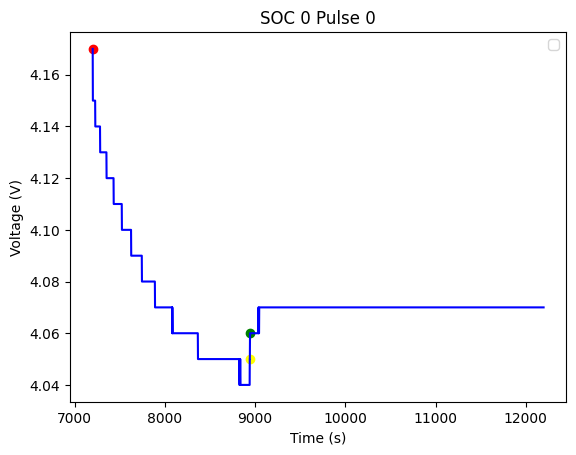

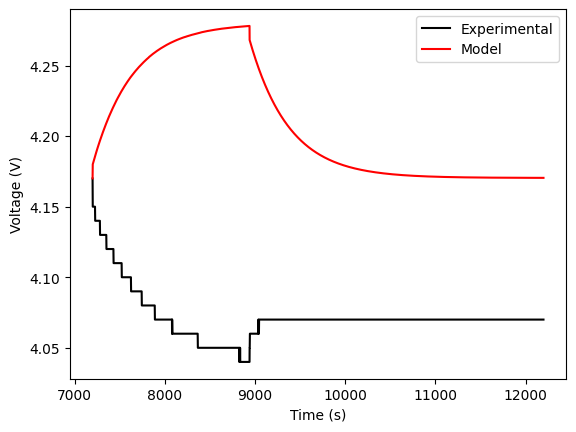

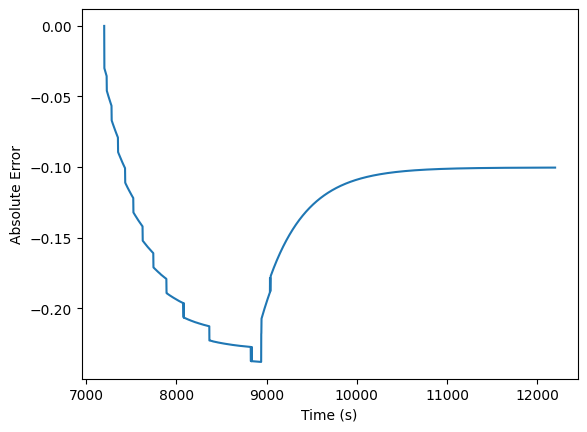

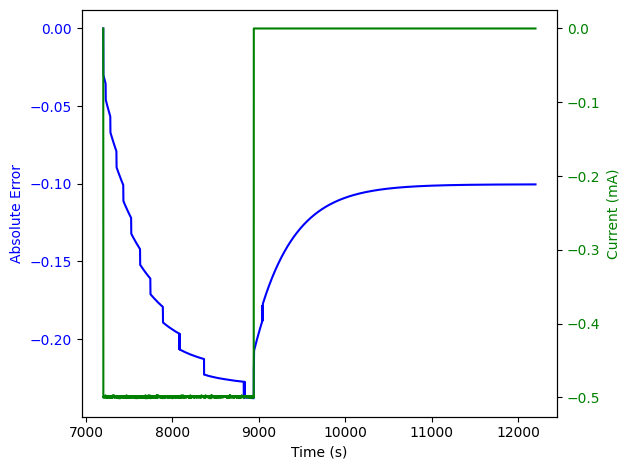

0


Parameters (First Order ECN): 0.01953 0.01247000000000003 530.4731355252783


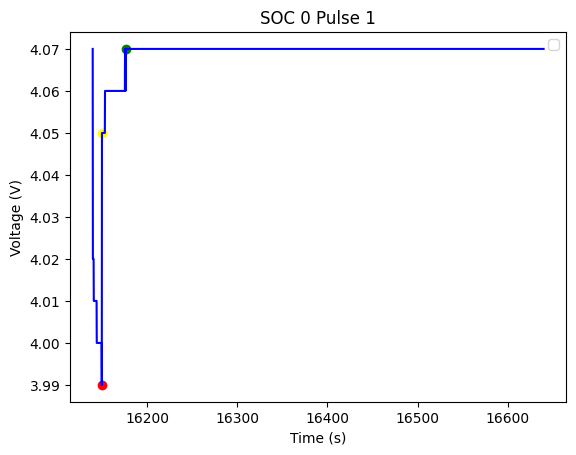

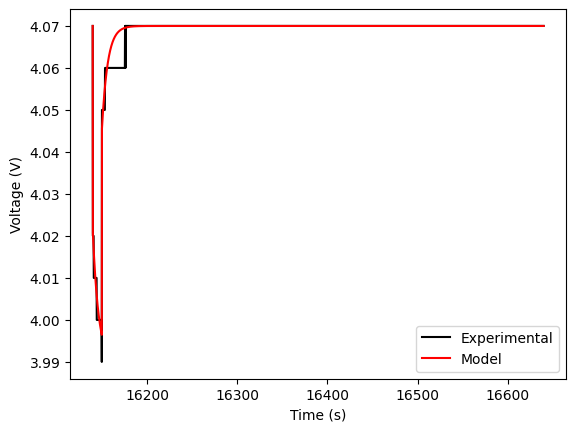

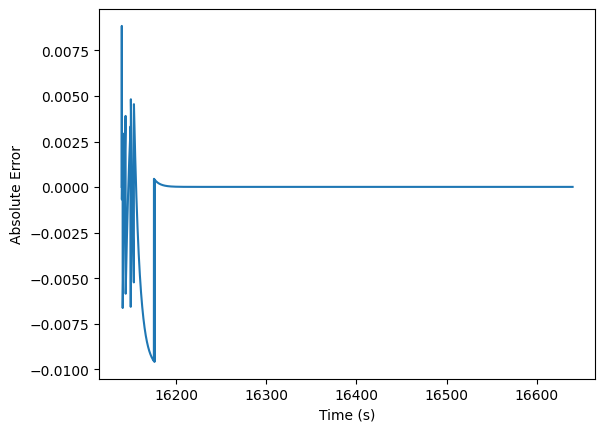

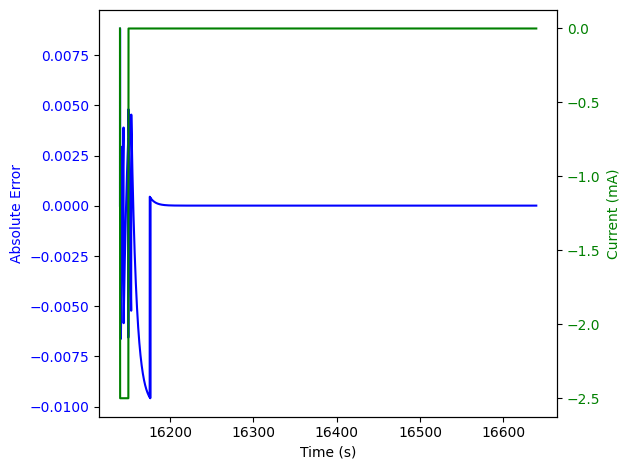

1


Parameters (First Order ECN): 0.01953 0.01247000000000003 1067.7225340817536


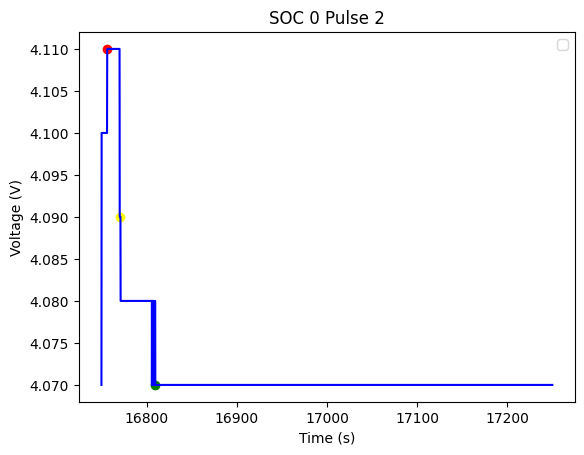

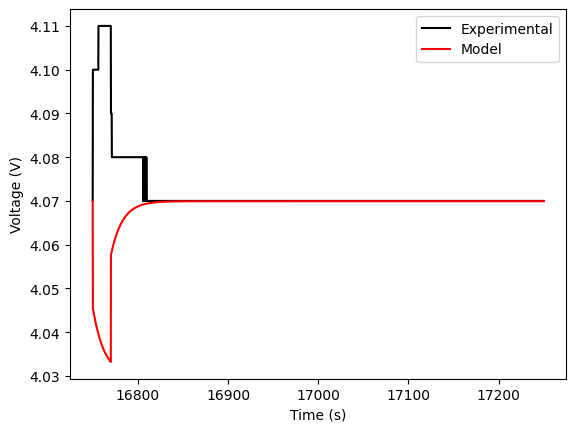

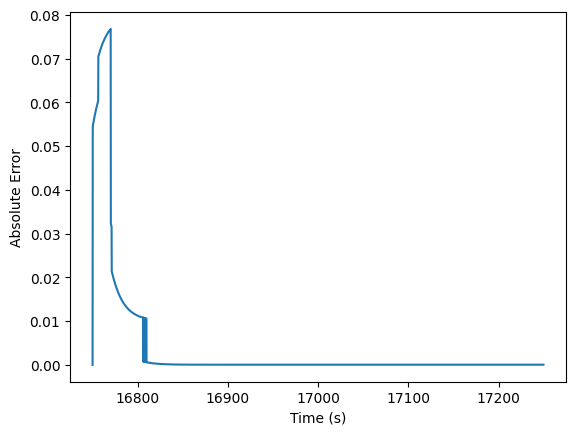

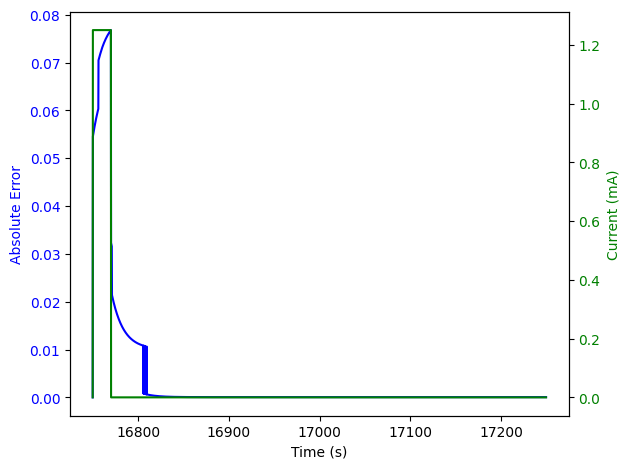

2


Parameters (First Order ECN): 0.01953 0.010470000000000073 1443.696275071612


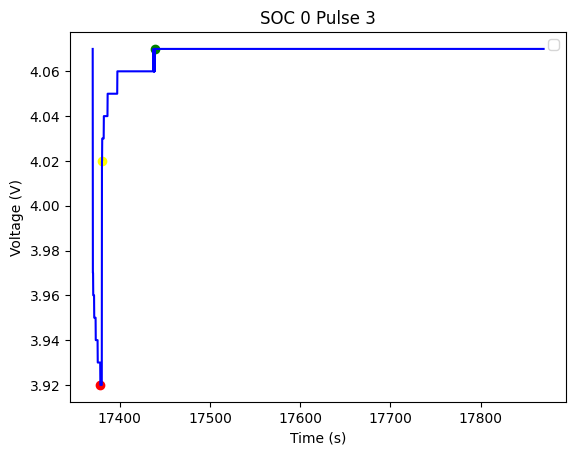

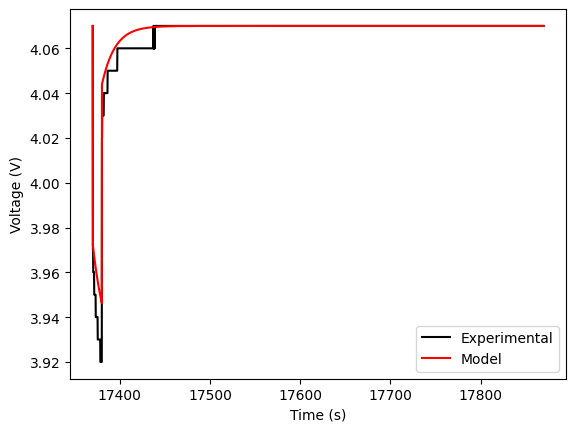

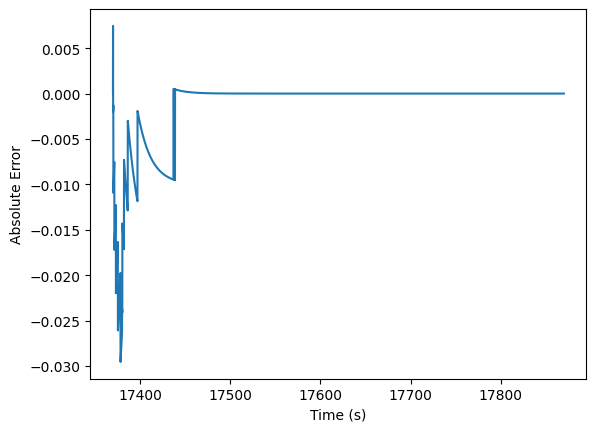

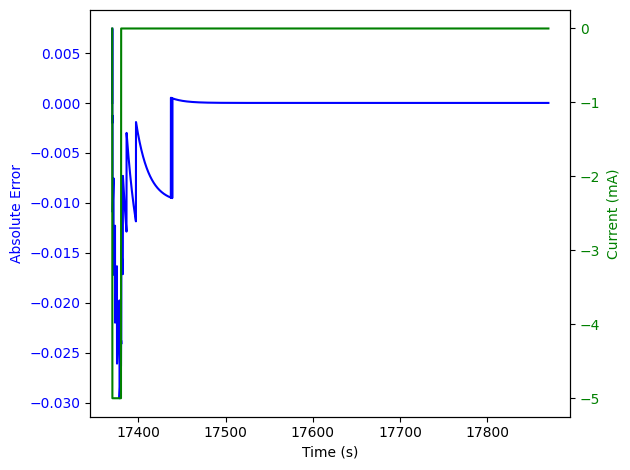

3


Parameters (First Order ECN): 0.01953 0.008470000000000116 592.0306965761696


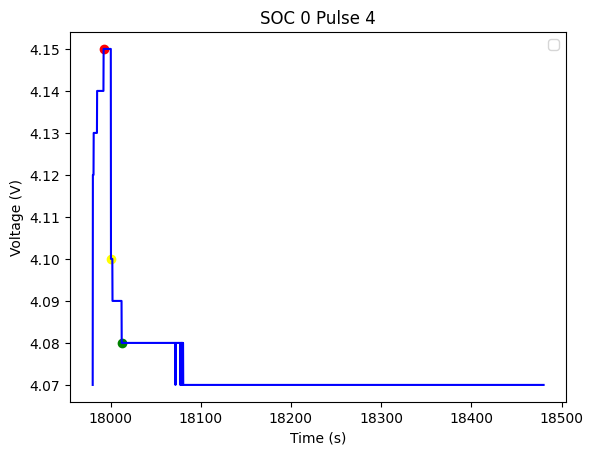

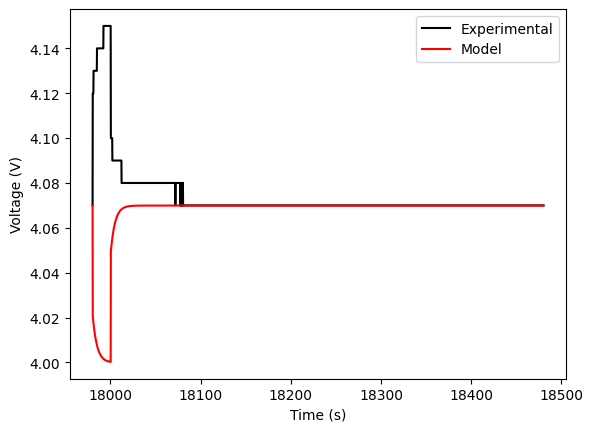

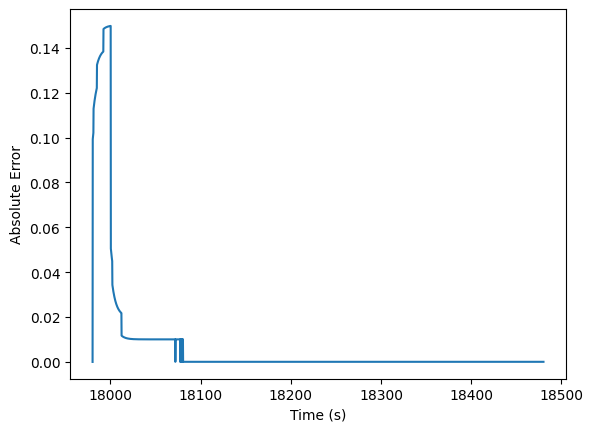

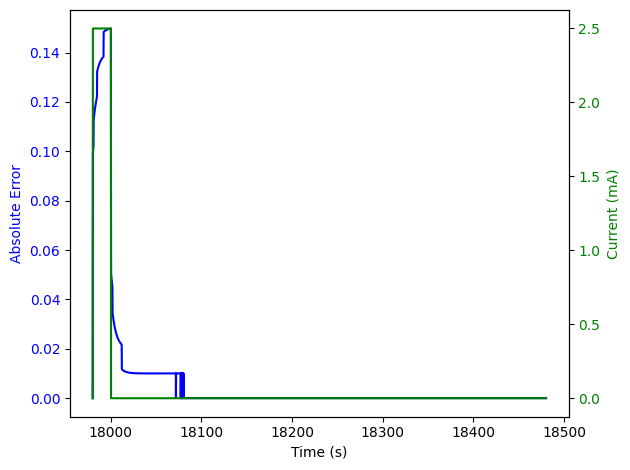

4


Parameters (First Order ECN): 0.01953 0.008469999999999981 1300.5312868948695


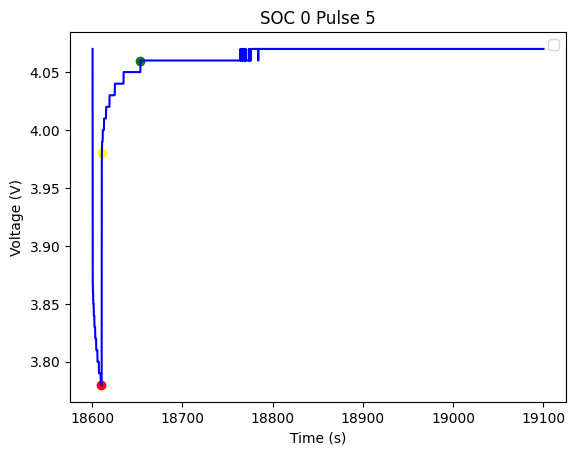

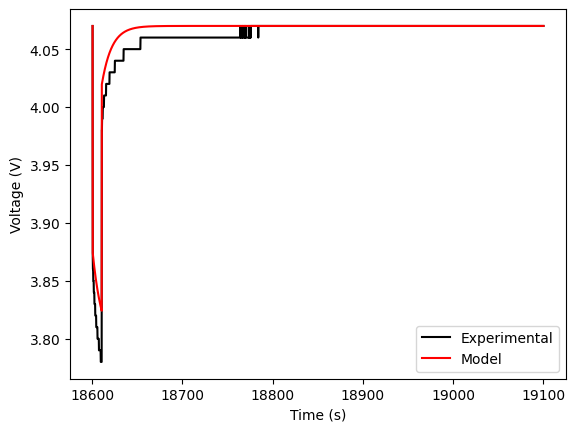

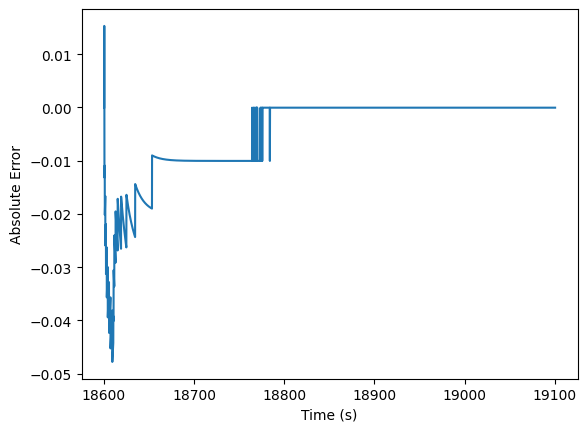

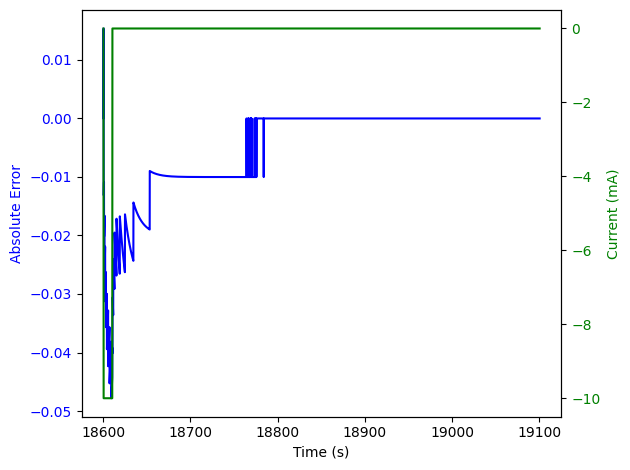

5


Parameters (First Order ECN): 0.01953 0.010470000000000028 767.8130372492526


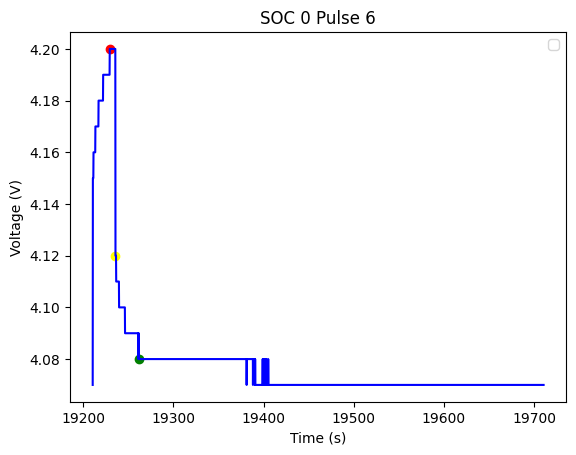

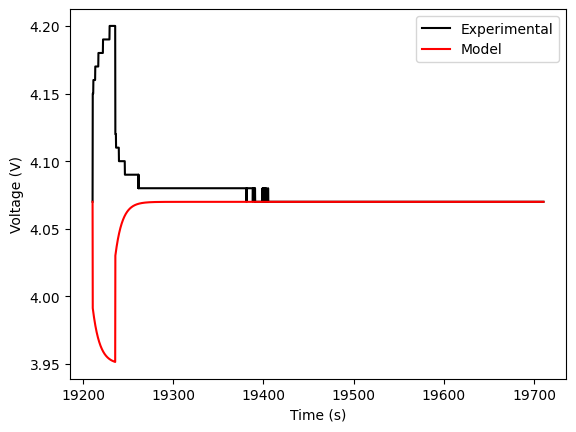

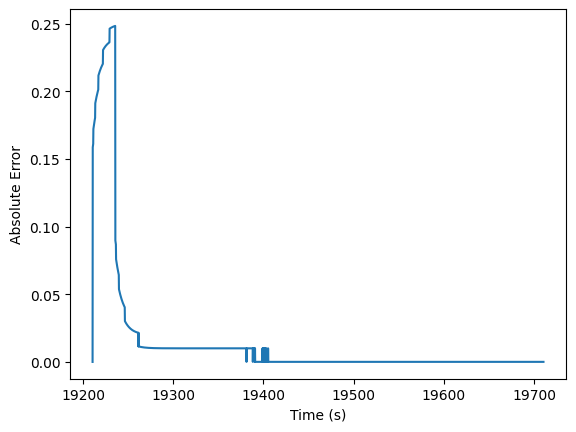

6


Parameters (First Order ECN): 0.01953 0.00746999999999998 3629.8527443106777


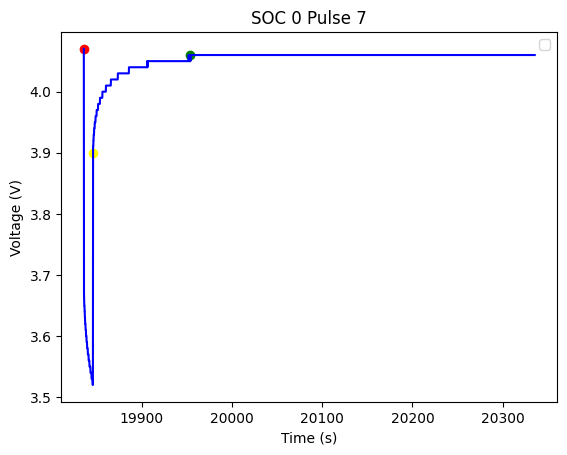

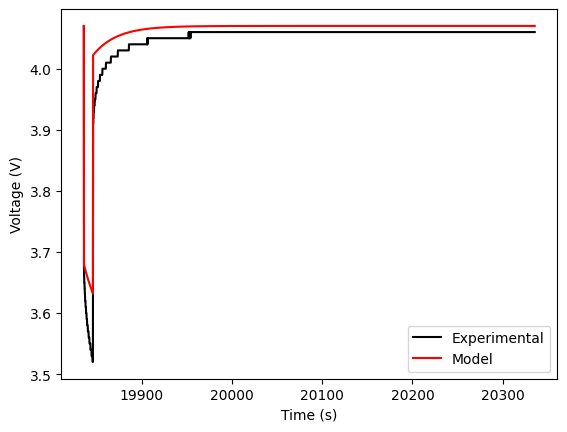

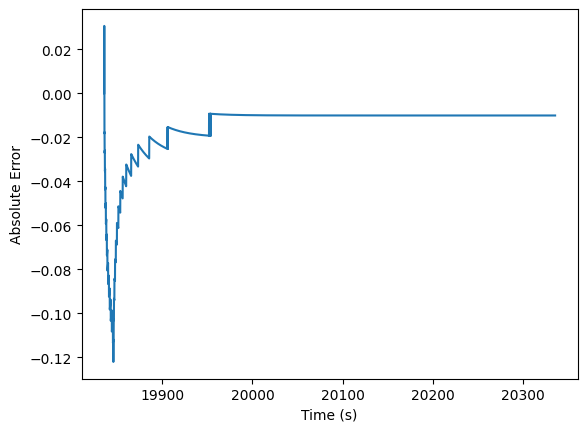

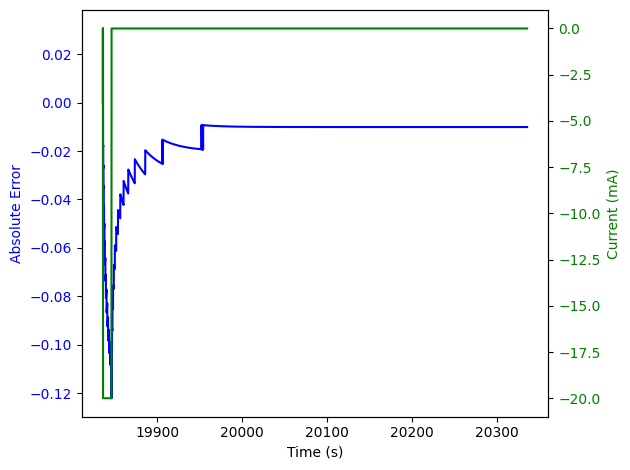

7


Parameters (First Order ECN): 0.01953 0.012969999999999975 1028.48882035467


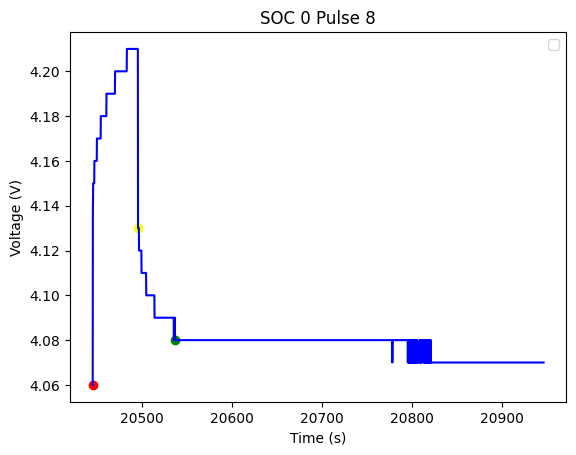

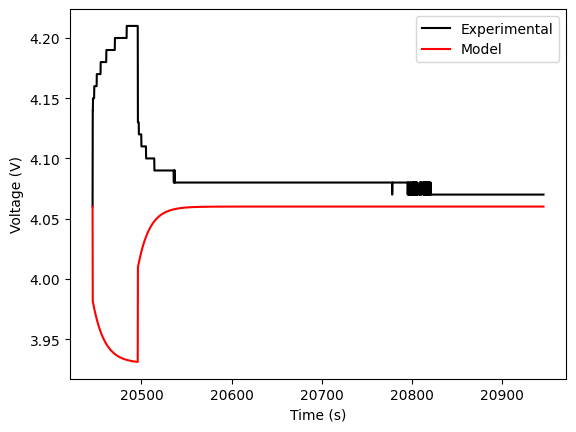

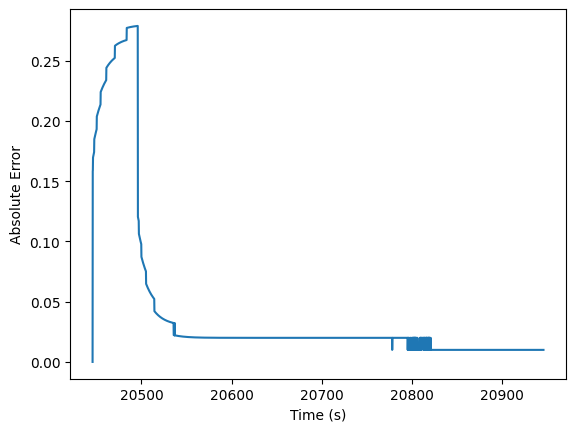

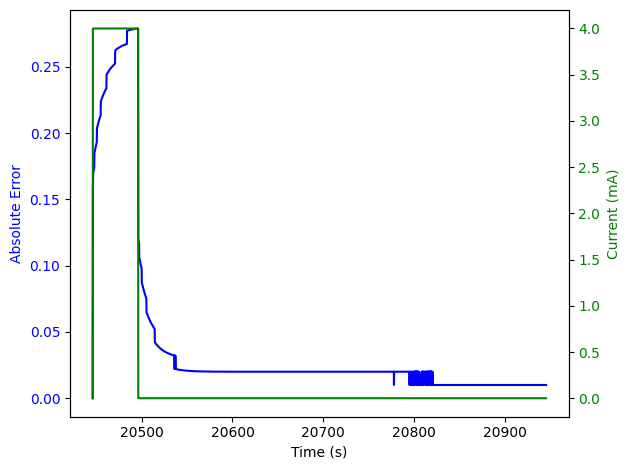

-1


Parameters (First Order ECN): 0.01953 0.16011071856287487 2741.8870138141588


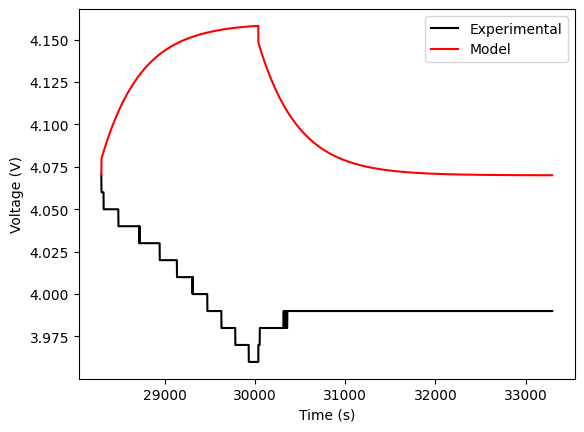

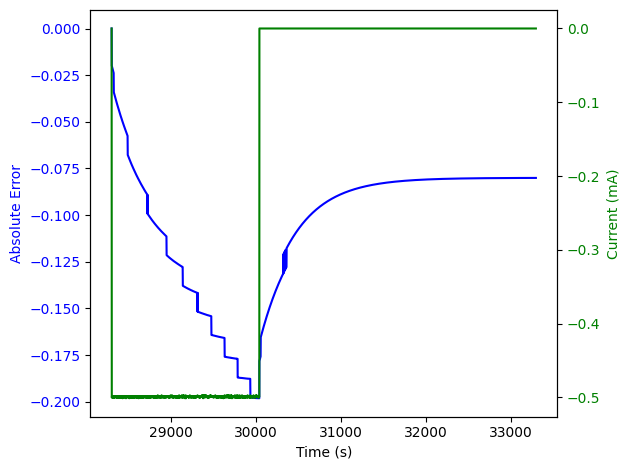

0


Parameters (First Order ECN): 0.01953 0.008469999999999936 382.6446280991747


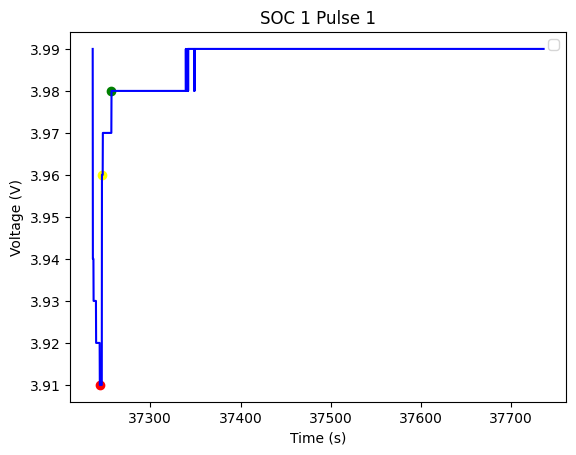

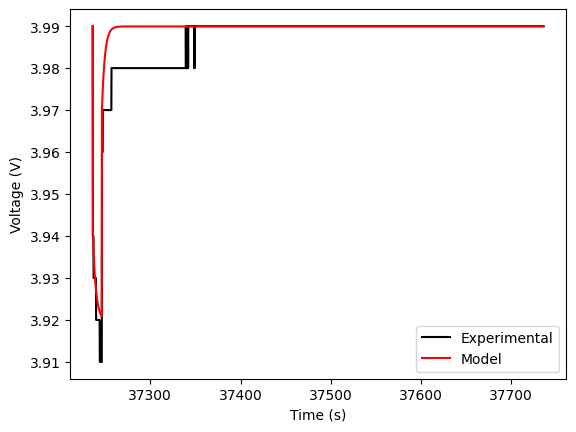

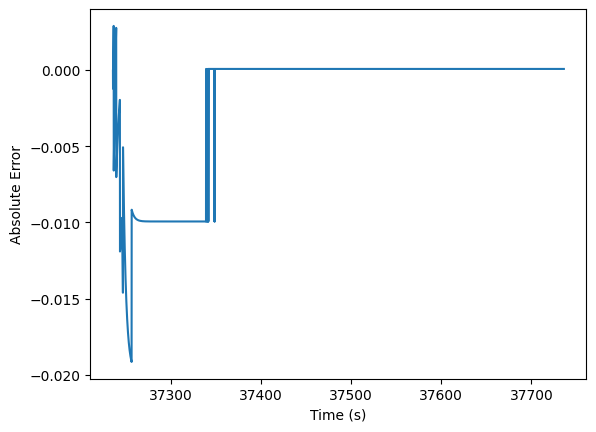

1


Parameters (First Order ECN): 0.01953 0.01247000000000003 841.138732959066


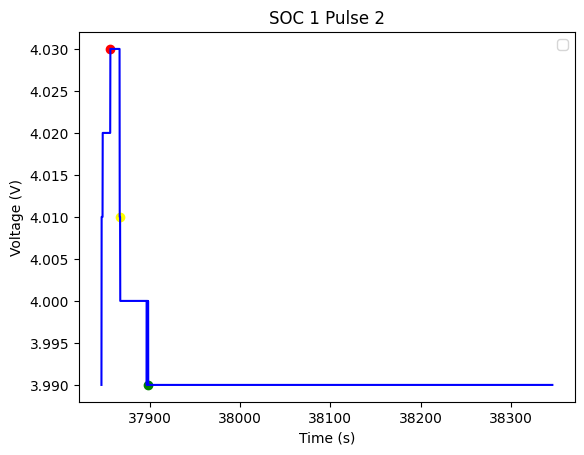

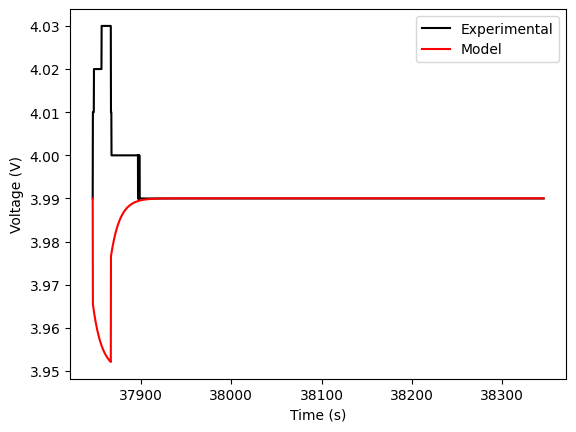

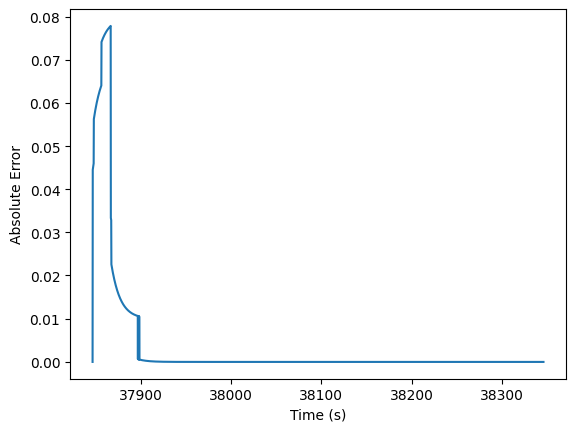

2


Parameters (First Order ECN): 0.01953 0.010469999999999983 1042.5501432663968


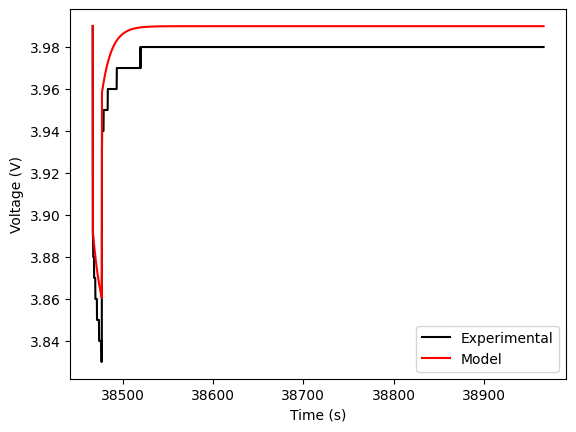

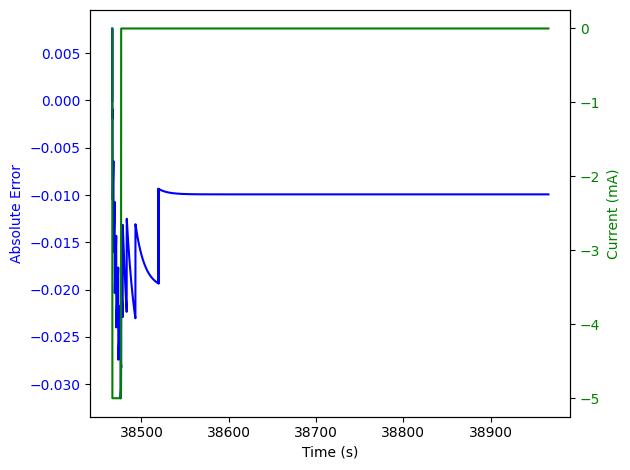

3


Parameters (First Order ECN): 0.01953 0.008470000000000116 476.85950413230387


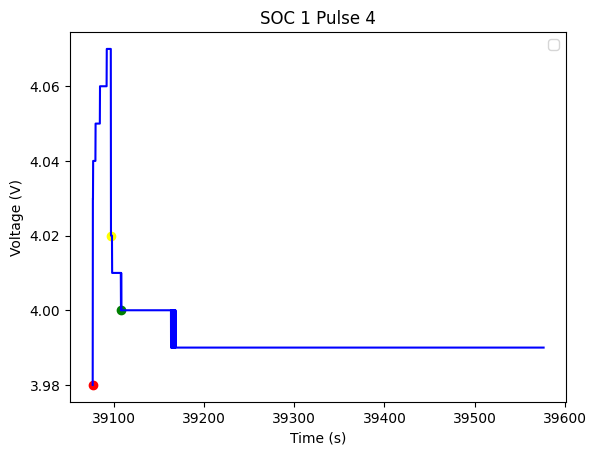

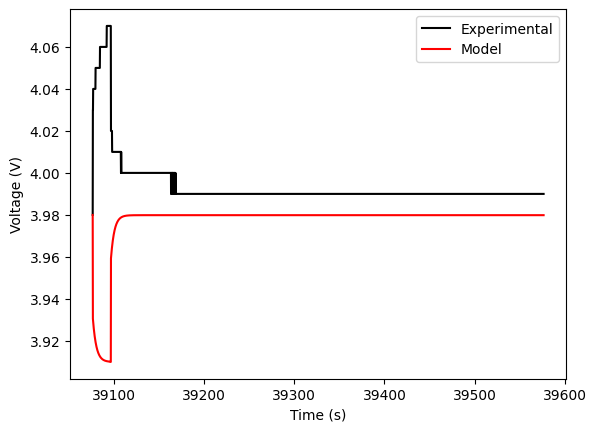

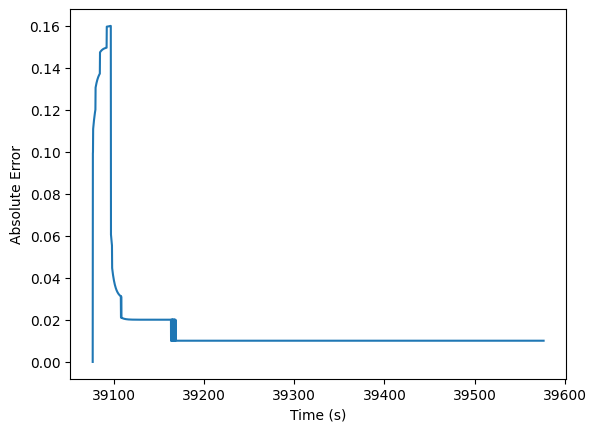

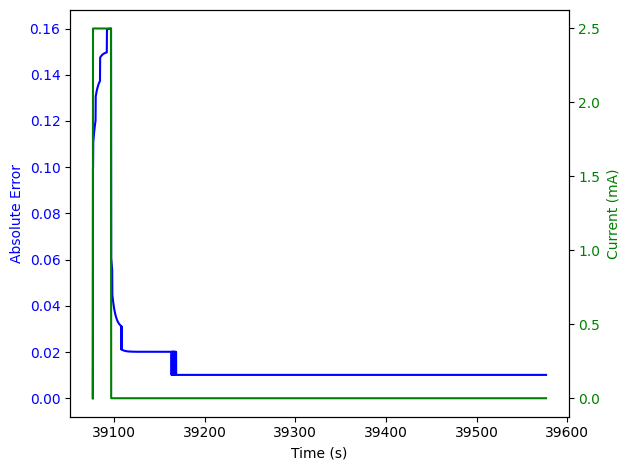

4


Parameters (First Order ECN): 0.01953 0.008470000000000026 1864.1676505311575


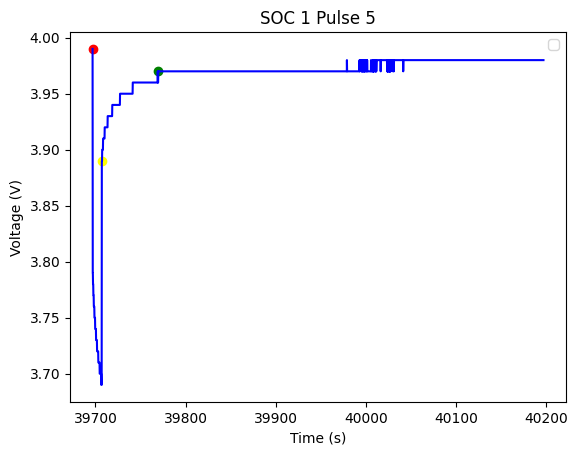

5


Parameters (First Order ECN): 0.01953 0.010470000000000028 653.1996179560576


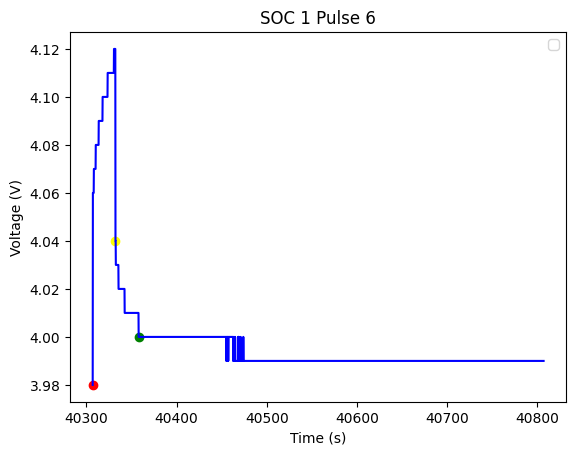

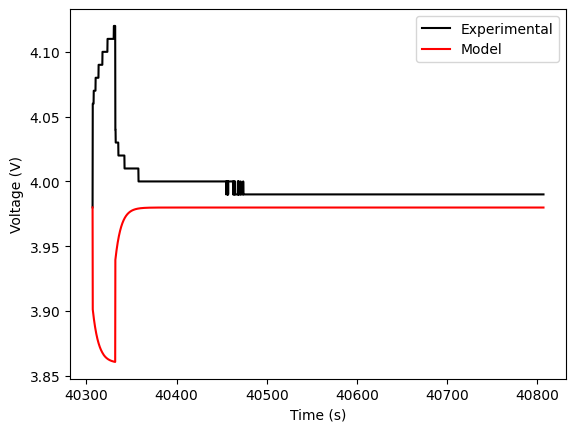

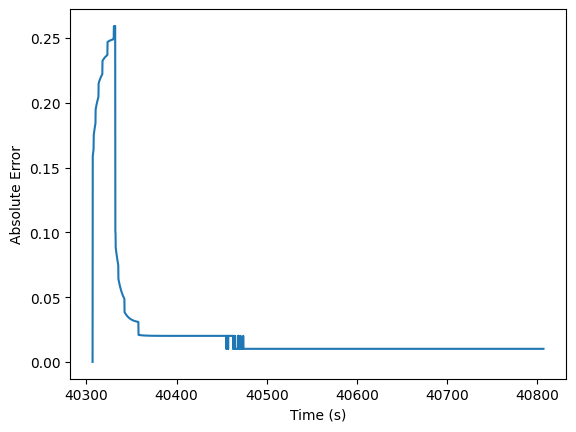

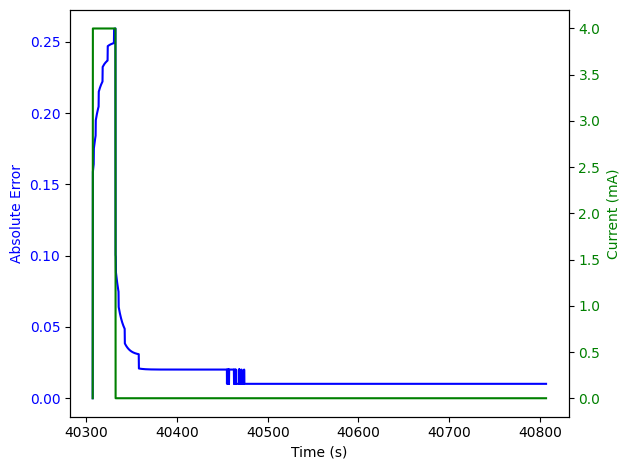

6


Parameters (First Order ECN): 0.01953 0.0059700000000000135 3448.6599664994324


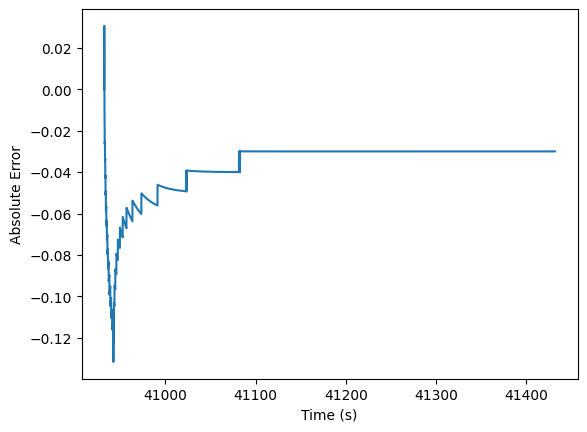

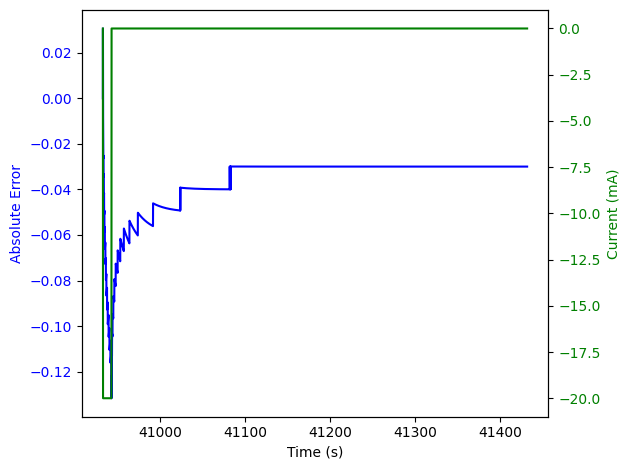

7


Parameters (First Order ECN): 0.01953 0.012969999999999975 749.1133384734286


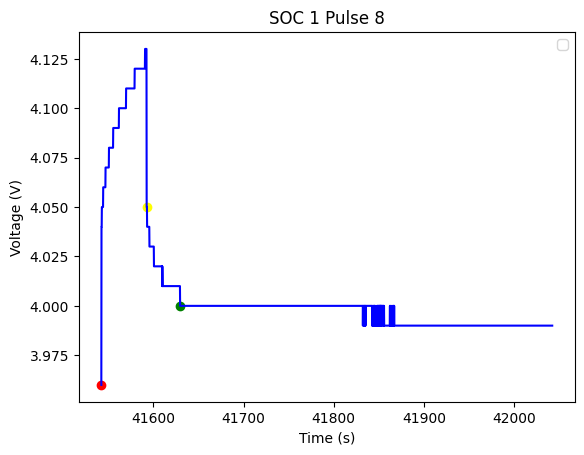

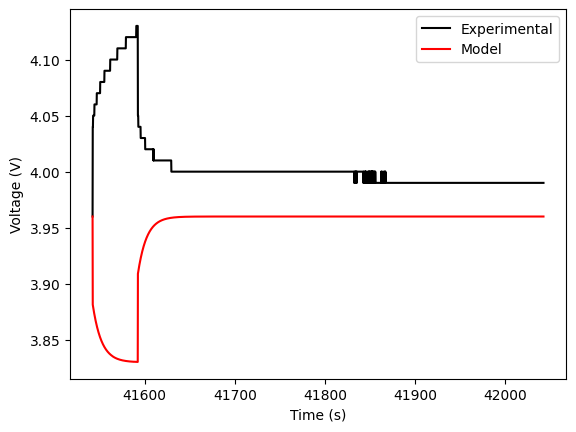

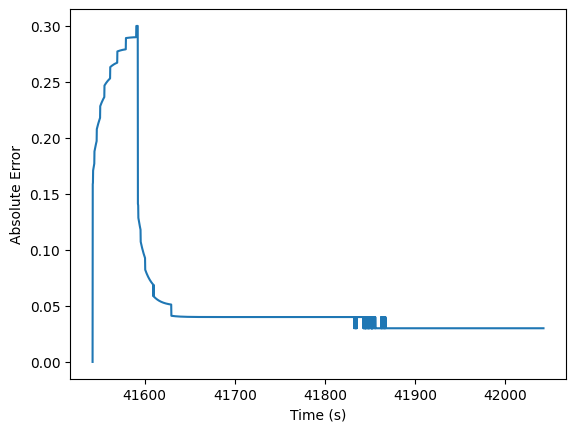

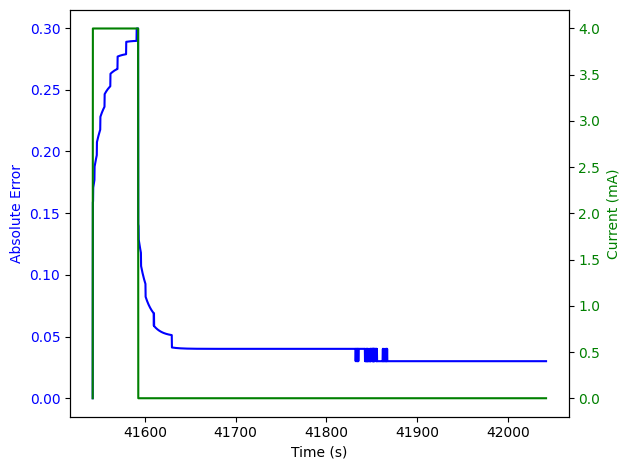

-1


Parameters (First Order ECN): 0.01953 0.1800707984031938 2480.6881596637436


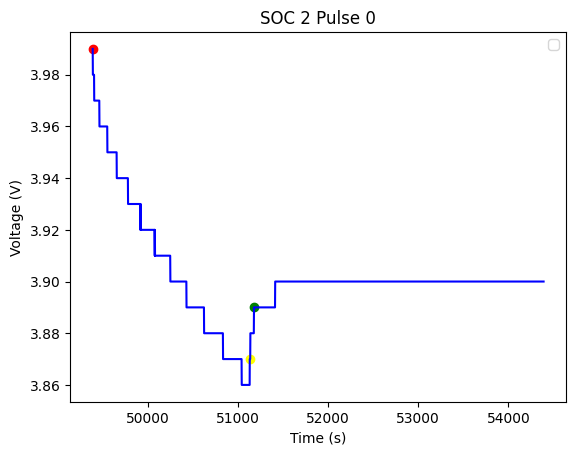

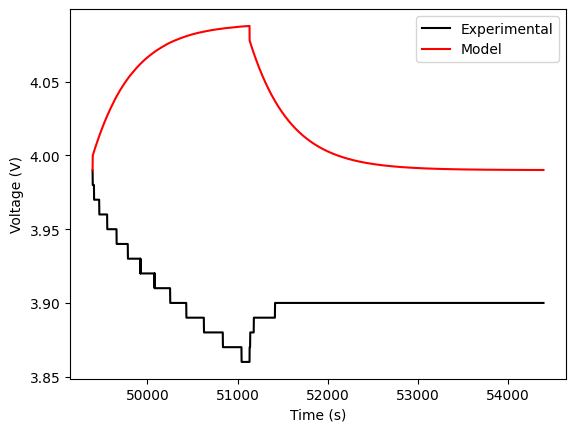

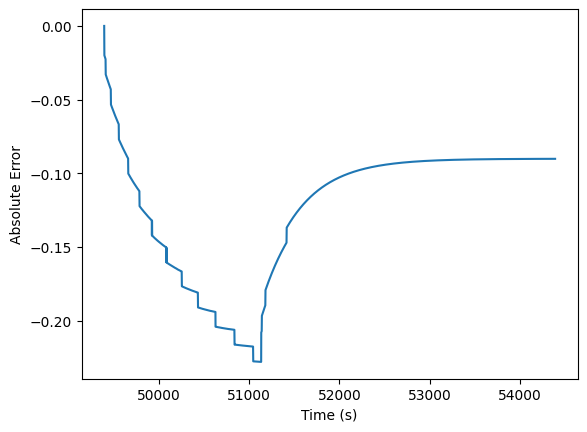

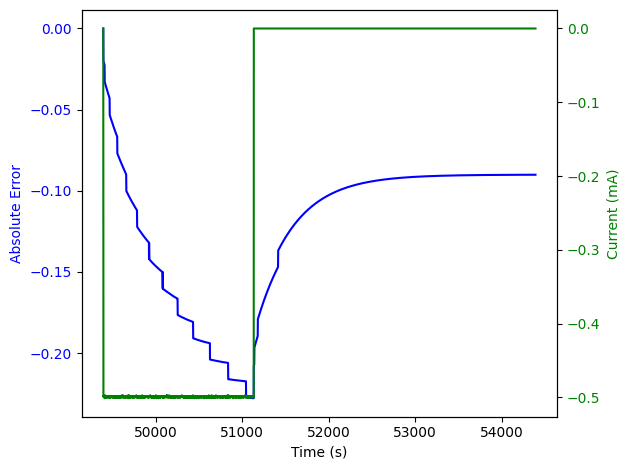

0


Parameters (First Order ECN): 0.01953 0.008470000000000116 350.00000000000034


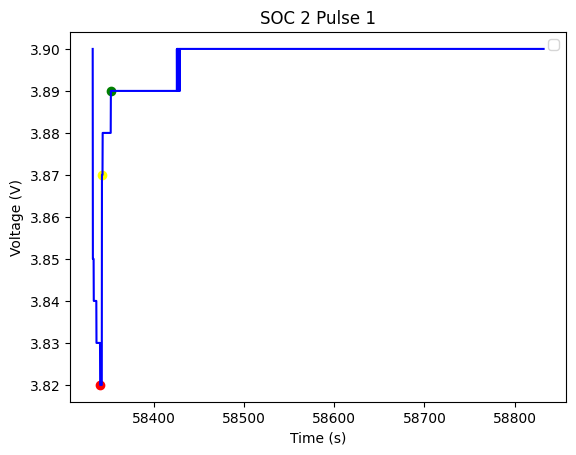

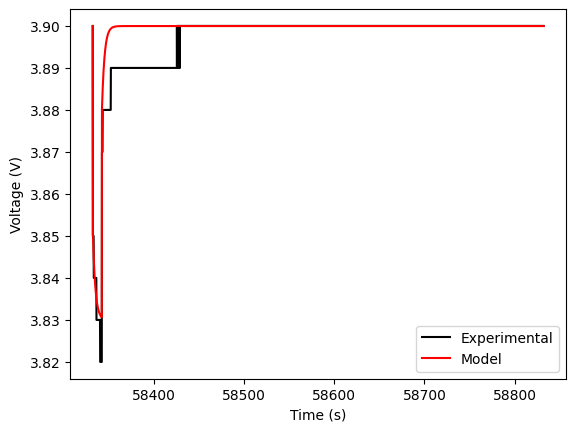

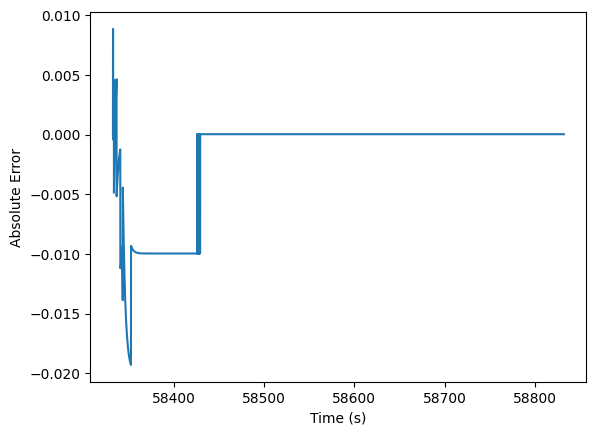

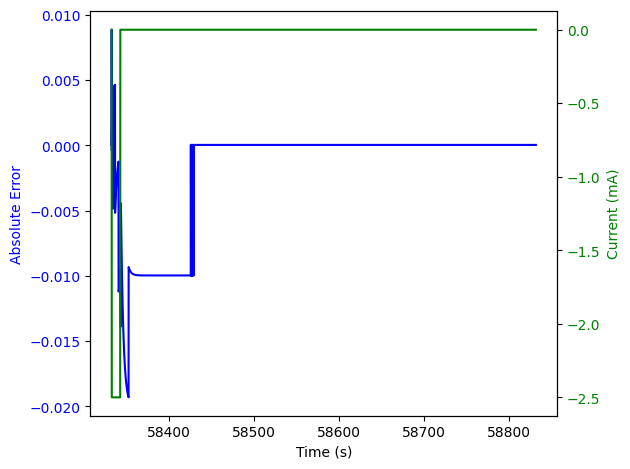

1


Parameters (First Order ECN): 0.01953 0.01247000000000003 1254.2101042502966


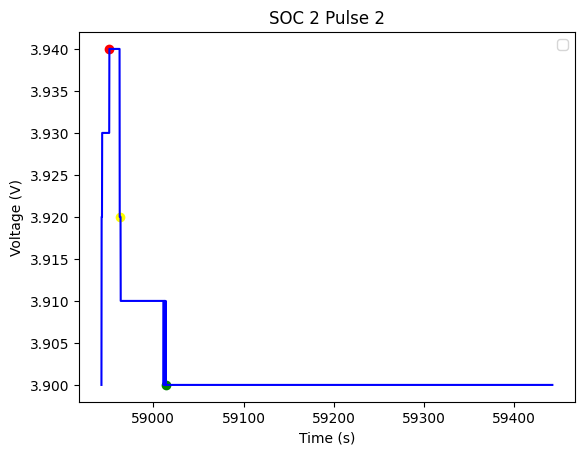

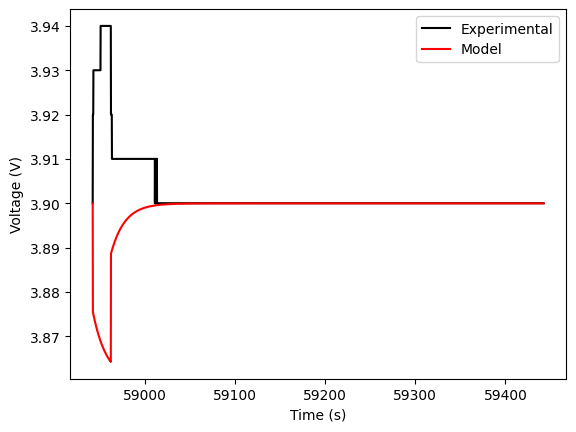

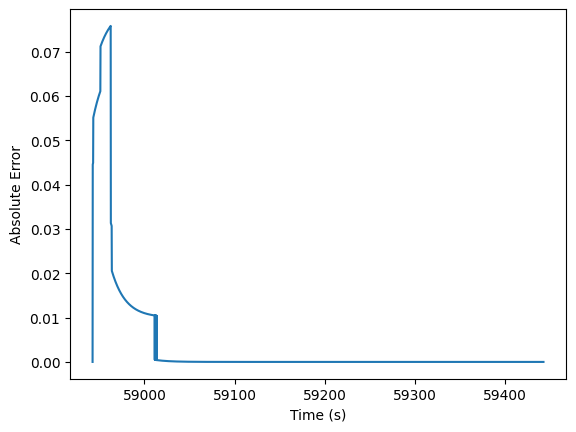

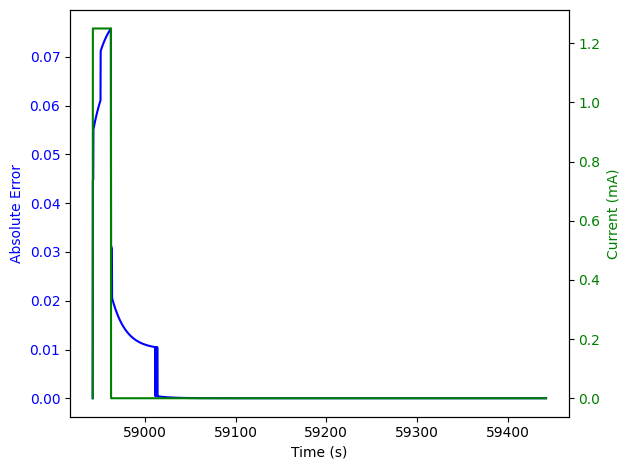

2


Parameters (First Order ECN): 0.01953 0.008470000000000026 1409.5631641086504


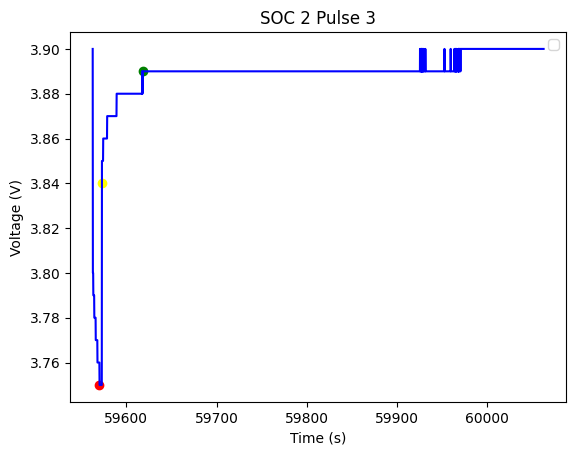

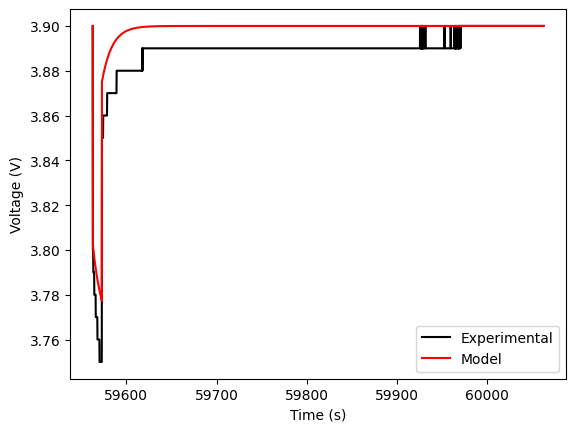

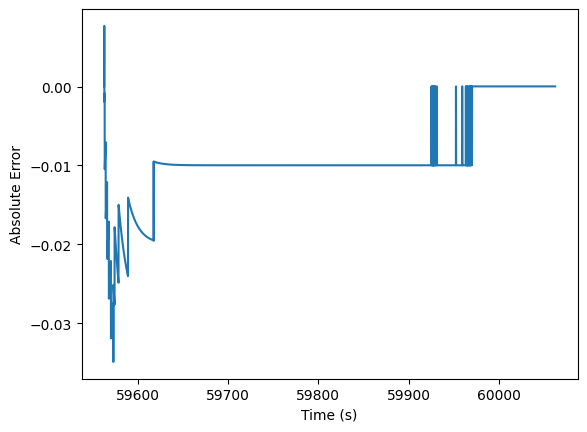

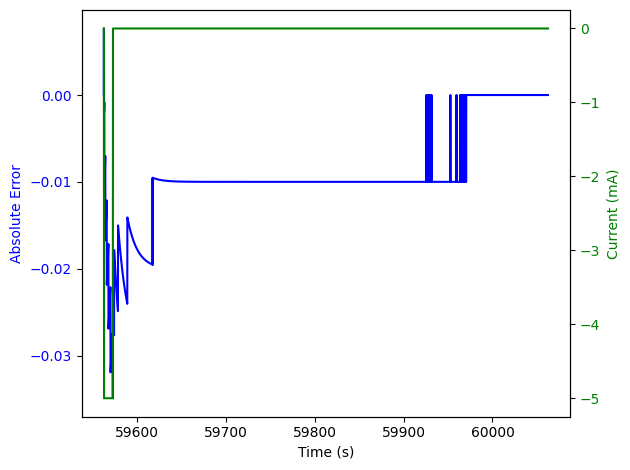

3


Parameters (First Order ECN): 0.01953 0.008469999999999936 544.8642266823869


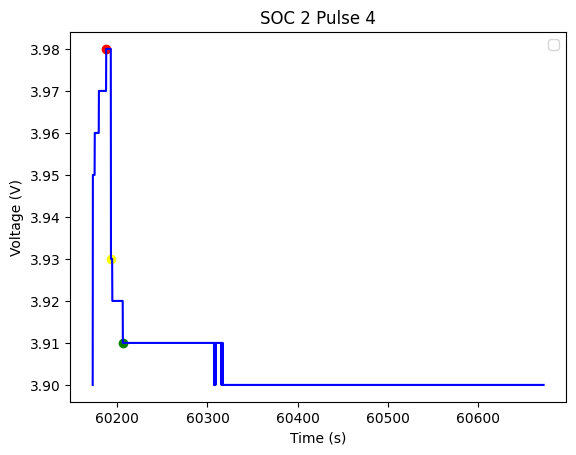

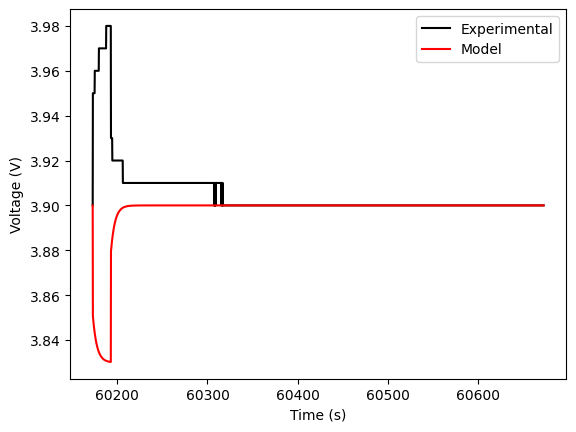

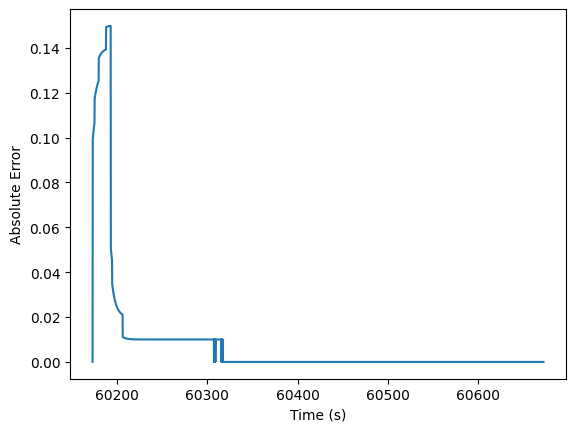

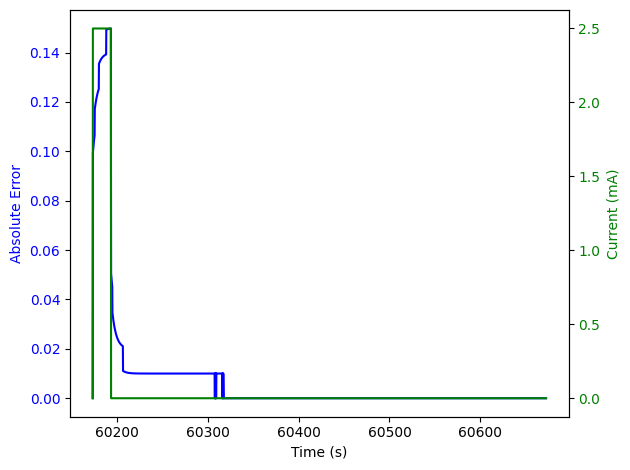

4


Parameters (First Order ECN): 0.01953 0.007470000000000004 2351.5394912986217


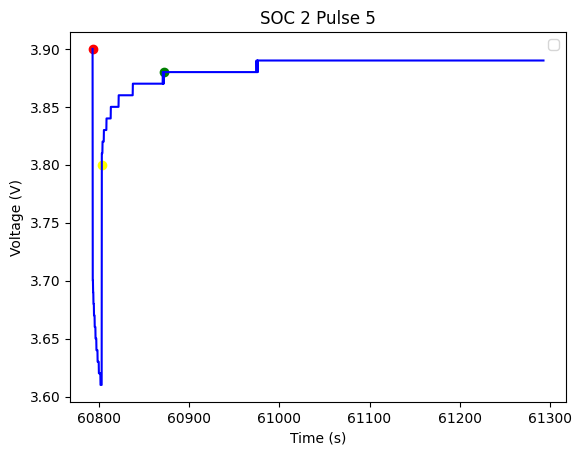

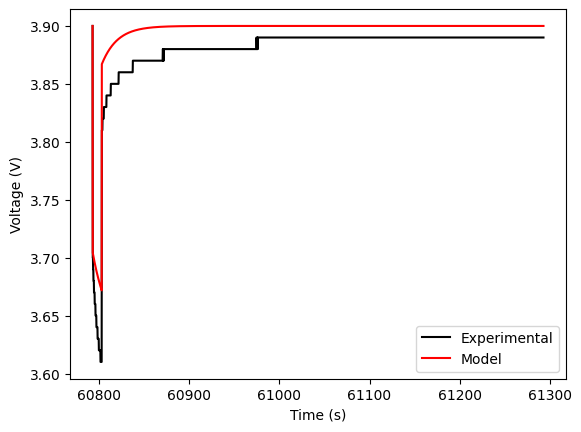

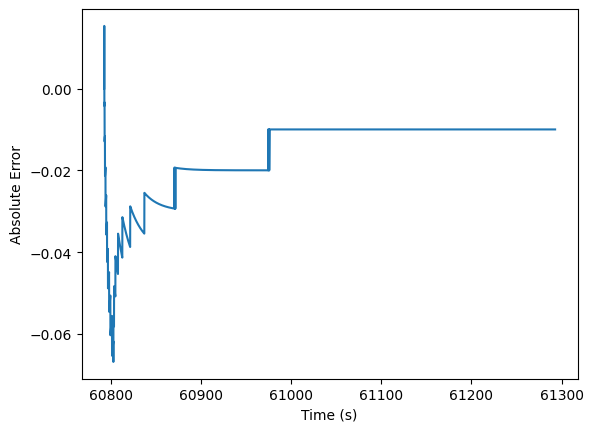

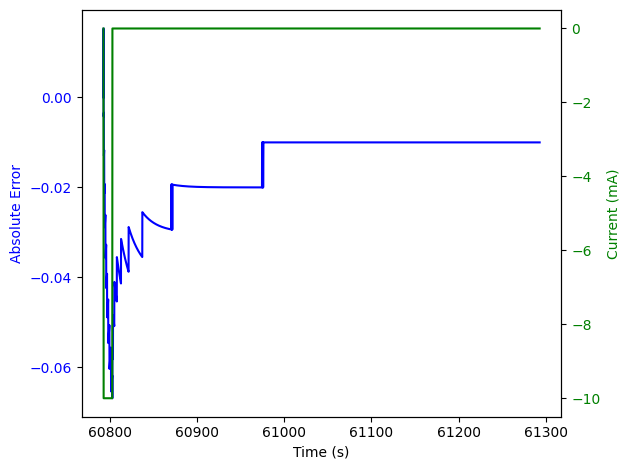

5


Parameters (First Order ECN): 0.01953 0.010470000000000028 715.281757402059


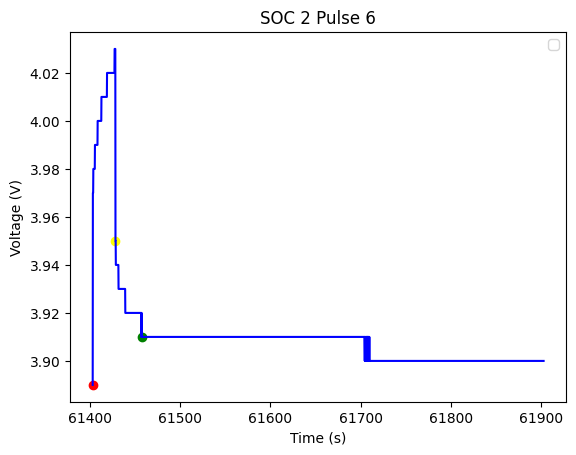

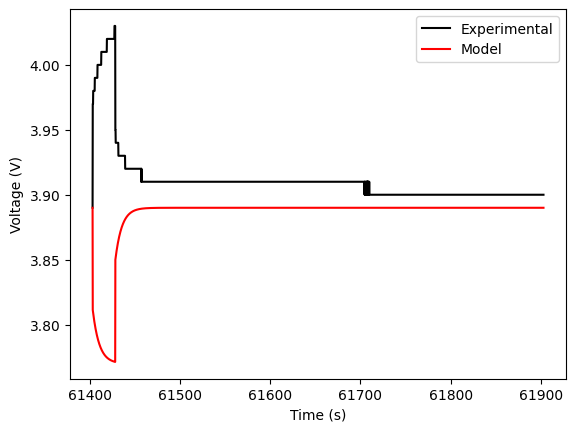

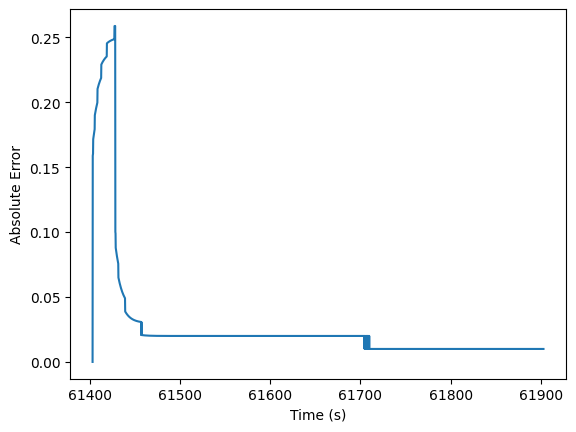

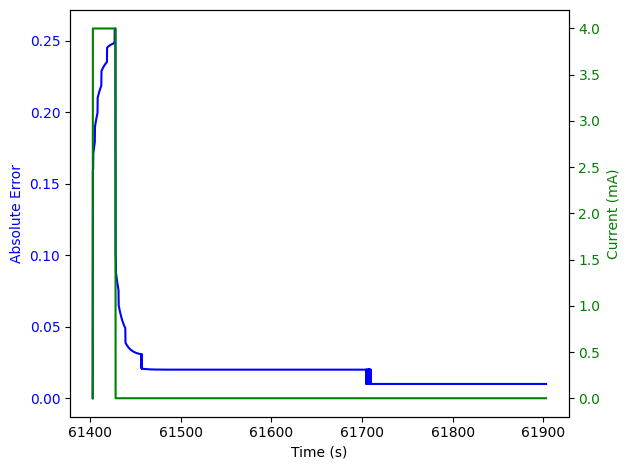

6


Parameters (First Order ECN): 0.01953 0.005470000000000003 3343.692870201255


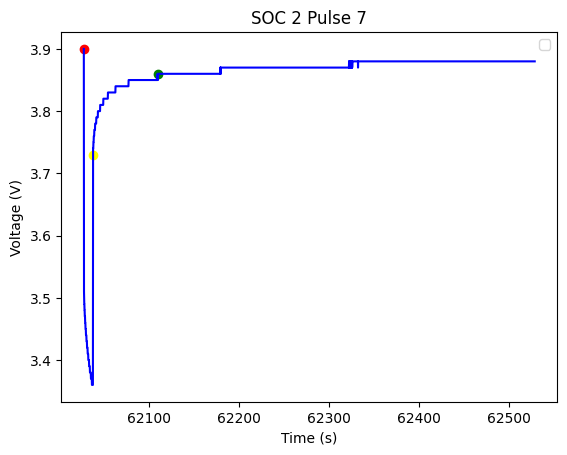

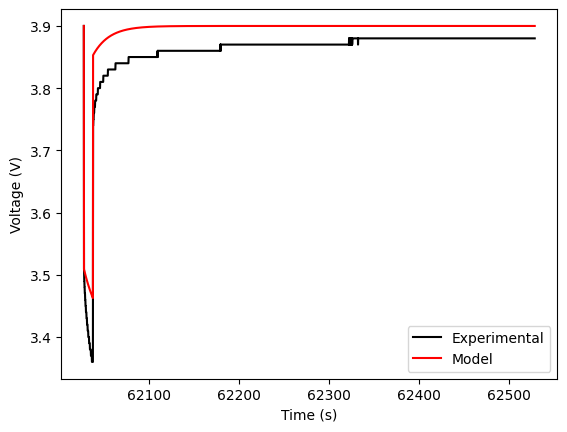

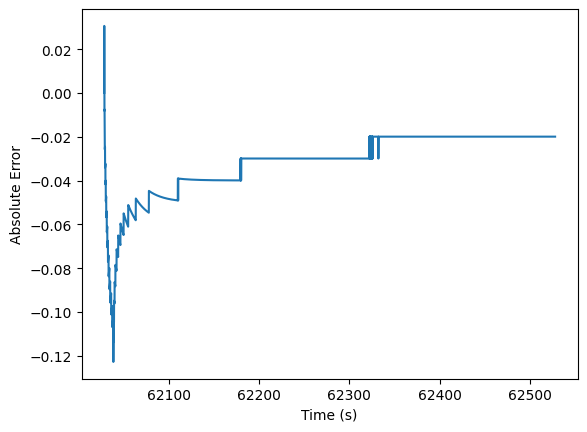

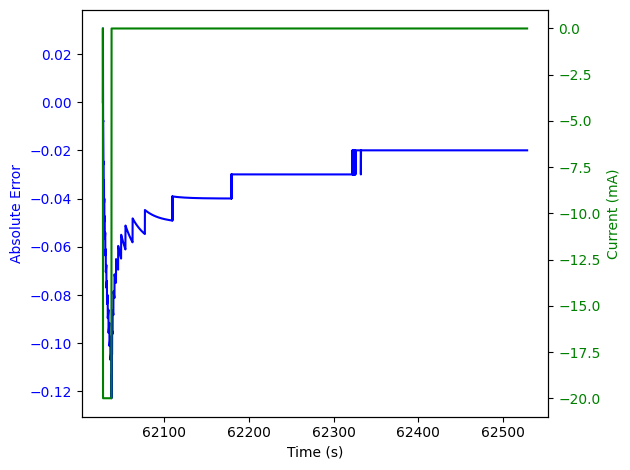

7


Parameters (First Order ECN): 0.01953 0.012969999999999975 860.8326908250498


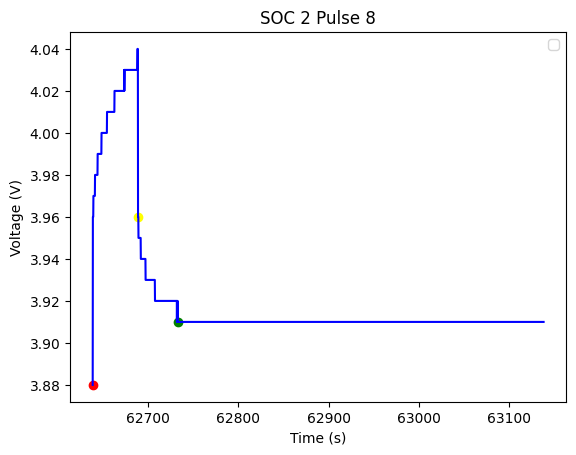

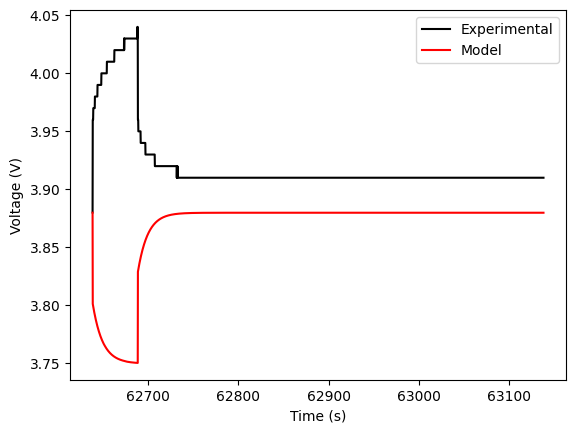

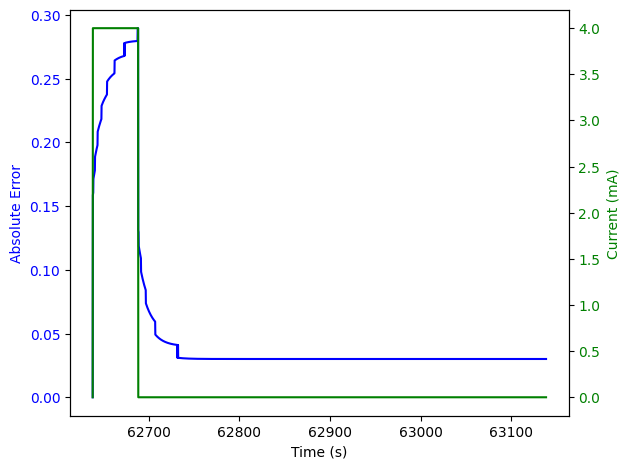

-1


Parameters (First Order ECN): 0.01953 0.21999095808383257 1980.4768513893632


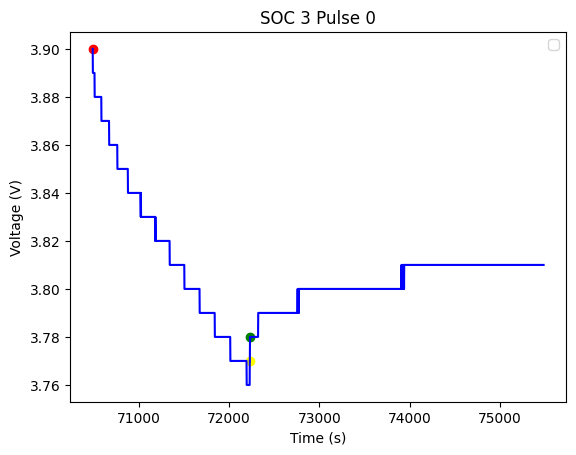

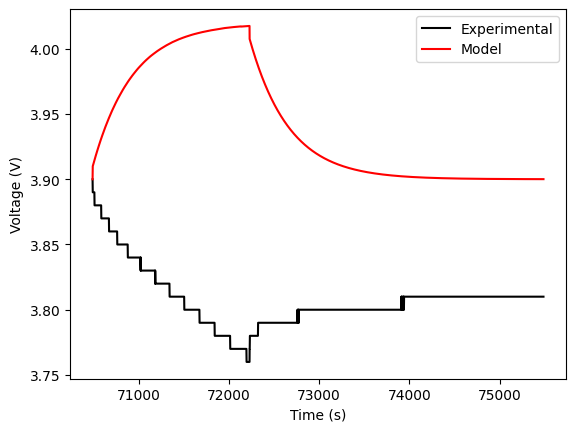

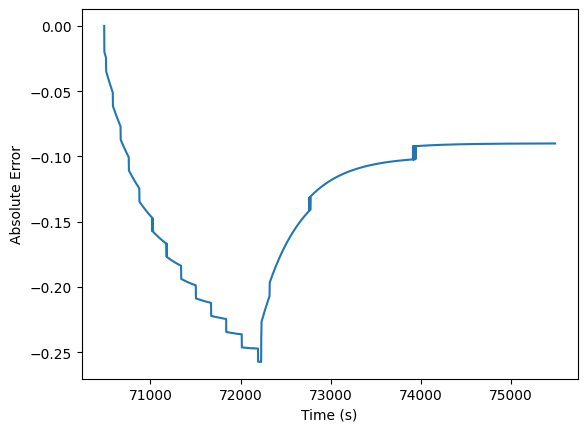

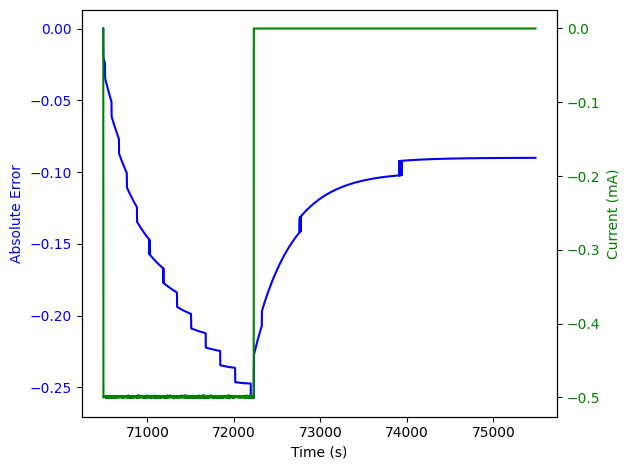

0


Parameters (First Order ECN): 0.01953 0.008469999999999936 199.52774498213734


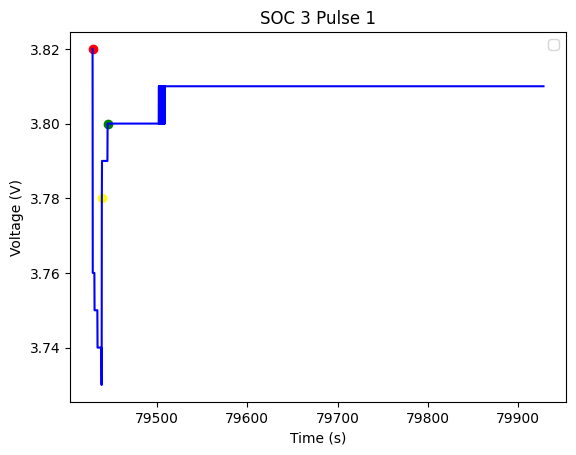

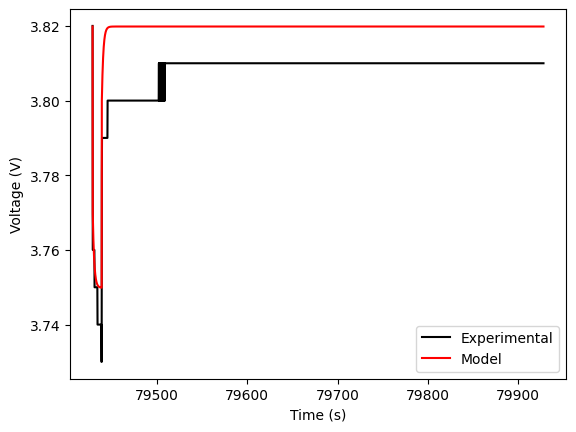

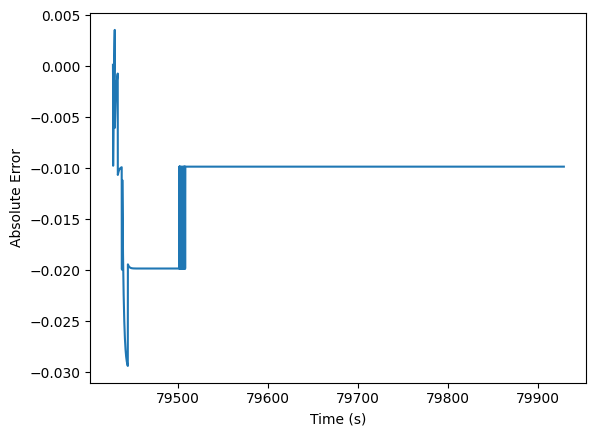

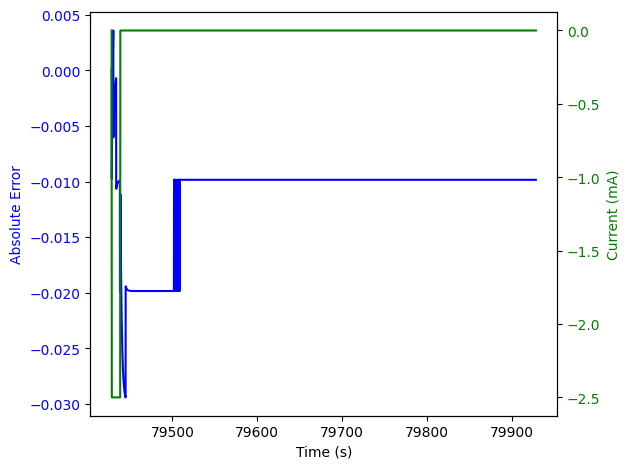

1


Parameters (First Order ECN): 0.01953 0.01247000000000003 159.50280673598672


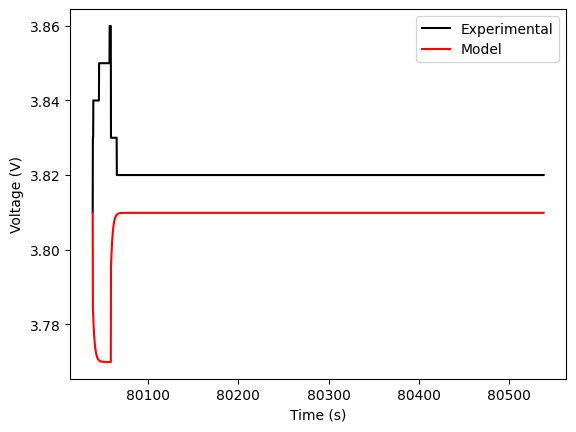

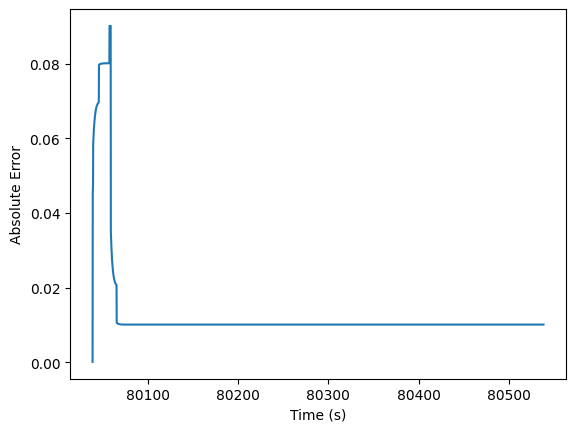

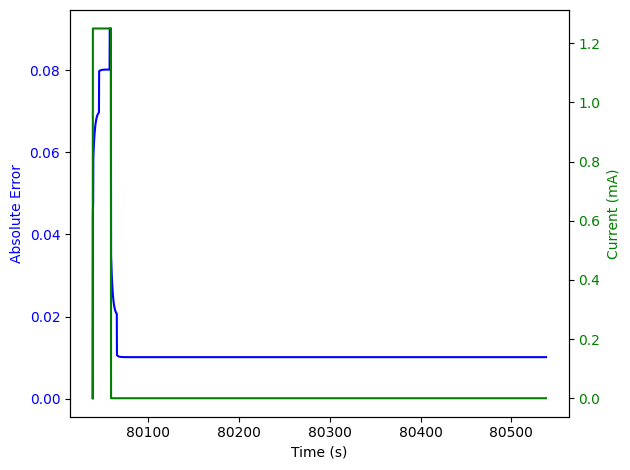

2


Parameters (First Order ECN): 0.01953 0.008469999999999936 1465.761511216171


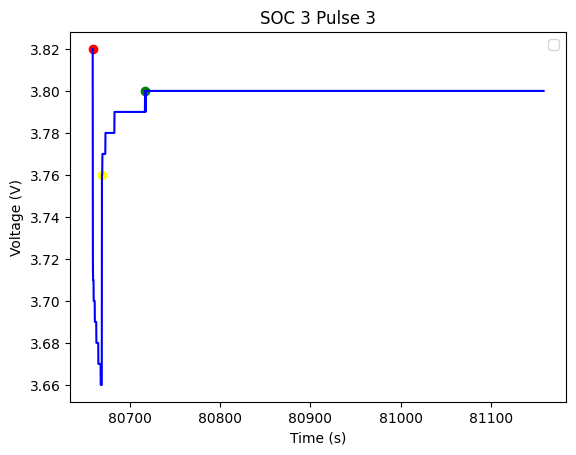

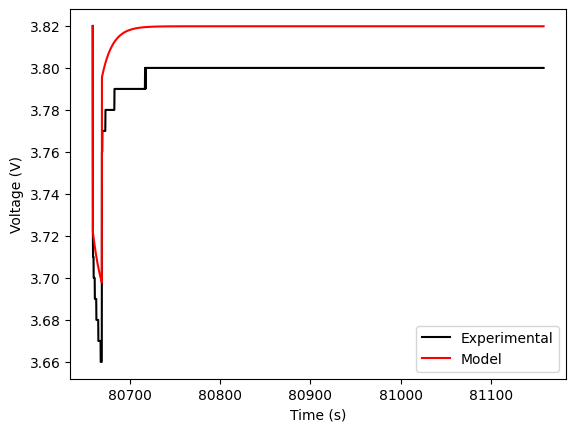

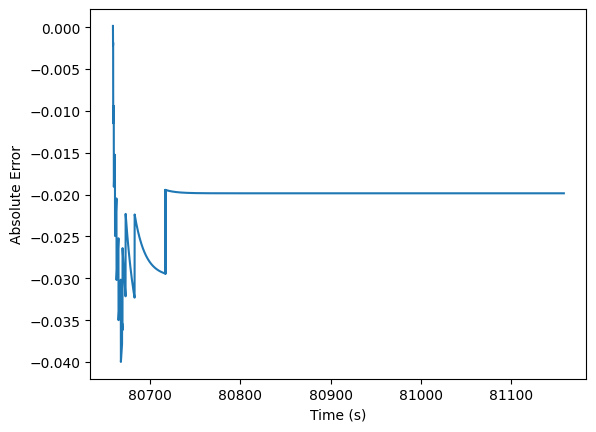

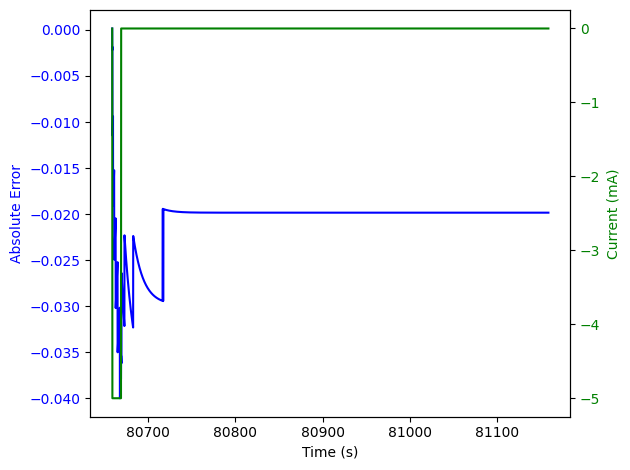

3


Parameters (First Order ECN): 0.01953 0.008470000000000116 987.4262101534075


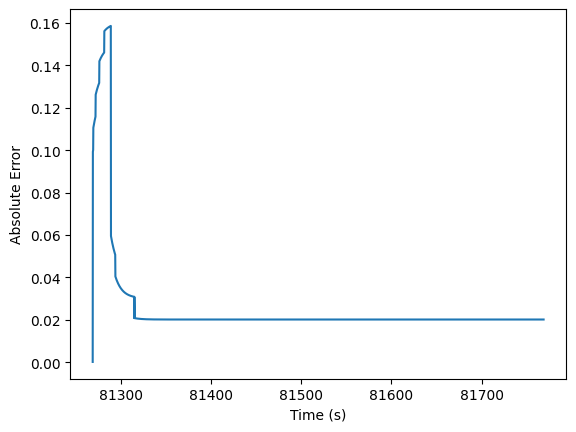

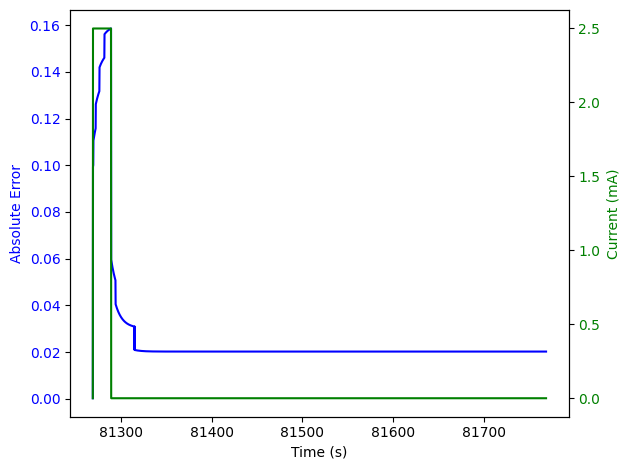

4


Parameters (First Order ECN): 0.01953 0.006469999999999979 1215.6877897990585


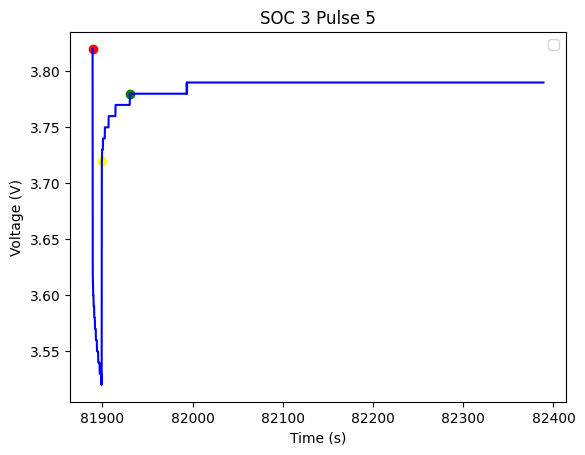

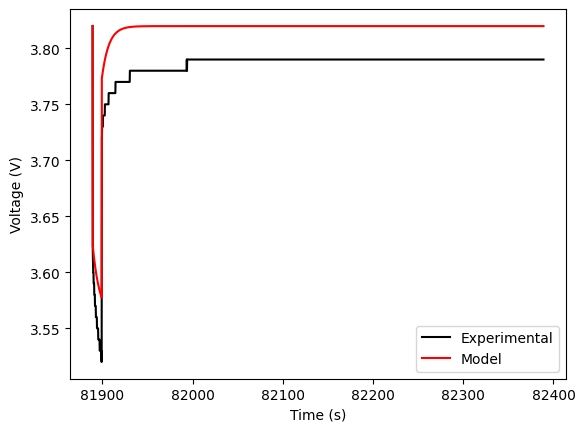

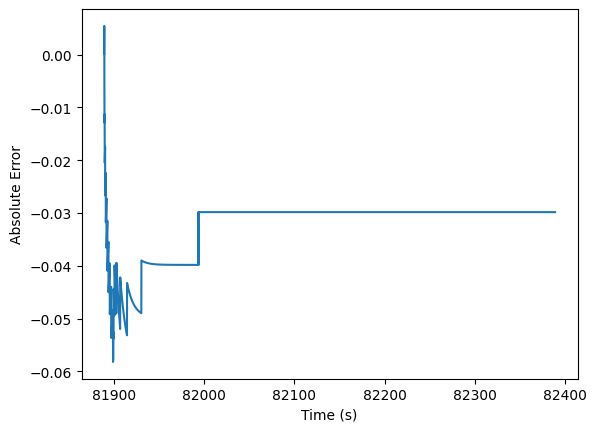

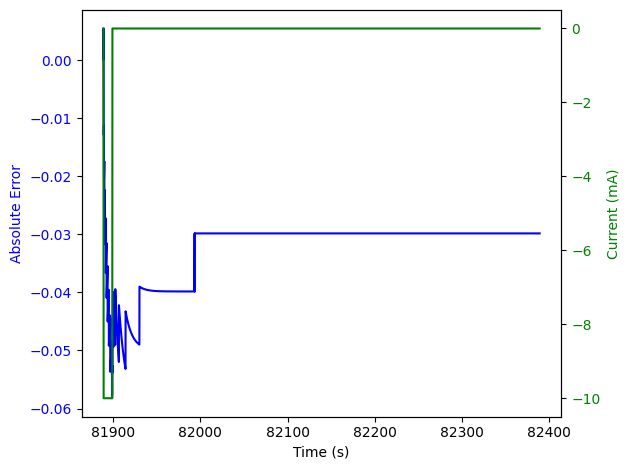

5


Parameters (First Order ECN): 0.01953 0.010470000000000028 1259.742359121068


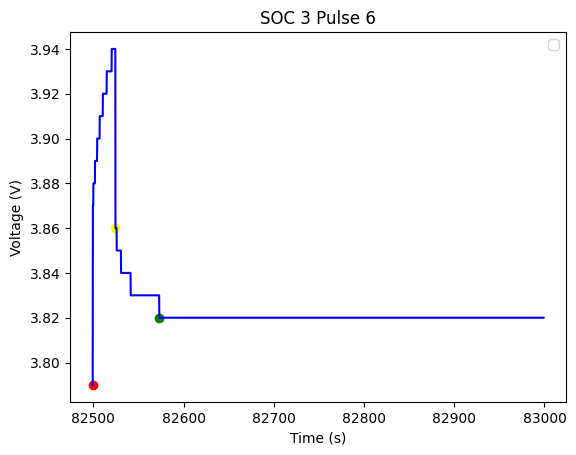

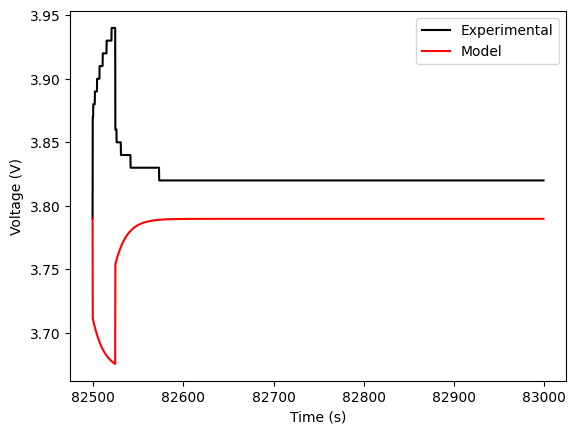

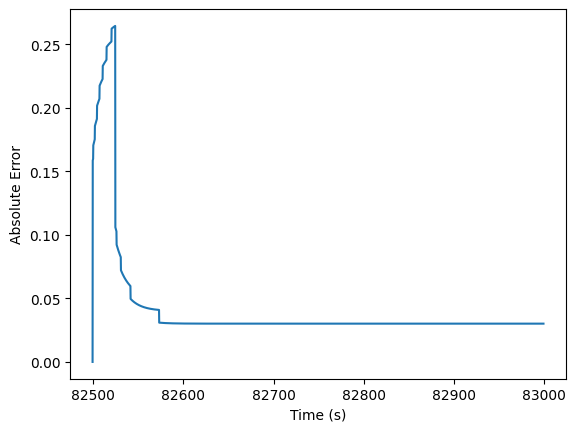

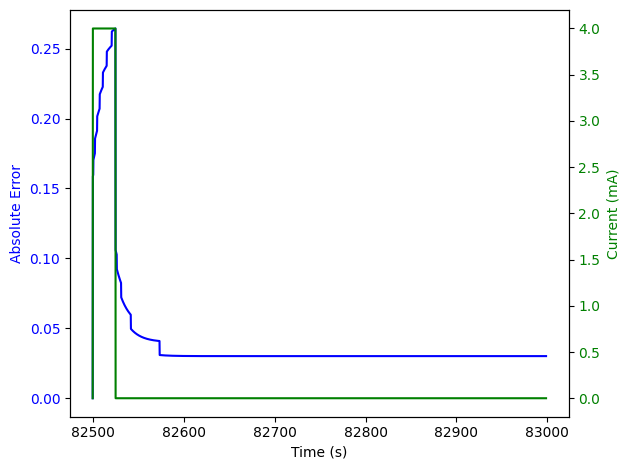

6


Parameters (First Order ECN): 0.01953 0.005470000000000003 3540.219378428079


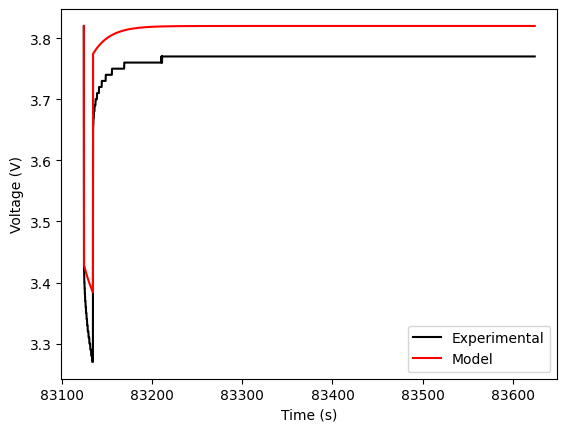

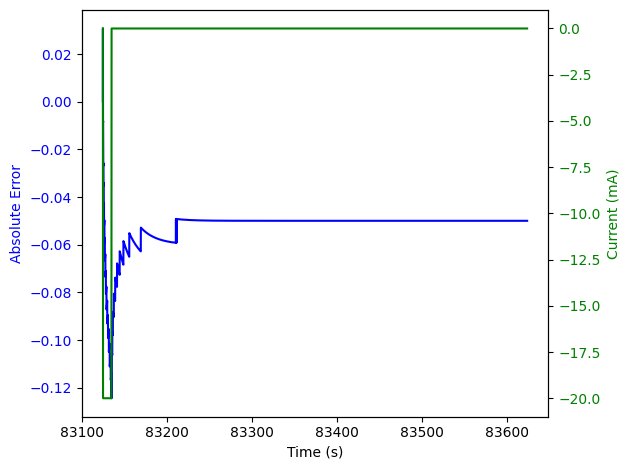

7


Parameters (First Order ECN): 0.01953 0.010470000000000028 727.2206303726243


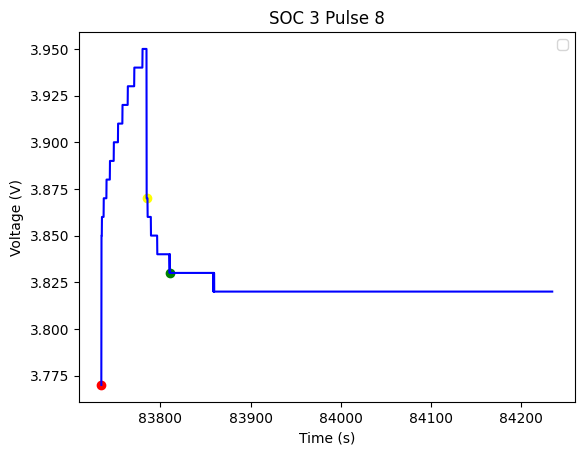

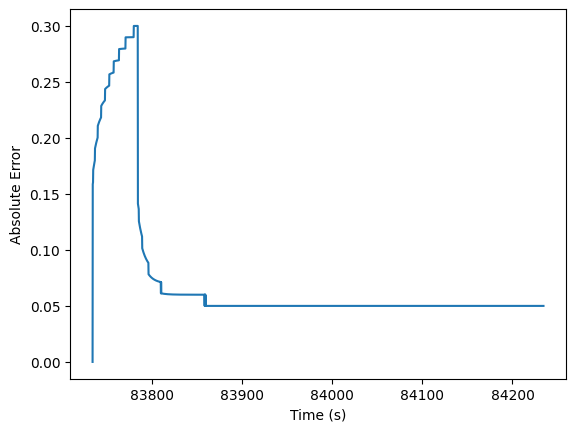

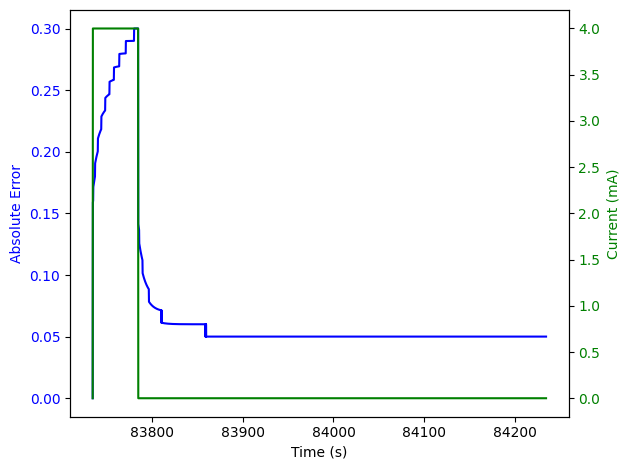

-1


Parameters (First Order ECN): 0.01953 0.21999095808383168 2034.008596978278


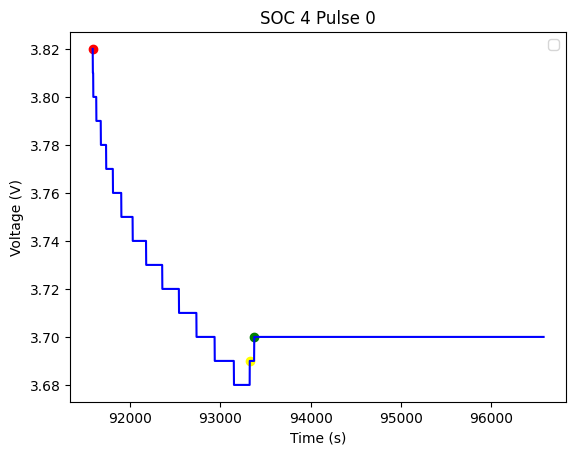

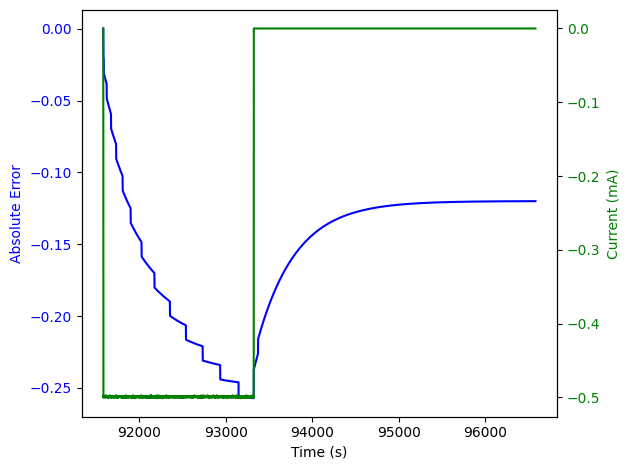

0


Parameters (First Order ECN): 0.01953 0.008470000000000116 724.9114521841008


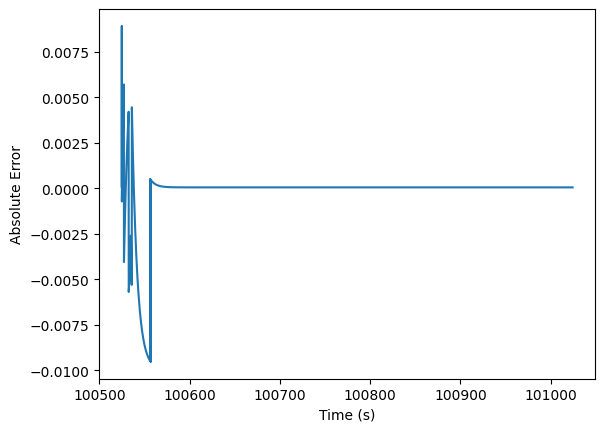

1


Parameters (First Order ECN): 0.01953 0.01247000000000003 1161.9887730551666


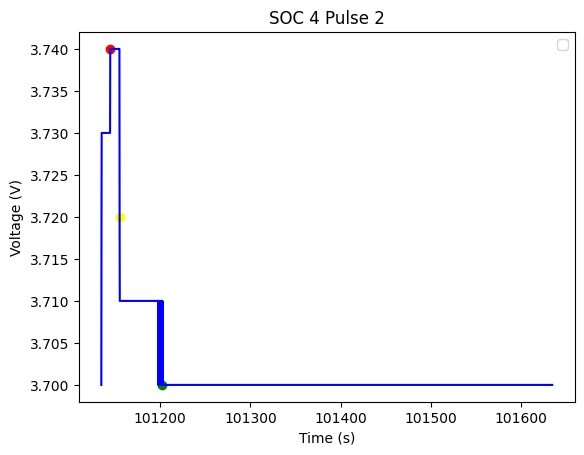

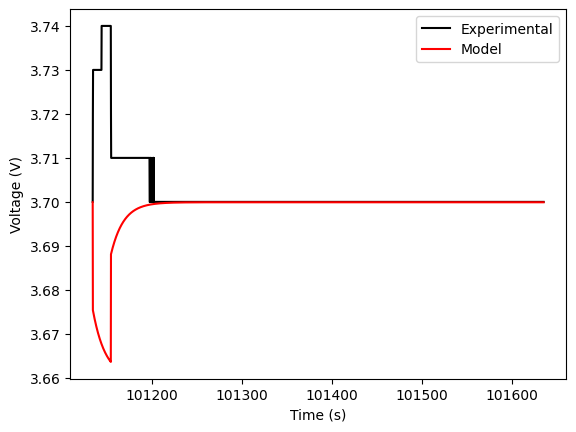

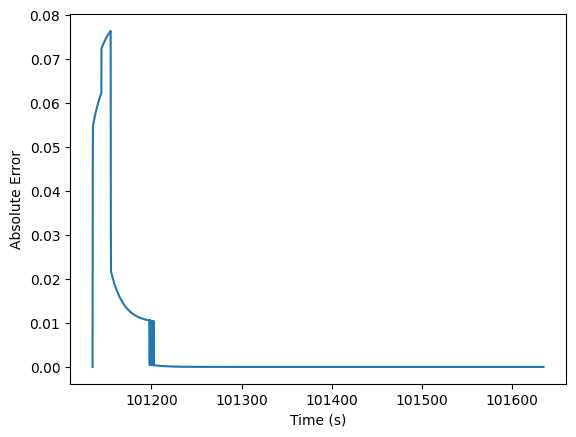

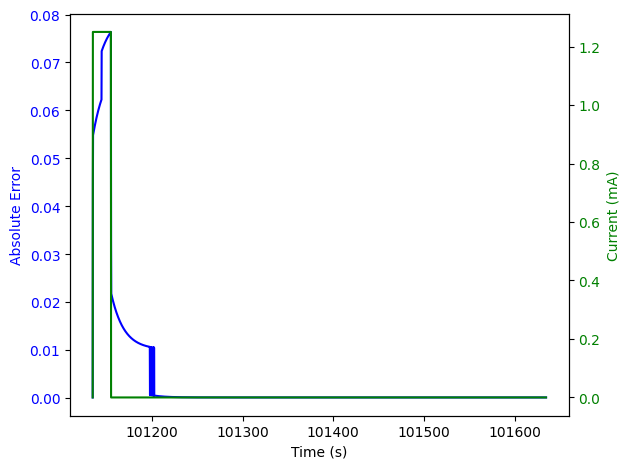

2


Parameters (First Order ECN): 0.01953 0.006469999999999979 585.8578052548946


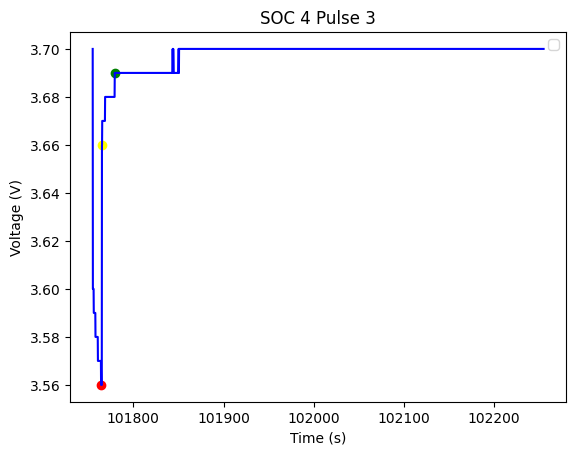

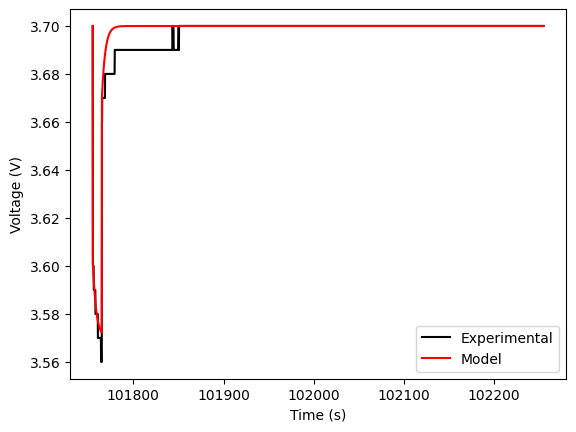

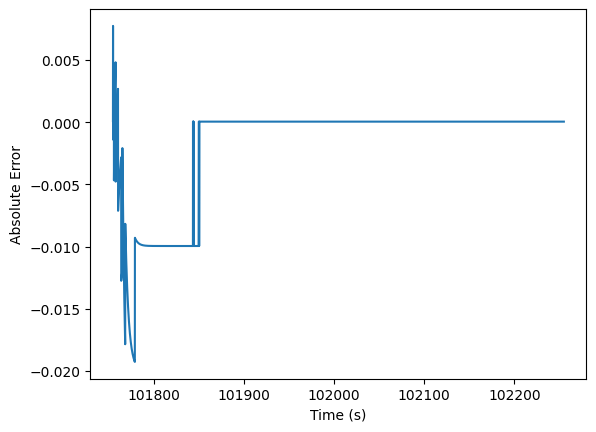

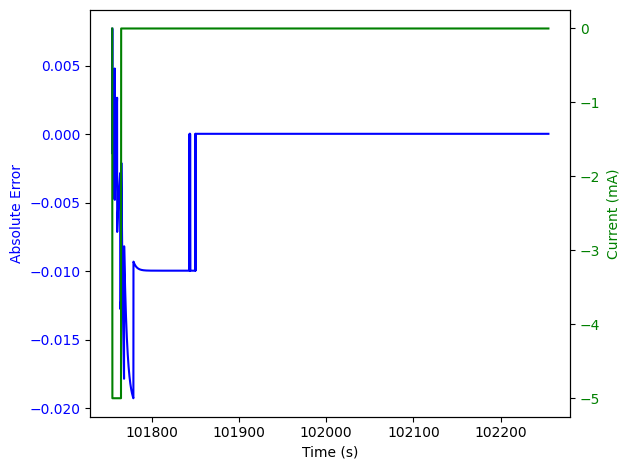

3


Parameters (First Order ECN): 0.01953 0.008469999999999936 376.56434474621386


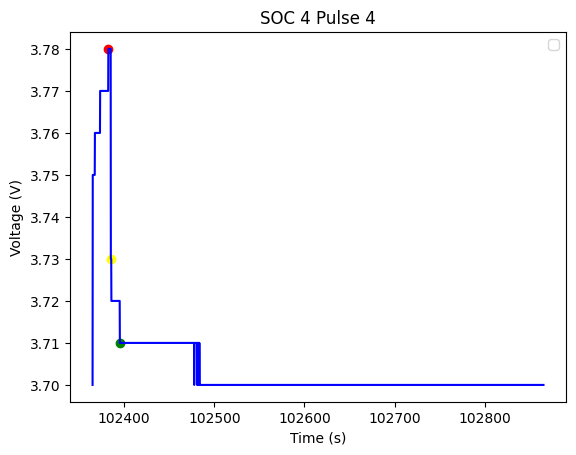

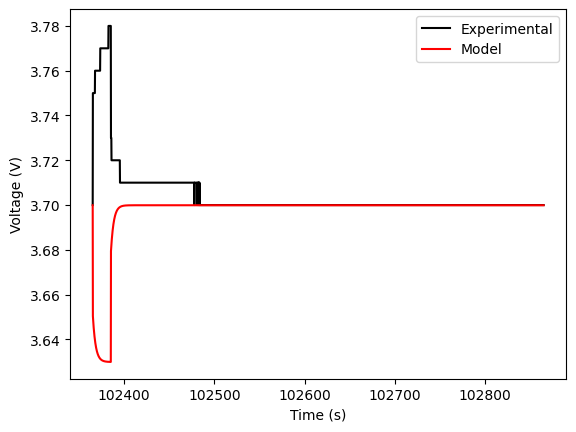

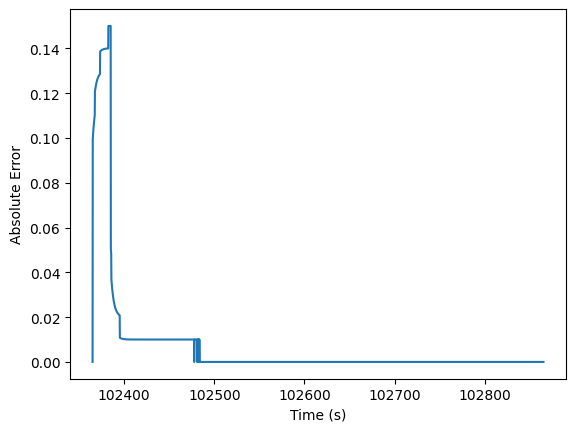

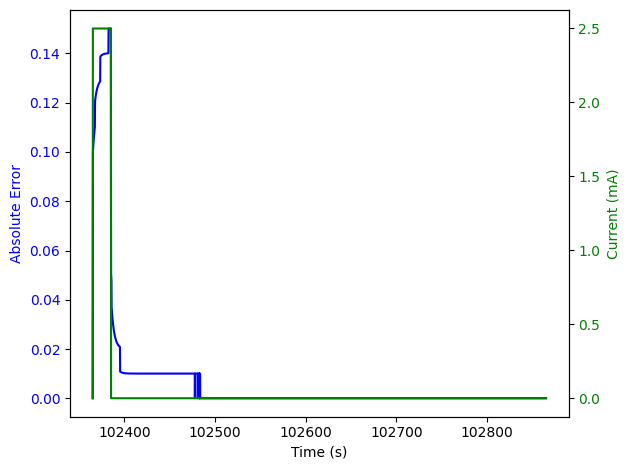

4


Parameters (First Order ECN): 0.01953 0.006469999999999979 1810.5873261202878


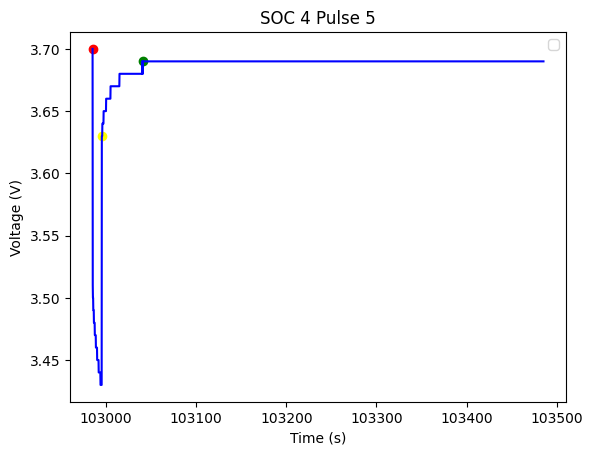

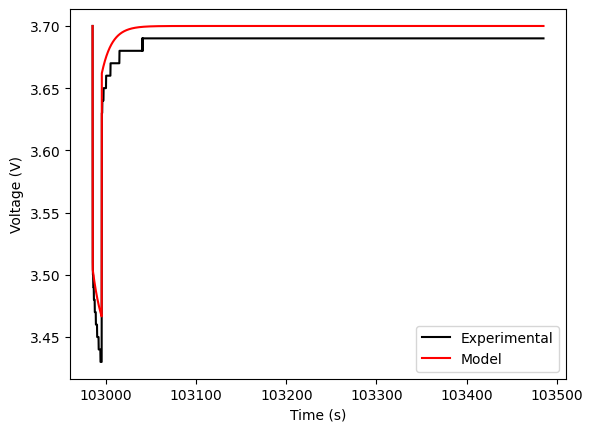

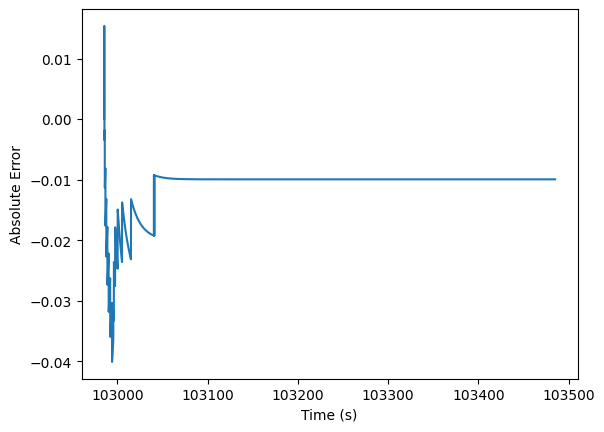

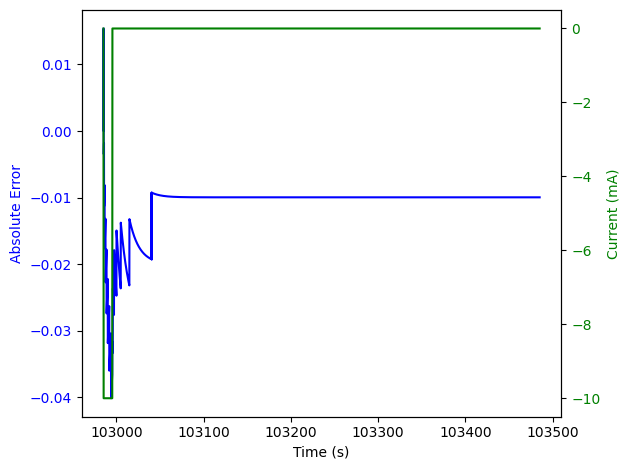

5


Parameters (First Order ECN): 0.01953 0.00796999999999997 996.2986198244217


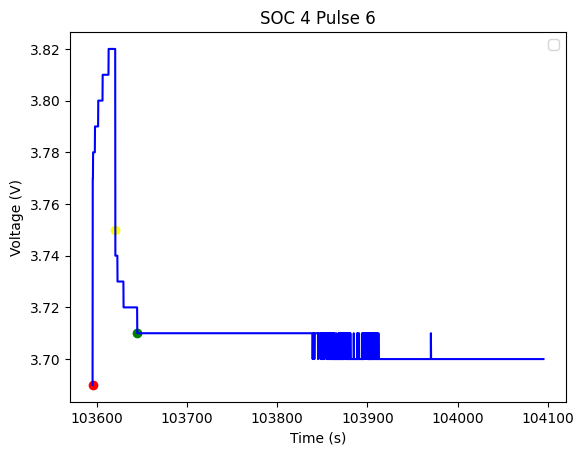

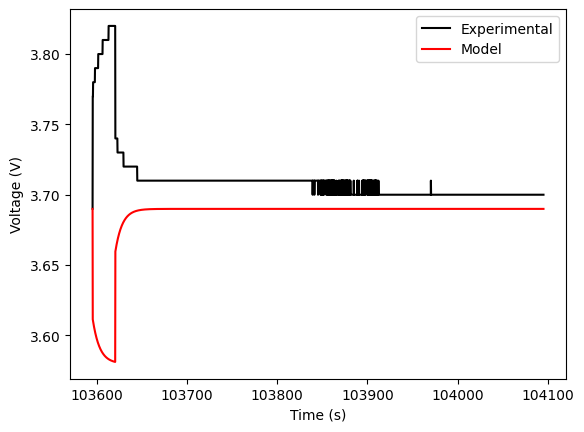

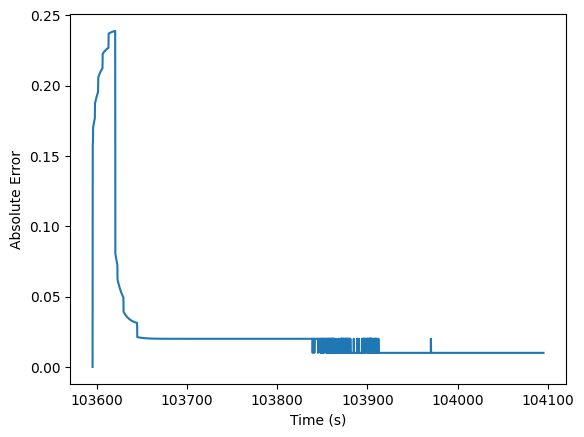

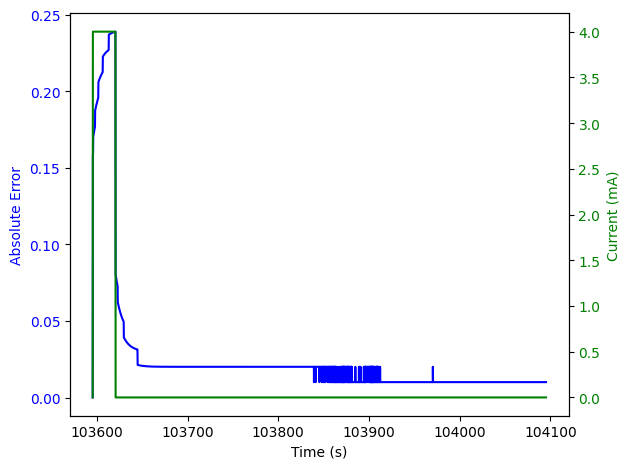

6


Parameters (First Order ECN): 0.01953 0.0059700000000000135 2410.4690117249024


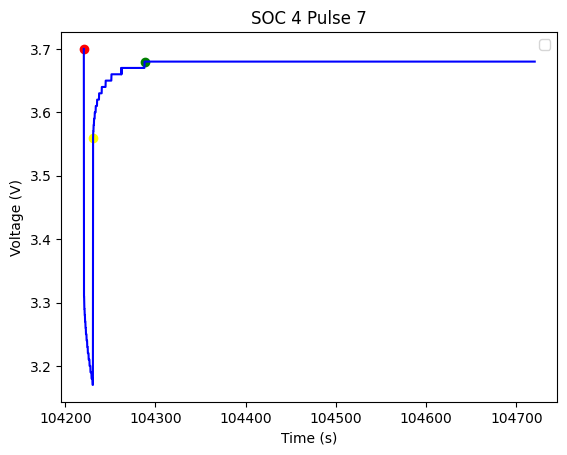

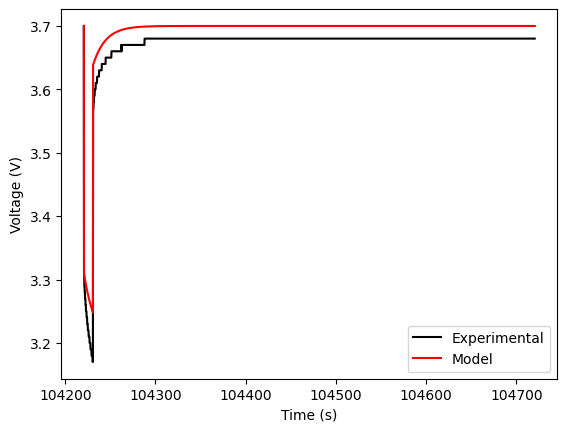

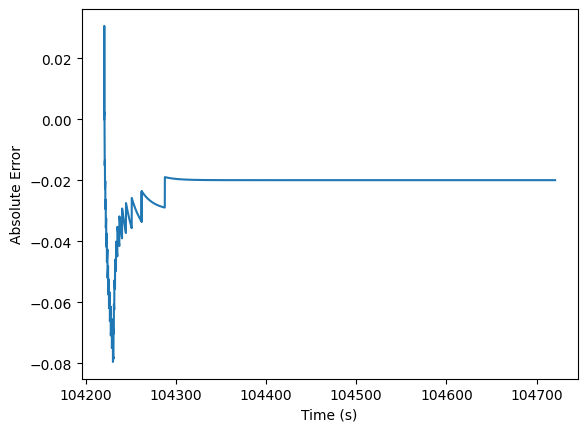

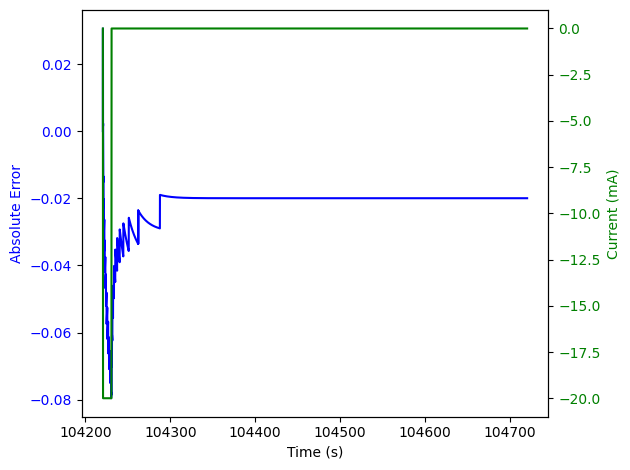

7


Parameters (First Order ECN): 0.01953 0.010470000000000028 1195.2722063038302


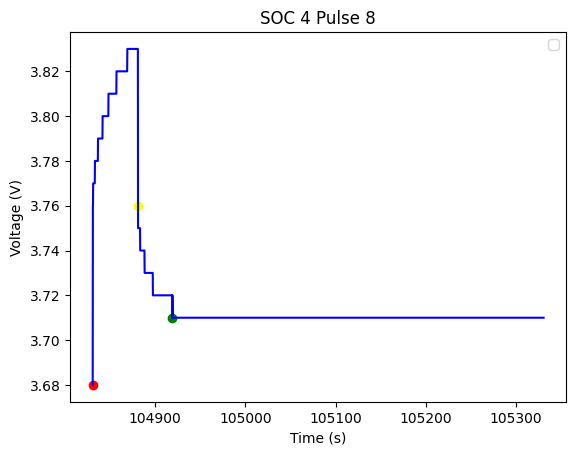

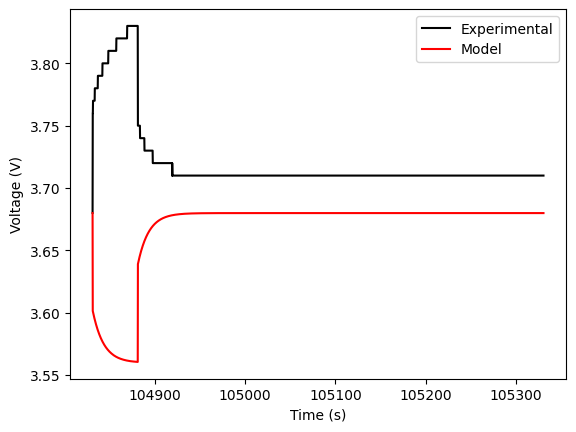

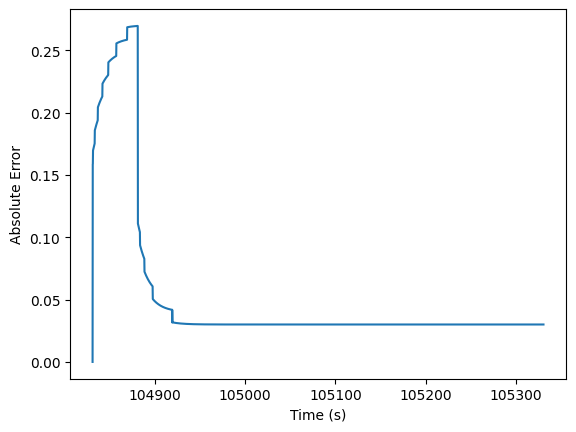

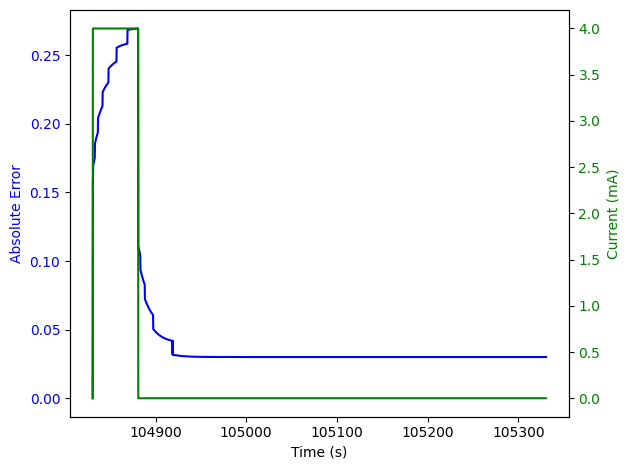

-1


Parameters (First Order ECN): 0.01953 0.14015063872255504 3109.3846875908976


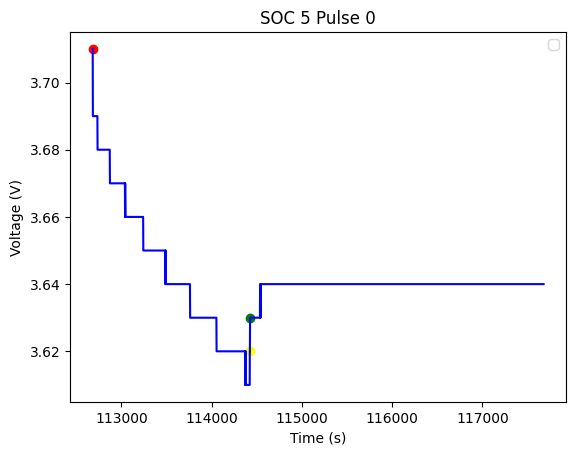

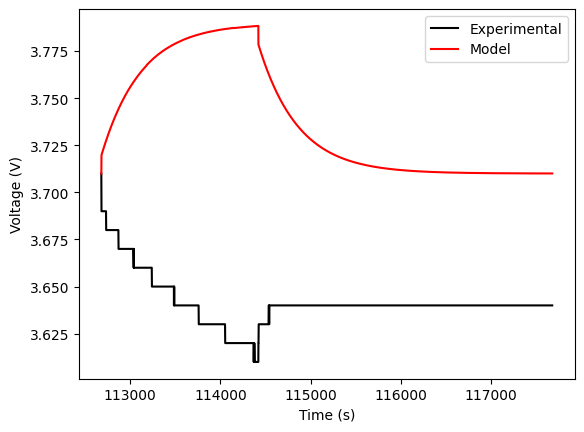

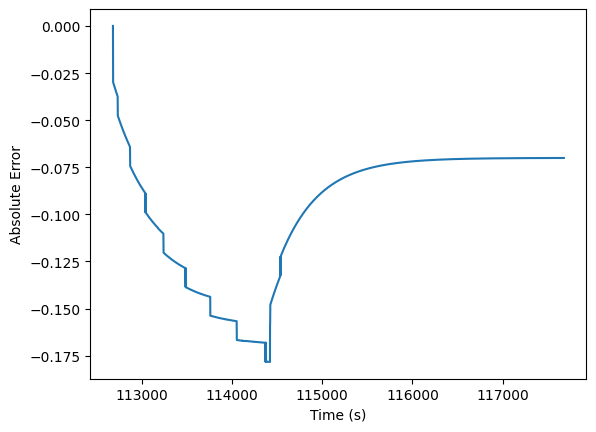

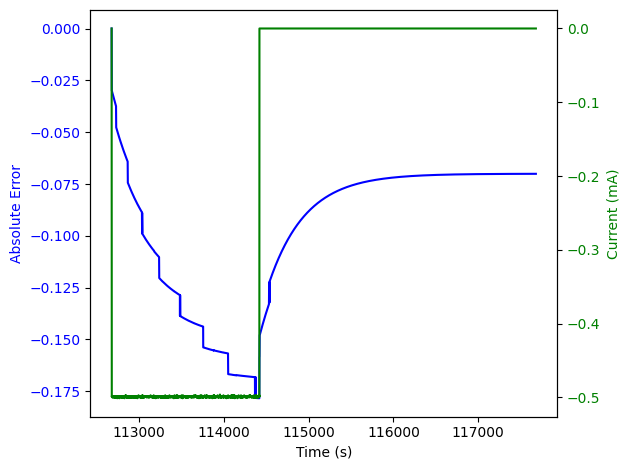

0


Parameters (First Order ECN): 0.01953 0.008470000000000116 482.82172373102793


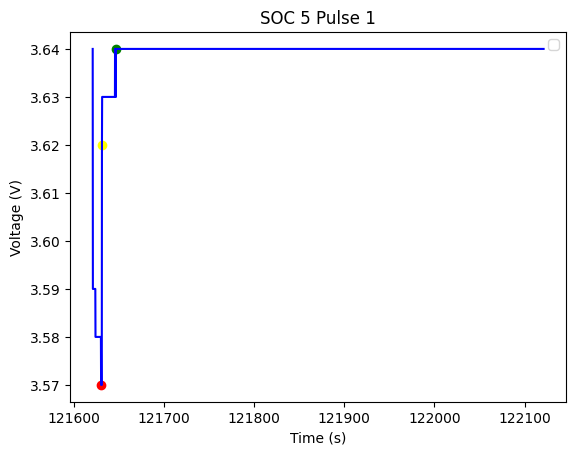

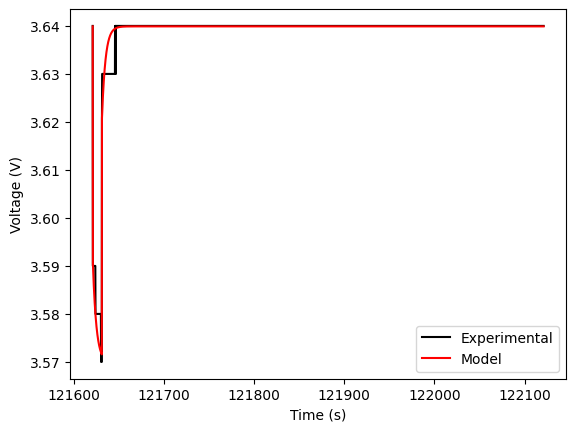

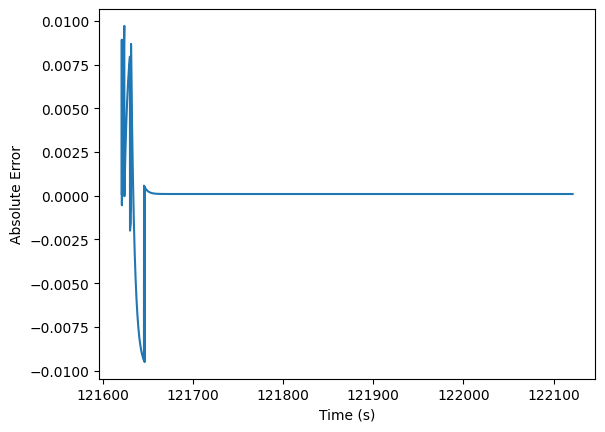

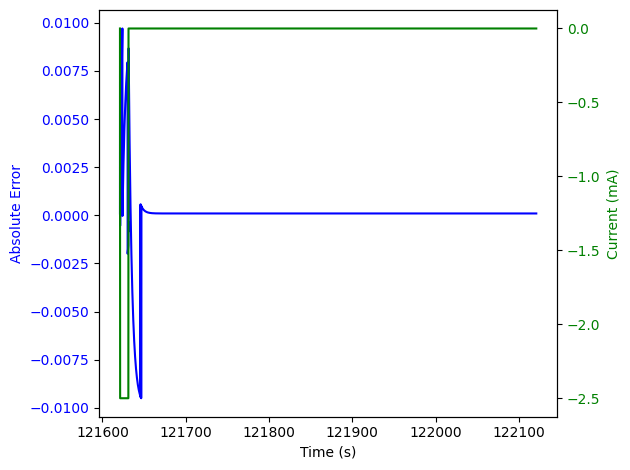

1


Parameters (First Order ECN): 0.01953 0.0044700000000001995 758.1655480990382


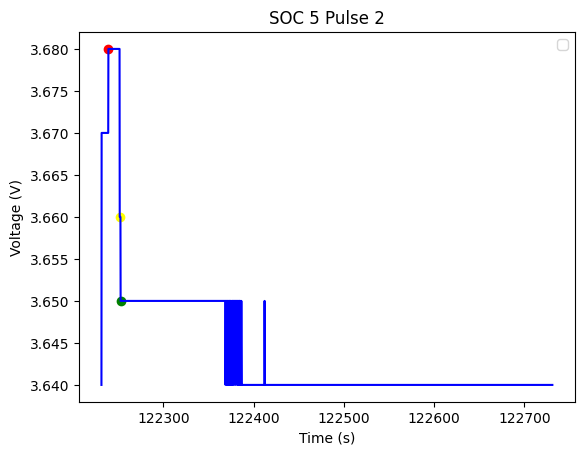

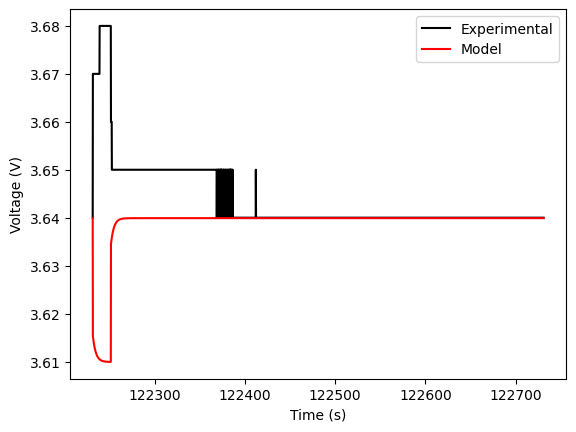

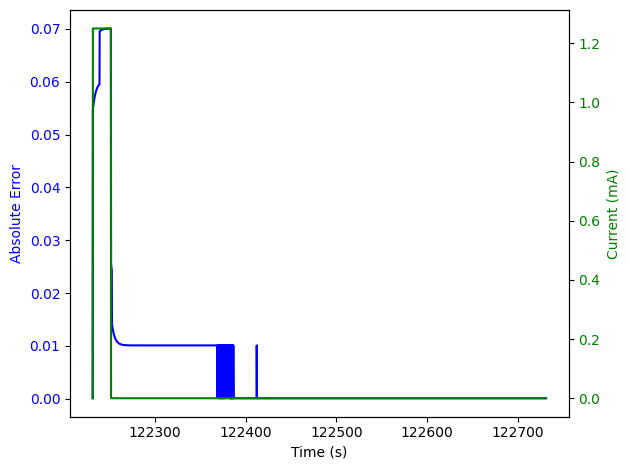

2


Parameters (First Order ECN): 0.01953 0.008470000000000026 1648.642266824073


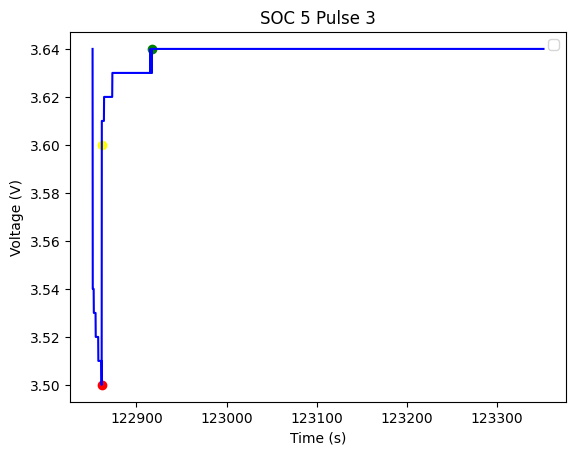

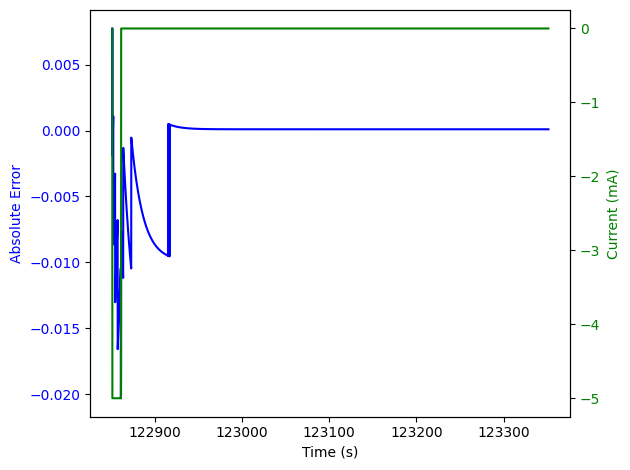

3


Parameters (First Order ECN): 0.01953 0.008470000000000116 532.9988193621529


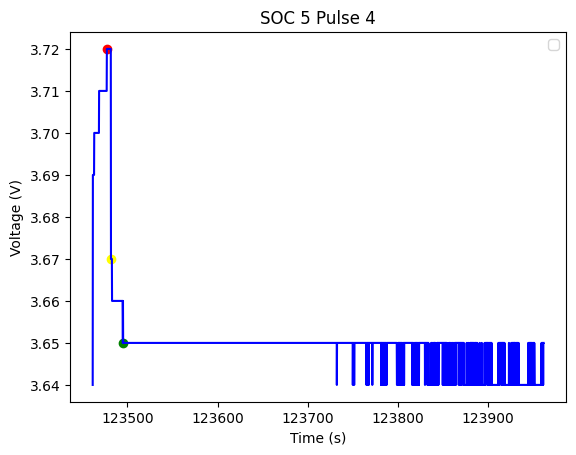

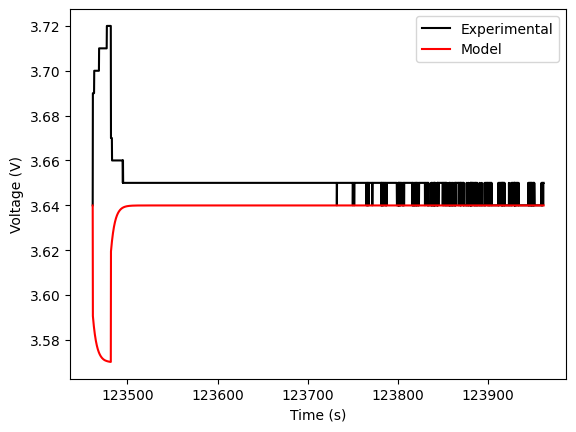

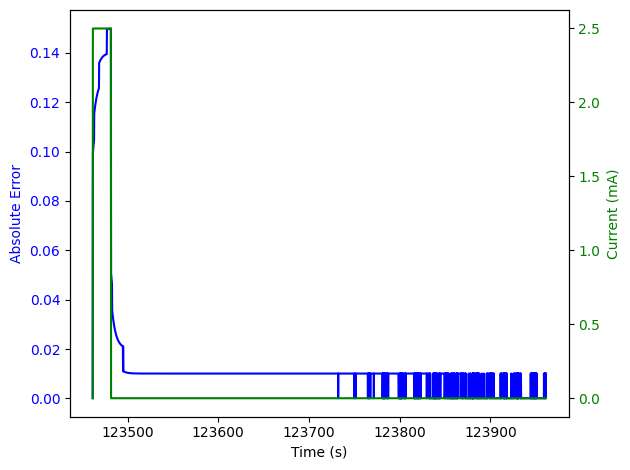

4


Parameters (First Order ECN): 0.01953 0.006469999999999979 1594.2812982996481


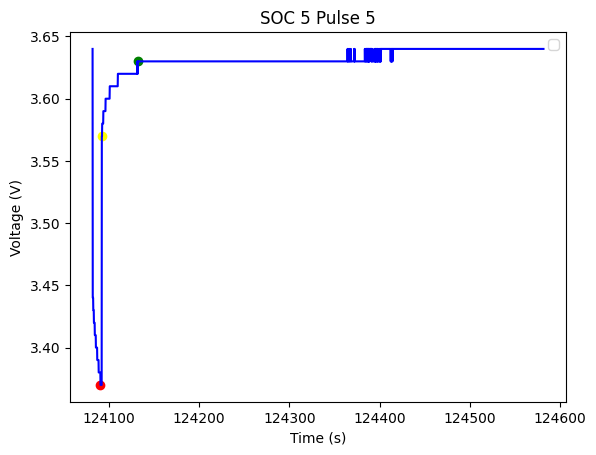

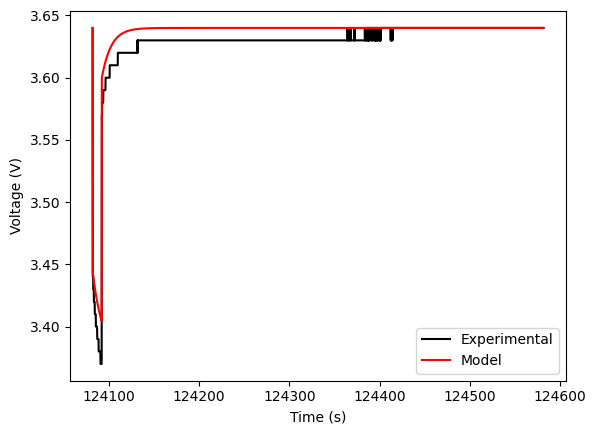

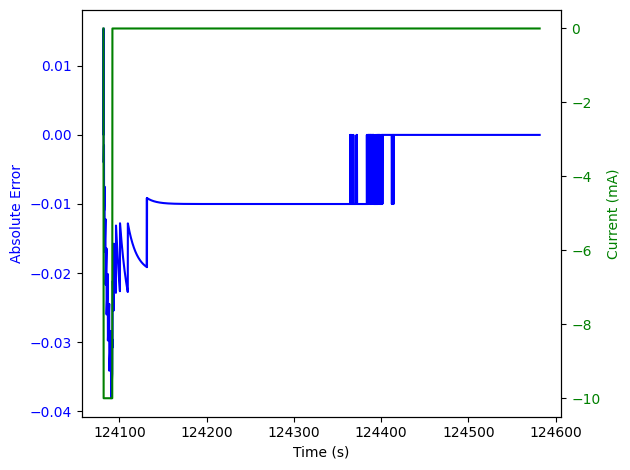

5


Parameters (First Order ECN): 0.01953 0.010470000000000028 739.2550143267985


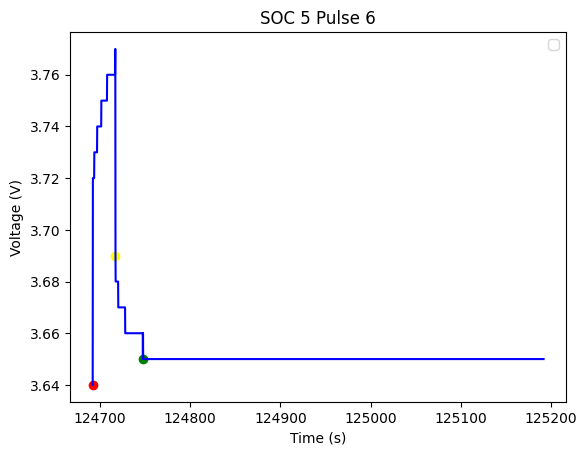

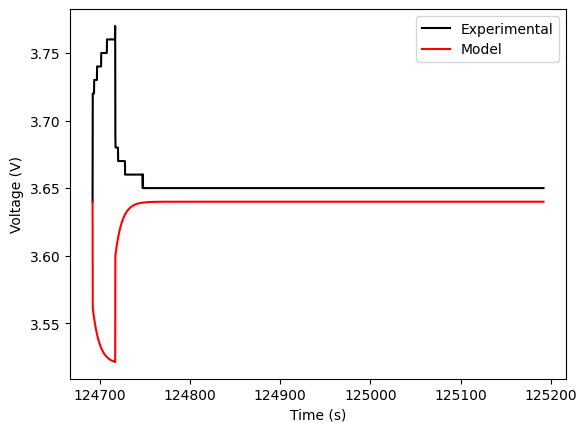

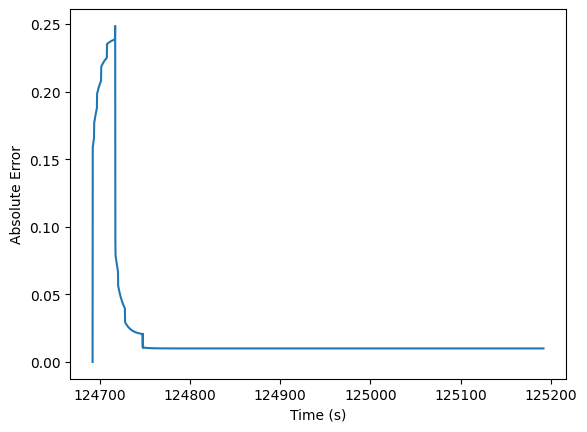

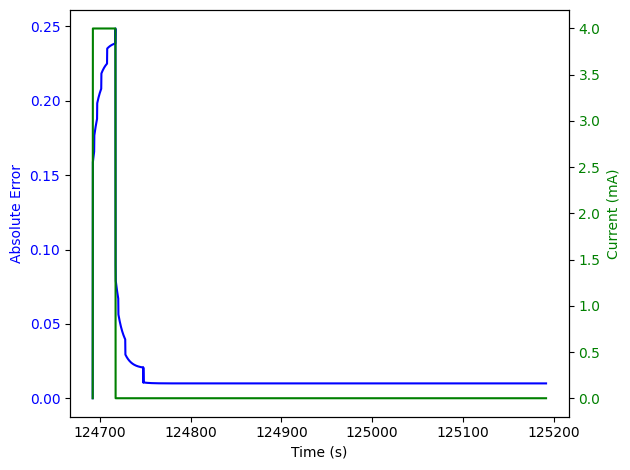

6


Parameters (First Order ECN): 0.01953 0.0059700000000000135 2230.067001675071


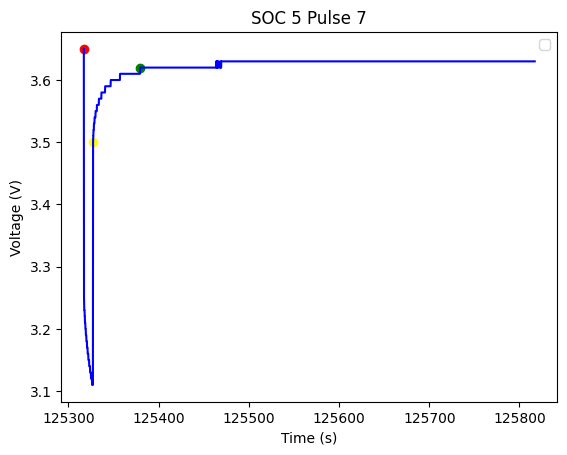

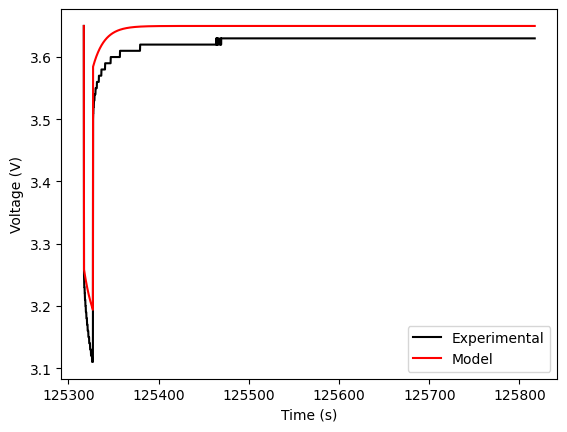

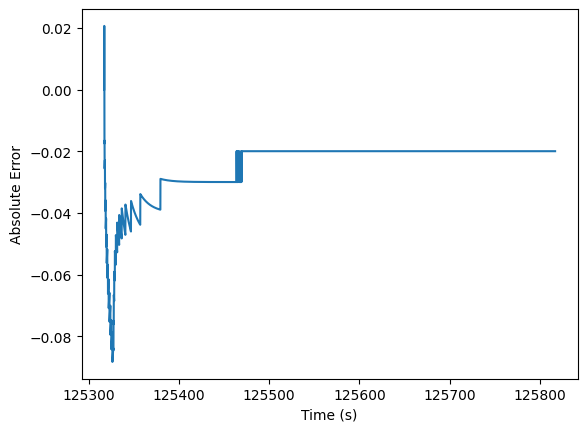

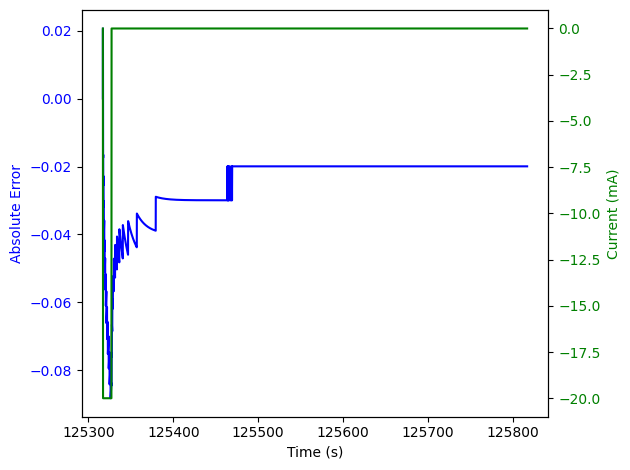

7


Parameters (First Order ECN): 0.01953 0.012969999999999975 1014.9961449498055


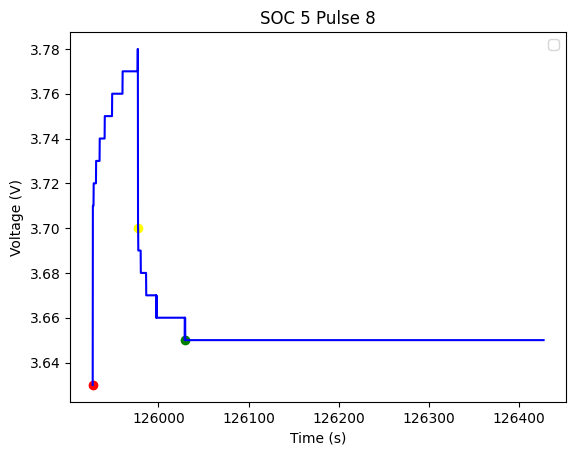

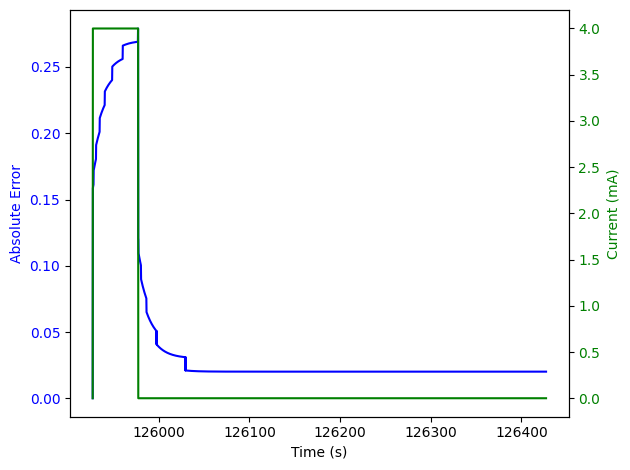

-1


Parameters (First Order ECN): 0.01953 0.1201905588822352 3648.373084192494


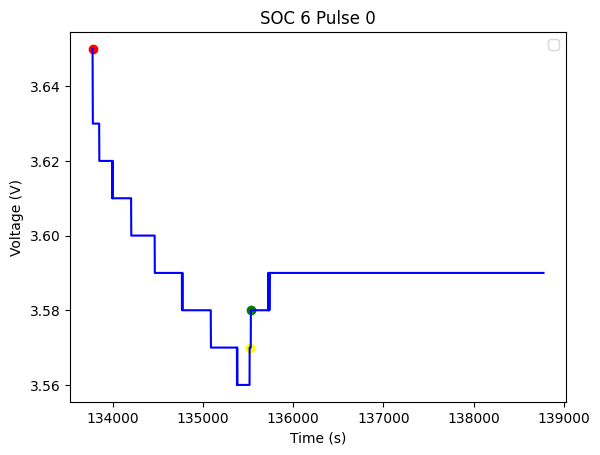

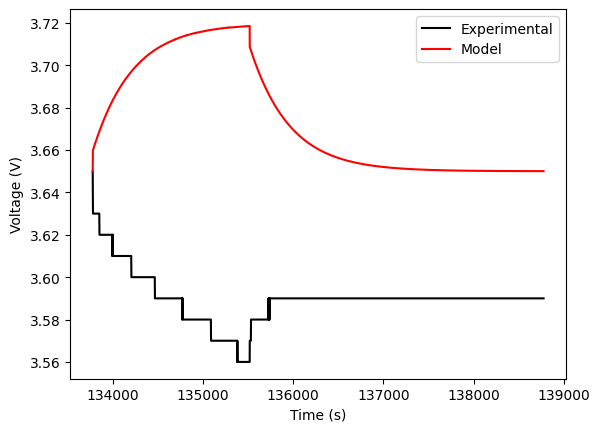

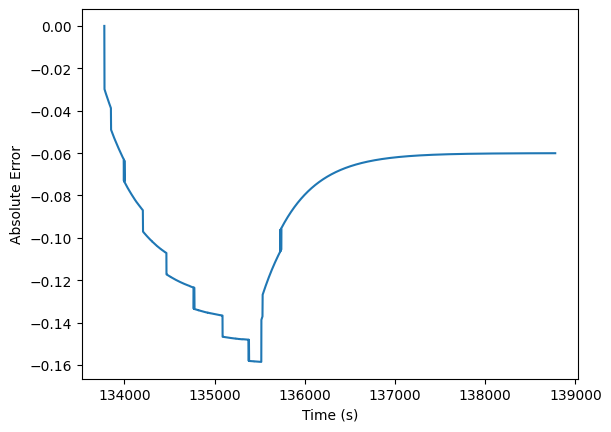

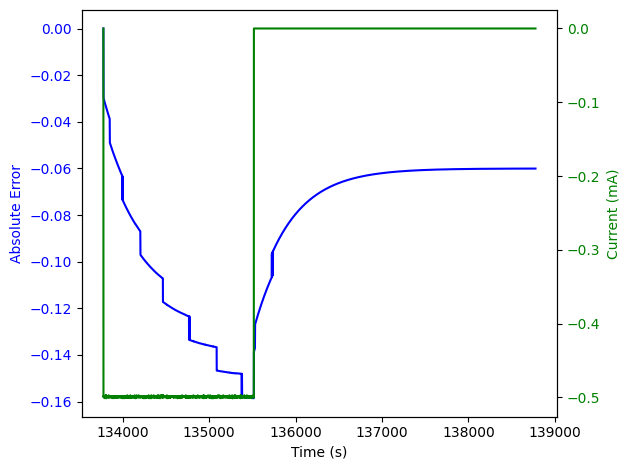

0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import least_squares

def FirstOrderECN(t,R0,R1,C1,I,dt,OCV):
    # Initialize i_R1
    i_R1 = np.zeros(len(t))

    # Simulate i_R1 evolution
    for j in range(1, len(t)):
        i_R1[j] = np.exp(-dt/(R1*C1))*i_R1[j-1] + (1-np.exp(-dt/(R1*C1)))*I[j-1]

    #Calculate cell voltage
    modelvol = OCV-(R1*i_R1)-(R0*I)
    return modelvol

def FitFirstOrderECN(t, I, V, dt, OCV):
    # Objective function to minimize
    def objective_function(t, params, I, V, dt, OCV):
        R0, R1, C1 = params
        predvoltage = FirstOrderECN(t, R0, R1, C1, I, dt, OCV)
        residual = predvoltage - V
        return residual

    # Parameters initial guesses (R0, R1, C1)
    InitialGuess = (1, 1, 1)

    # Define the objective function with fixed dt and OCV
    obj_func = lambda params: objective_function(t, params, I, V, dt, OCV)
    result = least_squares(obj_func, InitialGuess)

    # Extract the optimized parameters
    optimized_params = result.x
    return optimized_params

# Task 1 Model Updated
def ECNModel(npulse, nSOC):

    SOCinddata = SOCind[(nSOC)]
    print(npulse-1)
    SOCinddata = SOCinddata[(npulse)]
    t = SOCinddata[1]
    I = SOCinddata[2]
    V = SOCinddata[3]

    # Read the CSV file with space and tab-separated values
    df_soc = pd.read_csv('SOC_OCV_MFCTT_2019.csv', delimiter='\t')

    # Extract SOC and OCV data
    SOC_raw = df_soc['SOC\tEcell/V'].str.split('\t', expand=True)[0].astype(float).values
    OCV_raw = df_soc['SOC\tEcell/V'].str.split('\t', expand=True)[1].astype(float).values

    dSOC = SOC_raw[0]-SOC_raw[1] # SOC step
    dt = t[1]-t[0] # time step

    # Immediate voltage jump in current pulse application
    # Find the maximum/minimum voltage during the pulse
    V_max = max(V)
    V_min = min(V)

    # Find voltage at the moment when current switched to zero
    for i in range(1, len(I)):
        if I[i] == 0 and I[i-1] != 0:
          V_switch = V[i]
          t_switch = t[i]
          break
        else:
          # If loop doesn't find zero current, use first voltage
          V_switch = V[0]
          t_switch = t[0]

    dv0 = abs(V_max-V_switch) if abs(V_max-V_switch) > abs(V_min-V_switch) else abs(V_min-V_switch)

    # Calculate current difference
    di = abs(max(I)-min(I))
    # Constant R0 based on Part A average across entire experimental range
    R0 = 0.01953

    # Find index corresponding to t_switch
    idx_switch = next(i for i, t_val in enumerate(t) if t_val >= t_switch)

    # Find the index of the first voltage value after the current is switched off
    # Threshold: 30 for 0ºC, 50 for 20ºC, and 20 for 40ºC
    idx_steady_state = None
    steady_state_duration_threshold = 50
    for i in range(idx_switch, len(V)-1):
        if all(abs(V[j] - V[j+1]) < 0.001 for j in range(i, min(i + int(steady_state_duration_threshold / dt), len(V)-1))):
        #if abs(V[i] - V[i+1]) < 0.001:
            idx_steady_state = i
            break
    if idx_steady_state is not None:
        V_steady_state = V[idx_steady_state]
    else:
        # Handle the case where steady state is not found
        V_steady_state = None

    dvinf = abs(V_steady_state-V_max) if abs(V_steady_state-V_max) > abs(V_steady_state-V_min) else abs(V_steady_state-V_min)
    R1 = (dvinf / di) - R0

    # Time to settle after pulse application
    Vmax = V[V==V_max]
    tmax = t[V==Vmax[0]]
    Vmin = V[V==V_min]
    tmin = t[V==Vmin[0]]
    dt_steady_state = t[idx_steady_state]-tmax[0] if abs(V_steady_state-V_max) > abs(V_steady_state-V_min) else t[idx_steady_state]-tmin[0]
    C1 = dt_steady_state / (4 * R1)

    Parameters = [R0,R1,C1]

    plt.figure()
    plt.plot(t, V, color='blue')
    plt.scatter(t_switch, V_switch, color='yellow')
    if len(V[V==V_max])<len(V[V==V_min]):
      plt.scatter(tmax[0], V_max, color='red')
    else:
      plt.scatter(tmin[0], V_min, color='red')
    plt.scatter(t[idx_steady_state], V_steady_state, color='green')
    plt.title(f'SOC {nSOC} Pulse {npulse}')
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)')
    plt.legend()

    print("Parameters (First Order ECN):", R0, R1, C1)

    Qn = 2500 # nominal capacity in mAh

    SOC = np.zeros(np.shape(t)) # SOC at each time step in discharge

    # calculating initial SOC - will match OCV due to long hold
    found = 0
    i = 0
    while not found:
        if V[0] > OCV_raw[i]:
            if abs(V[0] - OCV_raw[i]) < abs(V[0] - OCV_raw[i-1]):
                SOC[0] = SOC_raw[i]
            else:
                SOC[0] = SOC_raw[i-1]
            found = 1
        else:
            i += 1

    for j in range(1,len(t)):
        SOC[j] = SOC[j-1] - 100*(I[j]*dt/3600)/Qn # SOC as percentage

    SOC_ind = ((SOC_raw[0]-SOC)/dSOC-3).astype(int) # array with index corresponding to current SOC value
    OCV = OCV_raw[SOC_ind] # OCV at each time step in discharge

    # Calculate model voltage
    V_model = FirstOrderECN(t, R0, R1, C1, I, dt, OCV) if abs(V_steady_state-V_max) > abs(V_steady_state-V_min) else FirstOrderECN(t, -R0, -R1, -C1, I, dt, OCV)

    fig, ax = plt.subplots()
    plt.plot(t,V,'k')
    plt.plot(t,V_model,'r')
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)')
    plt.legend(['Experimental','Model'])
    plt.show()

    err = V-V_model # Error between experimental and model voltage
    plt.plot(t,err)
    plt.xlabel('Time (s)')
    plt.ylabel('Absolute Error')
    plt.show()

    # Overlaying current
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Absolute Error', c='b')
    ax1.plot(t,err,'b')
    ax1.tick_params(axis='y', labelcolor='b')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Current (mA)', c='g')
    ax2.plot(t,I,'g')
    ax2.tick_params(axis='y', labelcolor='g')

    fig.tight_layout()
    plt.show()

    return Parameters

AllSOCParam = []
AverageParam = []
for i, pulses in enumerate(SOCpulseintervals):
  for j in enumerate(pulses):
    Parameters = ECNModel(j[0],i)
    AllSOCParam.append([Parameters])
print(AllSOCParam)

**Part E: R0 As Function of Current at 60% SOC**

Parameters (First Order ECN): 0.020000000000000108 0.008000000000000007 767.4999999999266


Parameters (First Order ECN): 0.016000000000000014 0.016000000000000014 905.6249999998719


Parameters (First Order ECN): 0.020000000000000018 0.00599999999999996 631.7499999998636


Parameters (First Order ECN): 0.019999999999999928 0.008000000000000007 398.6875000000506


Parameters (First Order ECN): 0.019999999999999973 0.006000000000000005 1952.416666666369


Parameters (First Order ECN): 0.01749999999999996 0.010000000000000009 794.0500000000604


Parameters (First Order ECN): 0.019500000000000007 0.006000000000000005 2398.4166666662813


Parameters (First Order ECN): 0.019999999999999907 0.01000000000000012 1251.4500000000985


Parameters (First Order ECN): 0.020000000000000108 0.008000000000000007 767.4999999999266
[0.020000000000000108, 0.008000000000000007, 767.4999999999266]


Parameters (First Order ECN): 0.016000000000000014 0.016000000000000014 905.6249999998719
[0.016000000000000014, 0.016000000000000014, 905.6249999998719]


Parameters (First Order ECN): 0.020000000000000018 0.00599999999999996 631.7499999998636
[0.020000000000000018, 0.00599999999999996, 631.7499999998636]


Parameters (First Order ECN): 0.019999999999999928 0.008000000000000007 398.6875000000506
[0.019999999999999928, 0.008000000000000007, 398.6875000000506]


Parameters (First Order ECN): 0.019999999999999973 0.006000000000000005 1952.416666666369
[0.019999999999999973, 0.006000000000000005, 1952.416666666369]


Parameters (First Order ECN): 0.01749999999999996 0.010000000000000009 794.0500000000604
[0.01749999999999996, 0.010000000000000009, 794.0500000000604]


Parameters (First Order ECN): 0.019500000000000007 0.006000000000000005 2398.4166666662813
[0.019500000000000007, 0.006000000000000005, 2398.4166666662813]


Parameters (First Order ECN): 0.019999999999999907 0.01000000000000012 1251.4500000000985
[0.019999999999999907, 0.01000000000000012, 1251.4500000000985]


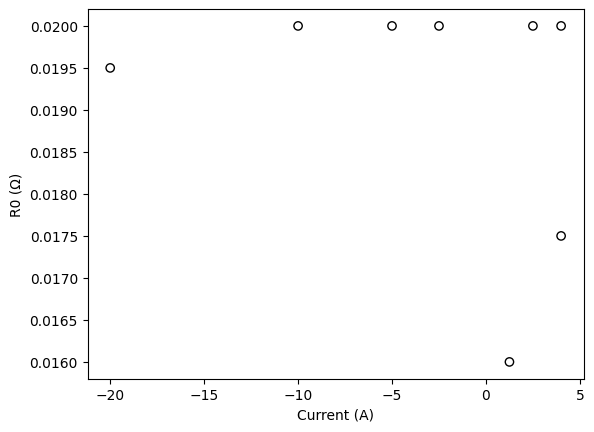

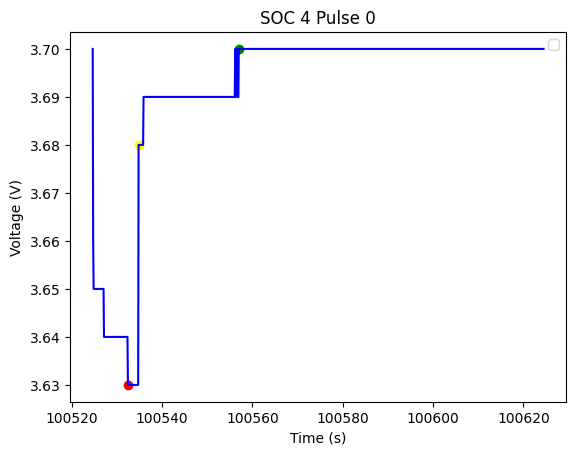

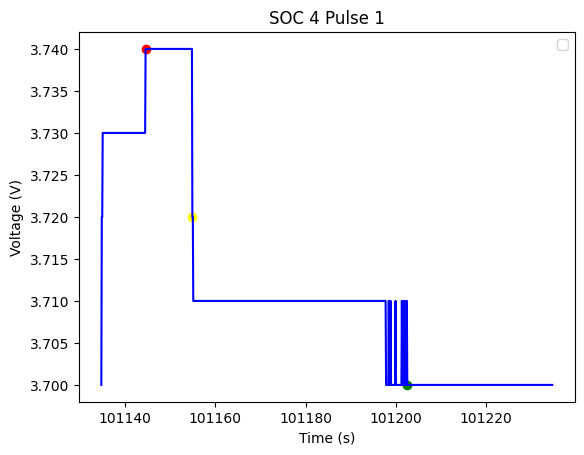

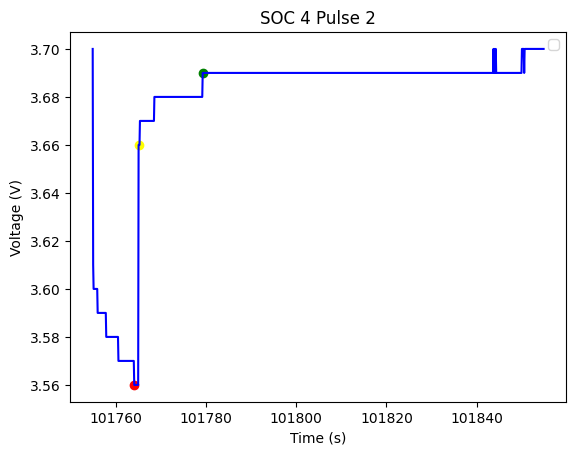

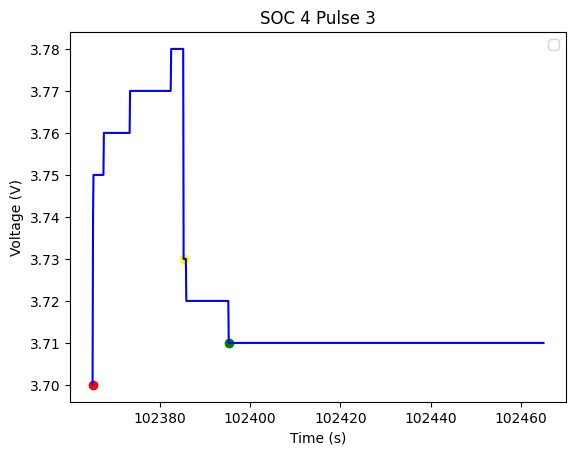

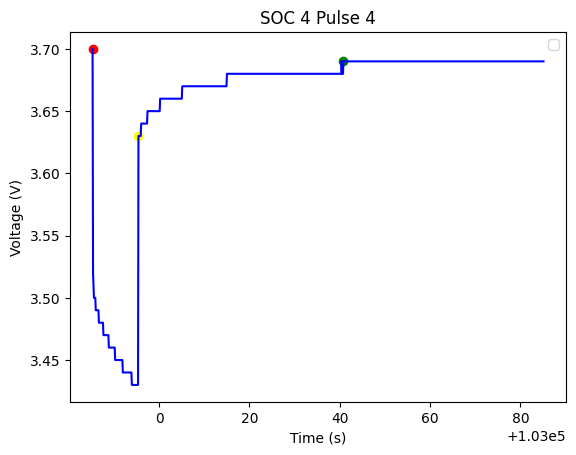

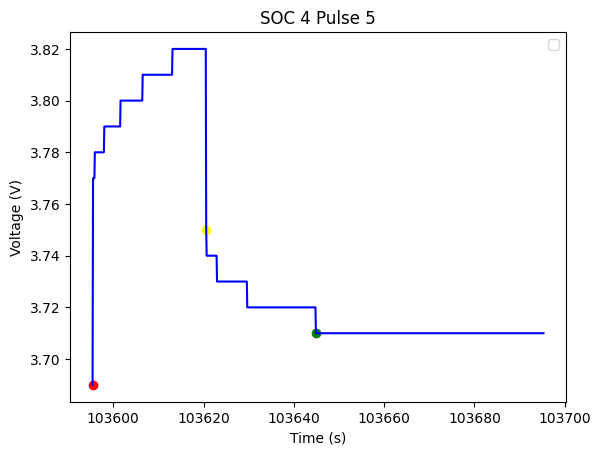

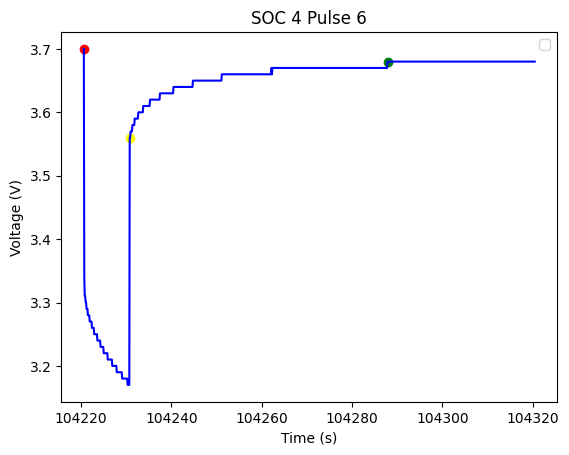

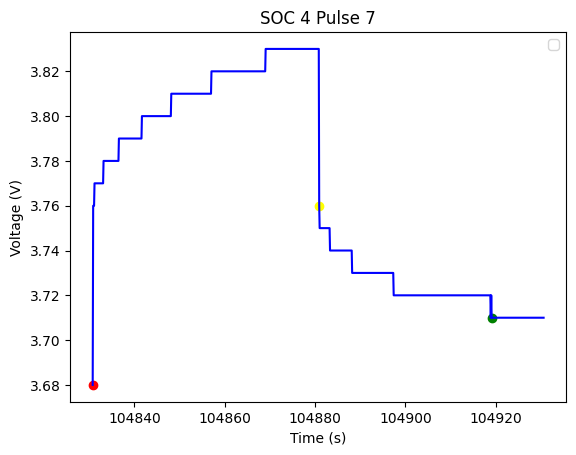

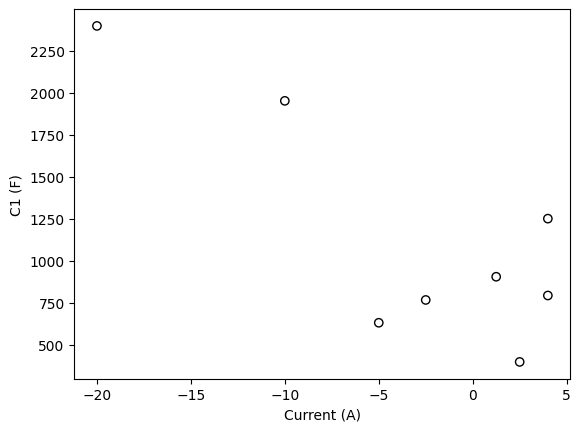

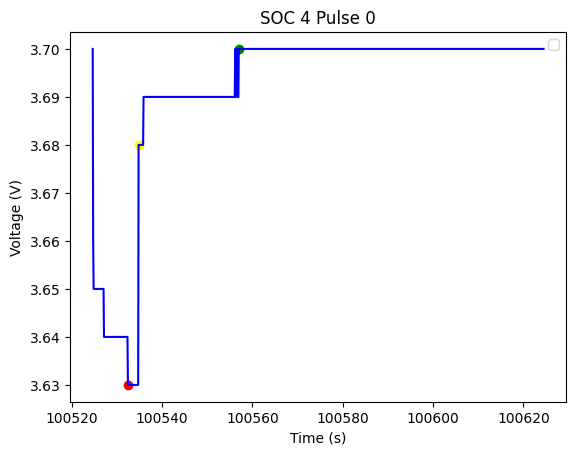

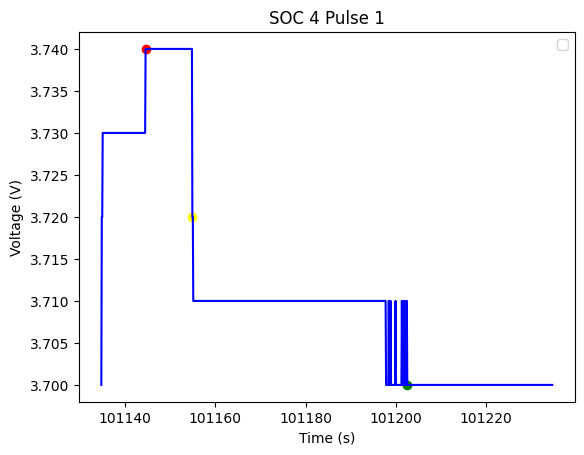

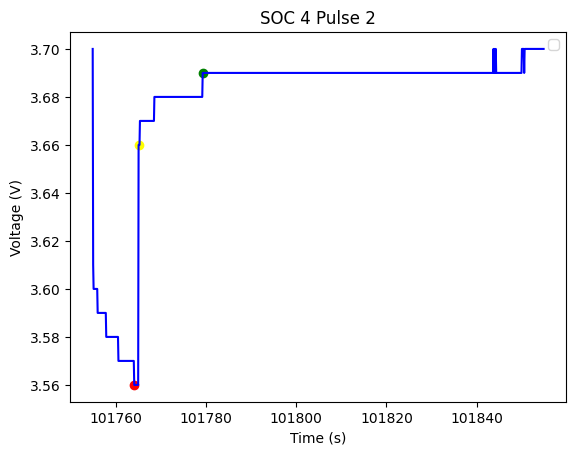

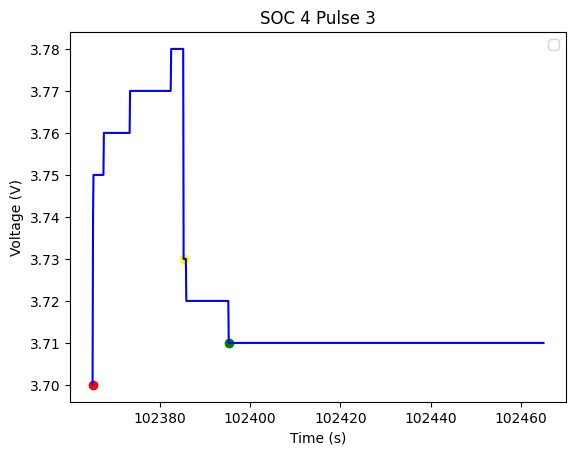

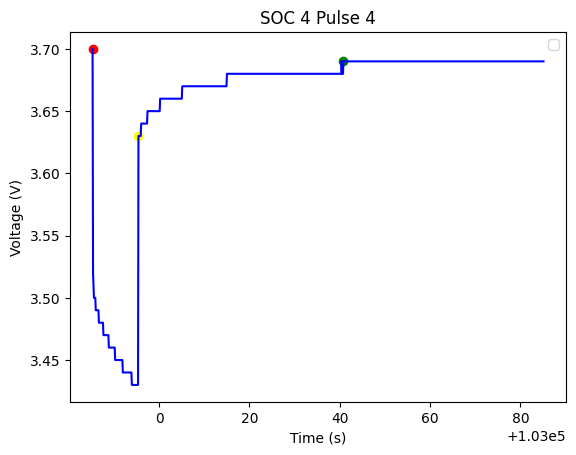

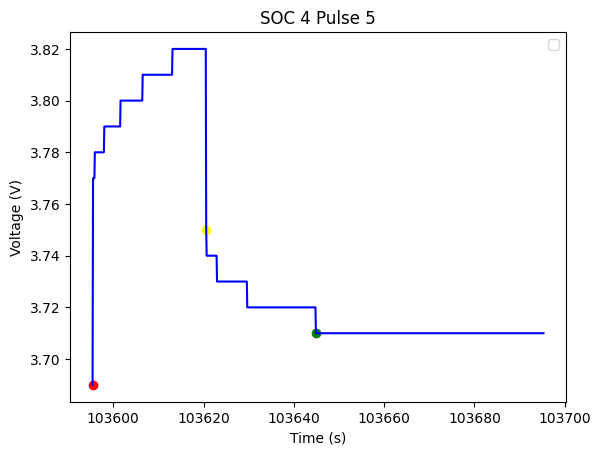

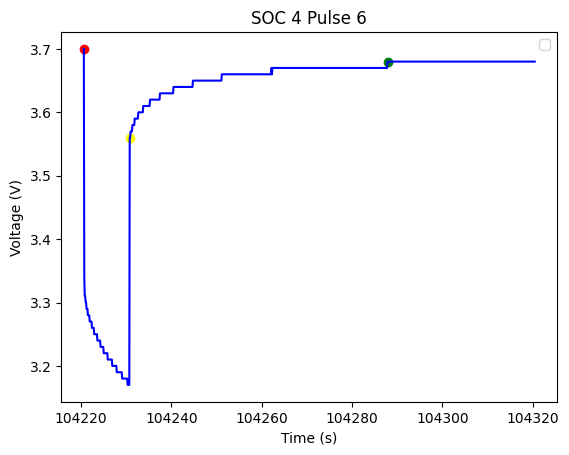

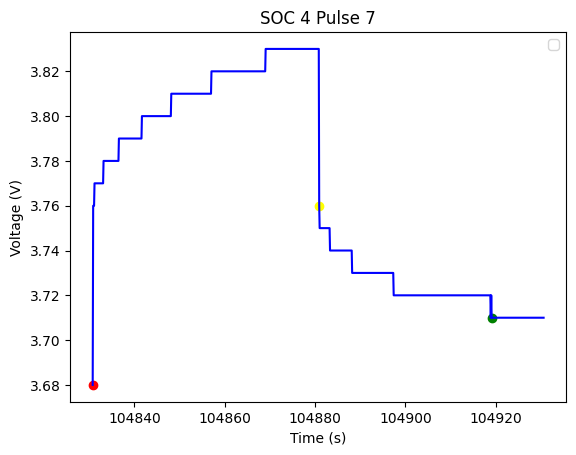

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import least_squares

def FirstOrderECN(t,R0,R1,C1,I,dt,OCV):
    # Initialize i_R1
    i_R1 = np.zeros(len(t))

    # Simulate i_R1 evolution
    for j in range(1, len(t)):
        i_R1[j] = np.exp(-dt/(R1*C1))*i_R1[j-1] + (1-np.exp(-dt/(R1*C1)))*I[j-1]

    #Calculate cell voltage
    modelvol = OCV-(R1*i_R1)-(R0*I)
    return modelvol

def FitFirstOrderECN(t, I, V, dt, OCV):
    # Objective function to minimize
    def objective_function(t, params, I, V, dt, OCV):
        R0, R1, C1 = params
        predvoltage = FirstOrderECN(t, R0, R1, C1, I, dt, OCV)
        residual = predvoltage - V
        return residual

    # Parameters initial guesses (R0, R1, C1)
    InitialGuess = (1, 1, 1)

    # Define the objective function with fixed dt and OCV
    obj_func = lambda params: objective_function(t, params, I, V, dt, OCV)
    result = least_squares(obj_func, InitialGuess)

    # Extract the optimized parameters
    optimized_params = result.x
    return optimized_params

# Task 1 Model Updated
def ECNModel(npulse, nSOC):

    SOCinddata = SOCind[(nSOC)]
    SOCinddata = SOCinddata[(npulse)]
    t = SOCinddata[1]
    I = SOCinddata[2]
    V = SOCinddata[3]

    # Read the CSV file with space and tab-separated values
    df_soc = pd.read_csv('SOC_OCV_MFCTT_2019.csv', delimiter='\t')

    # Extract SOC and OCV data
    SOC_raw = df_soc['SOC\tEcell/V'].str.split('\t', expand=True)[0].astype(float).values
    OCV_raw = df_soc['SOC\tEcell/V'].str.split('\t', expand=True)[1].astype(float).values

    dSOC = SOC_raw[0]-SOC_raw[1] # SOC step
    dt = t[1]-t[0] # time step

    # Immediate voltage jump in current pulse application
    # Find the maximum/minimum voltage during the pulse
    V_max = max(V)
    V_min = min(V)

    # Find voltage at the moment when current switched to zero
    for i in range(1, len(I)):
        if I[i] == 0 and I[i-1] != 0:
          V_switch = V[i]
          t_switch = t[i]
          break
        else:
          # If loop doesn't find zero current, use first voltage
          V_switch = V[0]
          t_switch = t[0]

    dv0 = abs(V_max-V_switch) if abs(V_max-V_switch) > abs(V_min-V_switch) else abs(V_min-V_switch)

    # Calculate current difference
    di = abs(max(I)-min(I))
    R0 = dv0 / di

    # Find index corresponding to t_switch
    idx_switch = next(i for i, t_val in enumerate(t) if t_val >= t_switch)

    # Find the index of the first voltage value after the current is switched off
    # Threshold: 30 for 0ºC, 50 for 20ºC, and 20 for 40ºC
    idx_steady_state = None
    steady_state_duration_threshold = 50
    for i in range(idx_switch, len(V)-1):
        if all(abs(V[j] - V[j+1]) < 0.001 for j in range(i, min(i + int(steady_state_duration_threshold / dt), len(V)-1))):
        #if abs(V[i] - V[i+1]) < 0.001:
            idx_steady_state = i
            break
    if idx_steady_state is not None:
        V_steady_state = V[idx_steady_state]
    else:
        # Handle the case where steady state is not found
        V_steady_state = None

    dvinf = abs(V_steady_state-V_max) if abs(V_steady_state-V_max) > abs(V_steady_state-V_min) else abs(V_steady_state-V_min)
    R1 = (dvinf / di) - R0

    # Time to settle after pulse application
    Vmax = V[V==V_max]
    tmax = t[V==Vmax[0]]
    Vmin = V[V==V_min]
    tmin = t[V==Vmin[0]]
    dt_steady_state = t[idx_steady_state]-tmax[0] if abs(V_steady_state-V_max) > abs(V_steady_state-V_min) else t[idx_steady_state]-tmin[0]
    C1 = dt_steady_state / (4 * R1)

    Parameters = [R0,R1,C1]

    plt.figure()
    plt.plot(t, V, color='blue')
    plt.scatter(t_switch, V_switch, color='yellow')
    if len(V[V==V_max])<len(V[V==V_min]):
      plt.scatter(tmax[0], V_max, color='red')
    else:
      plt.scatter(tmin[0], V_min, color='red')
    plt.scatter(t[idx_steady_state], V_steady_state, color='green')
    plt.title(f'SOC {nSOC} Pulse {npulse}')
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)')
    plt.legend()

    print("Parameters (First Order ECN):", R0, R1, C1)

    Qn = 2500 # nominal capacity in mAh

    SOC = np.zeros(np.shape(t)) # SOC at each time step in discharge

    # calculating initial SOC - will match OCV due to long hold
    found = 0
    i = 0
    while not found:
        if V[0] > OCV_raw[i]:
            if abs(V[0] - OCV_raw[i]) < abs(V[0] - OCV_raw[i-1]):
                SOC[0] = SOC_raw[i]
            else:
                SOC[0] = SOC_raw[i-1]
            found = 1
        else:
            i += 1

    for j in range(1,len(t)):
        SOC[j] = SOC[j-1] - 100*(I[j]*dt/3600)/Qn # SOC as percentage

    SOC_ind = ((SOC_raw[0]-SOC)/dSOC-3).astype(int) # array with index corresponding to current SOC value
    OCV = OCV_raw[SOC_ind] # OCV at each time step in discharge

    # Calculate model voltage
    V_model = FirstOrderECN(t, R0, R1, C1, I, dt, OCV) if abs(V_steady_state-V_max) > abs(V_steady_state-V_min) else FirstOrderECN(t, -R0, -R1, -C1, I, dt, OCV)

    return Parameters, I

#fig, ax = plt.subplots()
#plt.xlabel('R0 (Ω)')
#plt.ylabel('Current (A)')

#for j in range(8):
#  Parameters, I = ECNModel(j,3)
#  R_0 = np.array(Parameters[0])
#  for i in range(len(I)):
#    print(R_0, I[i])
#    plt.plot(R_0, I[i],'k')
#    plt.scatter(I[i],R_0,color='k')

fig, ax = plt.subplots()
ax.set_xlabel('Current (A)')
ax.set_ylabel('R0 (Ω)')

# Iterate over each pulse
for j in range(8):
    Parameters, I = ECNModel(j, 4)
    R0 = np.array(Parameters[0])
    for i in range(len(I)):
      if I[i] != 0:
        ax.scatter(I[i], R0, color='black', marker='o', facecolors='none', label=f'Pulse {j+1}')
        break

fig, ax = plt.subplots()
ax.set_xlabel('Current (A)')
ax.set_ylabel('C1 (F)')

# Iterate over each pulse
for j in range(8):
    Parameters, I = ECNModel(j, 4)
    print(Parameters)
    C1 = np.array(Parameters[2])
    for i in range(len(I)):
      if I[i] != 0:
        ax.scatter(I[i], C1, color='black', marker='o', facecolors='none', label=f'Pulse {j+1}')
        break

**Part H: C1 As Function of Current at 60% SOC With R0 CTE**

Parameters (First Order ECN): 0.01953 0.21999095808383168 2034.008596978278


[0.01953, 0.21999095808383168, 2034.008596978278]
Parameters (First Order ECN): 0.01953 0.008470000000000116 724.9114521841008
[0.01953, 0.008470000000000116, 724.9114521841008]


Parameters (First Order ECN): 0.01953 0.01247000000000003 1161.9887730551666
[0.01953, 0.01247000000000003, 1161.9887730551666]


Parameters (First Order ECN): 0.01953 0.006469999999999979 585.8578052548946
[0.01953, 0.006469999999999979, 585.8578052548946]


Parameters (First Order ECN): 0.01953 0.008469999999999936 376.56434474621386
[0.01953, 0.008469999999999936, 376.56434474621386]


Parameters (First Order ECN): 0.01953 0.006469999999999979 1810.5873261202878
[0.01953, 0.006469999999999979, 1810.5873261202878]


Parameters (First Order ECN): 0.01953 0.00796999999999997 996.2986198244217
[0.01953, 0.00796999999999997, 996.2986198244217]


Parameters (First Order ECN): 0.01953 0.0059700000000000135 2410.4690117249024
[0.01953, 0.0059700000000000135, 2410.4690117249024]


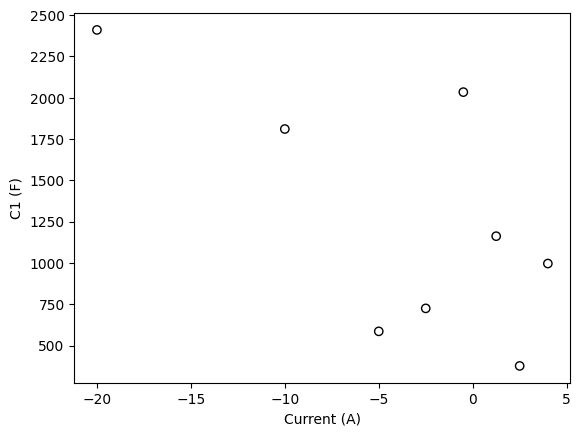

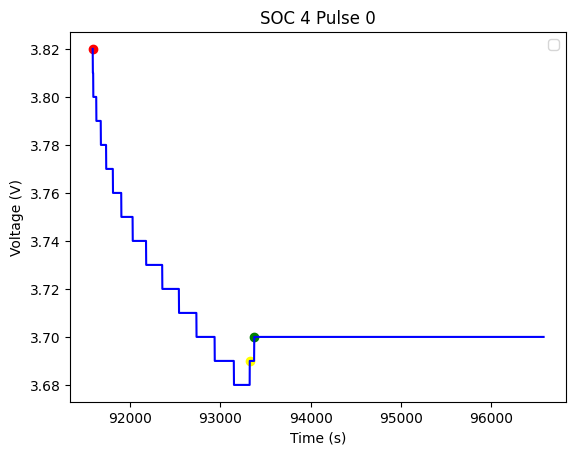

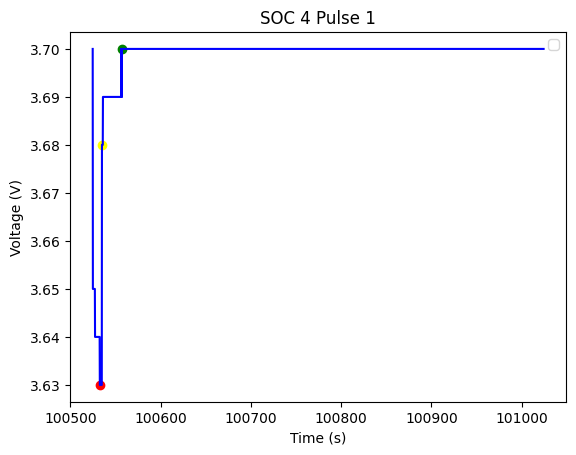

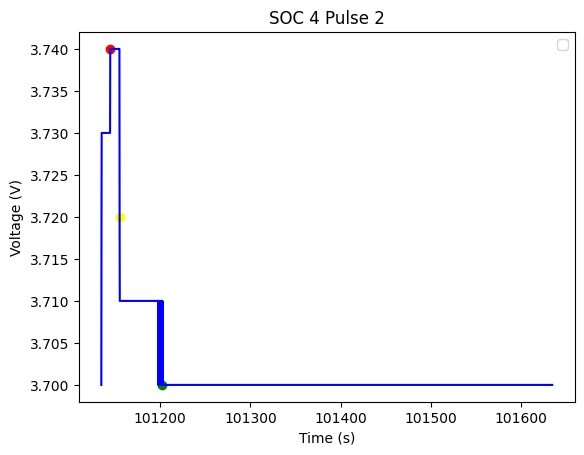

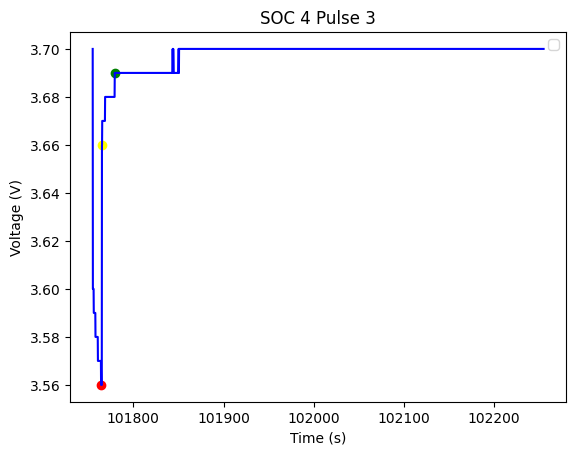

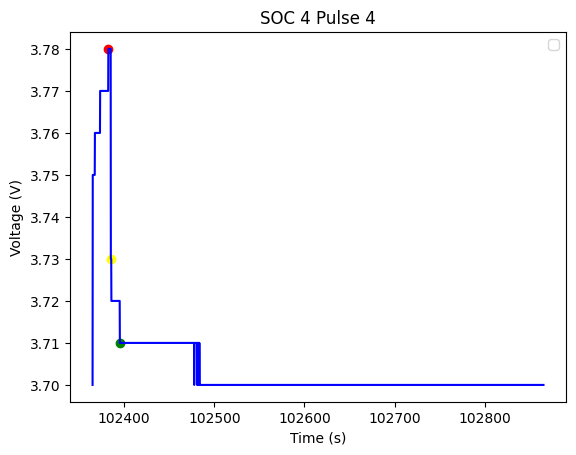

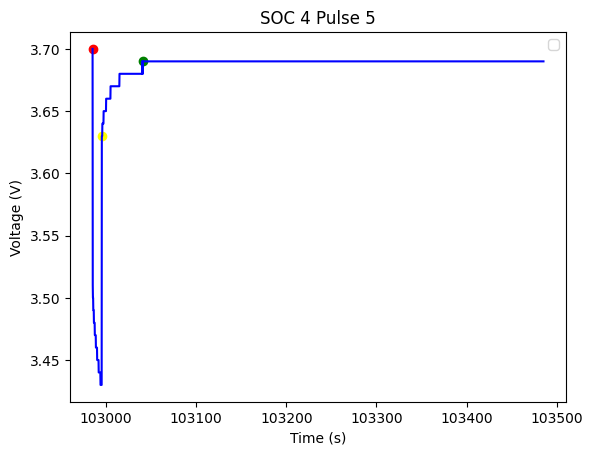

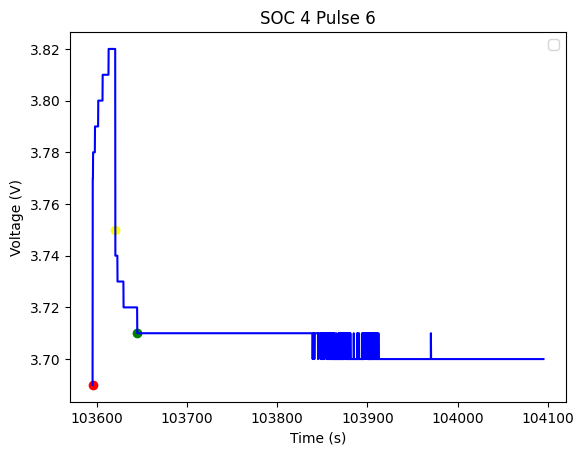

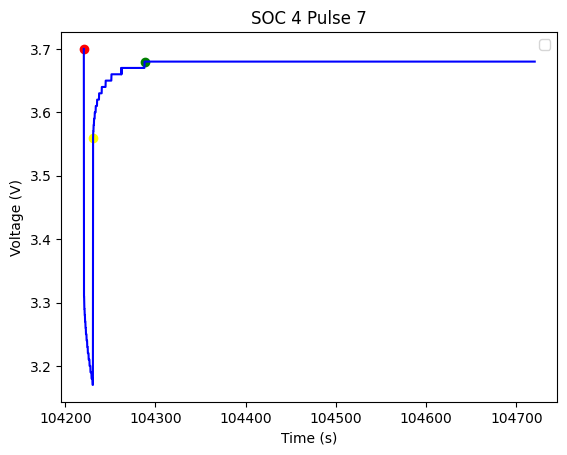

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import least_squares

def FirstOrderECN(t,R0,R1,C1,I,dt,OCV):
    # Initialize i_R1
    i_R1 = np.zeros(len(t))

    # Simulate i_R1 evolution
    for j in range(1, len(t)):
        i_R1[j] = np.exp(-dt/(R1*C1))*i_R1[j-1] + (1-np.exp(-dt/(R1*C1)))*I[j-1]

    #Calculate cell voltage
    modelvol = OCV-(R1*i_R1)-(R0*I)
    return modelvol

def FitFirstOrderECN(t, I, V, dt, OCV):
    # Objective function to minimize
    def objective_function(t, params, I, V, dt, OCV):
        R0, R1, C1 = params
        predvoltage = FirstOrderECN(t, R0, R1, C1, I, dt, OCV)
        residual = predvoltage - V
        return residual

    # Parameters initial guesses (R0, R1, C1)
    InitialGuess = (1, 1, 1)

    # Define the objective function with fixed dt and OCV
    obj_func = lambda params: objective_function(t, params, I, V, dt, OCV)
    result = least_squares(obj_func, InitialGuess)

    # Extract the optimized parameters
    optimized_params = result.x
    return optimized_params

# Task 1 Model Updated
def ECNModel(npulse, nSOC):

    SOCinddata = SOCind[(nSOC)]
    SOCinddata = SOCinddata[(npulse)]
    t = SOCinddata[1]
    I = SOCinddata[2]
    V = SOCinddata[3]

    # Read the CSV file with space and tab-separated values
    df_soc = pd.read_csv('SOC_OCV_MFCTT_2019.csv', delimiter='\t')

    # Extract SOC and OCV data
    SOC_raw = df_soc['SOC\tEcell/V'].str.split('\t', expand=True)[0].astype(float).values
    OCV_raw = df_soc['SOC\tEcell/V'].str.split('\t', expand=True)[1].astype(float).values

    dSOC = SOC_raw[0]-SOC_raw[1] # SOC step
    dt = t[1]-t[0] # time step

    # Immediate voltage jump in current pulse application
    # Find the maximum/minimum voltage during the pulse
    V_max = max(V)
    V_min = min(V)

    # Find voltage at the moment when current switched to zero
    for i in range(1, len(I)):
        if I[i] == 0 and I[i-1] != 0:
          V_switch = V[i]
          t_switch = t[i]
          break
        else:
          # If loop doesn't find zero current, use first voltage
          V_switch = V[0]
          t_switch = t[0]

    dv0 = abs(V_max-V_switch) if abs(V_max-V_switch) > abs(V_min-V_switch) else abs(V_min-V_switch)

    # Calculate current difference
    di = abs(max(I)-min(I))
    R0 = 0.01953

    # Find index corresponding to t_switch
    idx_switch = next(i for i, t_val in enumerate(t) if t_val >= t_switch)

    # Find the index of the first voltage value after the current is switched off
    # Threshold: 30 for 0ºC, 50 for 20ºC, and 20 for 40ºC
    idx_steady_state = None
    steady_state_duration_threshold = 50
    for i in range(idx_switch, len(V)-1):
        if all(abs(V[j] - V[j+1]) < 0.001 for j in range(i, min(i + int(steady_state_duration_threshold / dt), len(V)-1))):
        #if abs(V[i] - V[i+1]) < 0.001:
            idx_steady_state = i
            break
    if idx_steady_state is not None:
        V_steady_state = V[idx_steady_state]
    else:
        # Handle the case where steady state is not found
        V_steady_state = None

    dvinf = abs(V_steady_state-V_max) if abs(V_steady_state-V_max) > abs(V_steady_state-V_min) else abs(V_steady_state-V_min)
    R1 = (dvinf / di) - R0

    # Time to settle after pulse application
    Vmax = V[V==V_max]
    tmax = t[V==Vmax[0]]
    Vmin = V[V==V_min]
    tmin = t[V==Vmin[0]]
    dt_steady_state = t[idx_steady_state]-tmax[0] if abs(V_steady_state-V_max) > abs(V_steady_state-V_min) else t[idx_steady_state]-tmin[0]
    C1 = dt_steady_state / (4 * R1)

    Parameters = [R0,R1,C1]

    plt.figure()
    plt.plot(t, V, color='blue')
    plt.scatter(t_switch, V_switch, color='yellow')
    if len(V[V==V_max])<len(V[V==V_min]):
      plt.scatter(tmax[0], V_max, color='red')
    else:
      plt.scatter(tmin[0], V_min, color='red')
    plt.scatter(t[idx_steady_state], V_steady_state, color='green')
    plt.title(f'SOC {nSOC} Pulse {npulse}')
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)')
    plt.legend()

    print("Parameters (First Order ECN):", R0, R1, C1)

    Qn = 2500 # nominal capacity in mAh

    SOC = np.zeros(np.shape(t)) # SOC at each time step in discharge

    # calculating initial SOC - will match OCV due to long hold
    found = 0
    i = 0
    while not found:
        if V[0] > OCV_raw[i]:
            if abs(V[0] - OCV_raw[i]) < abs(V[0] - OCV_raw[i-1]):
                SOC[0] = SOC_raw[i]
            else:
                SOC[0] = SOC_raw[i-1]
            found = 1
        else:
            i += 1

    for j in range(1,len(t)):
        SOC[j] = SOC[j-1] - 100*(I[j]*dt/3600)/Qn # SOC as percentage

    SOC_ind = ((SOC_raw[0]-SOC)/dSOC-3).astype(int) # array with index corresponding to current SOC value
    OCV = OCV_raw[SOC_ind] # OCV at each time step in discharge

    # Calculate model voltage
    V_model = FirstOrderECN(t, R0, R1, C1, I, dt, OCV) if abs(V_steady_state-V_max) > abs(V_steady_state-V_min) else FirstOrderECN(t, -R0, -R1, -C1, I, dt, OCV)

    return Parameters, I

fig, ax = plt.subplots()
ax.set_xlabel('Current (A)')
ax.set_ylabel('C1 (F)')

# Iterate over each pulse
for j in range(8):
    Parameters, I = ECNModel(j, 4)
    print(Parameters)
    C1 = np.array(Parameters[2])
    for i in range(len(I)):
      if I[i] != 0:
        ax.scatter(I[i], C1, color='black', marker='o', facecolors='none', label=f'Pulse {j+1}')
        break

**Part I: R1 As Function of Current at 60% SOC With CTE R0 (R0 = 0.01953) and CTE C1 (C1 = 1172.9)**

Parameters (First Order ECN): 0.01953 0.008470000000000116 1172.8985


Parameters (First Order ECN): 0.01953 0.01247000000000003 1172.8985


Parameters (First Order ECN): 0.01953 0.006469999999999979 1172.8985


Parameters (First Order ECN): 0.01953 0.008469999999999936 1172.8985


Parameters (First Order ECN): 0.01953 0.006469999999999979 1172.8985


Parameters (First Order ECN): 0.01953 0.00796999999999997 1172.8985


Parameters (First Order ECN): 0.01953 0.0059700000000000135 1172.8985


Parameters (First Order ECN): 0.01953 0.010470000000000028 1172.8985


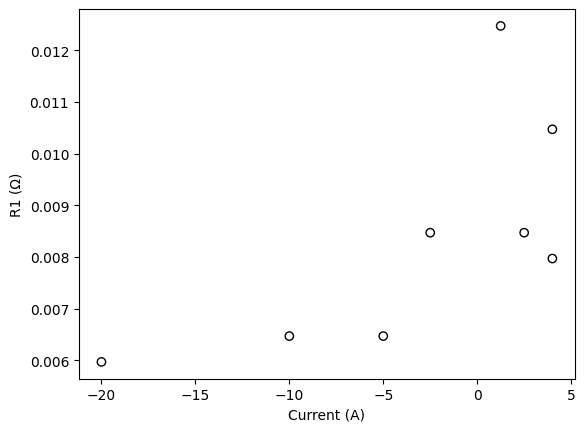

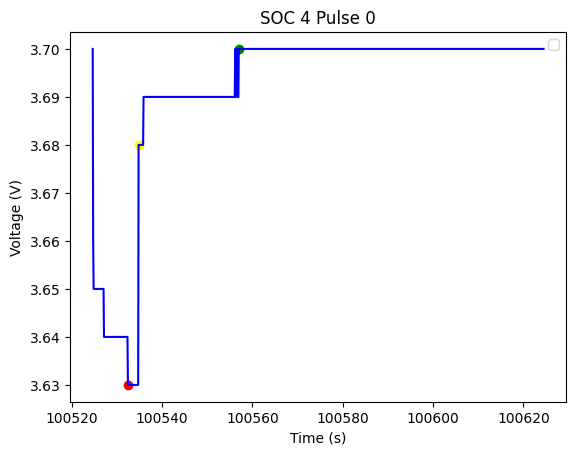

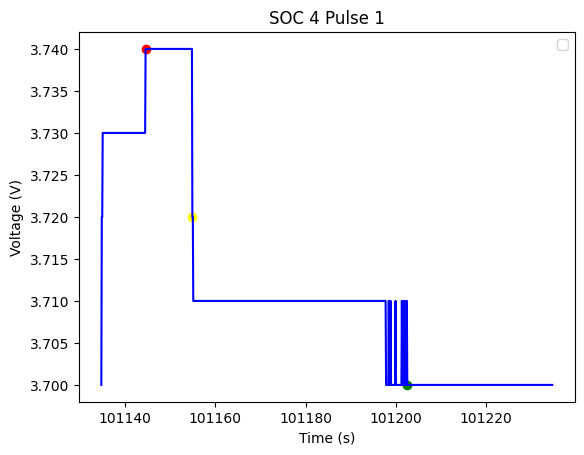

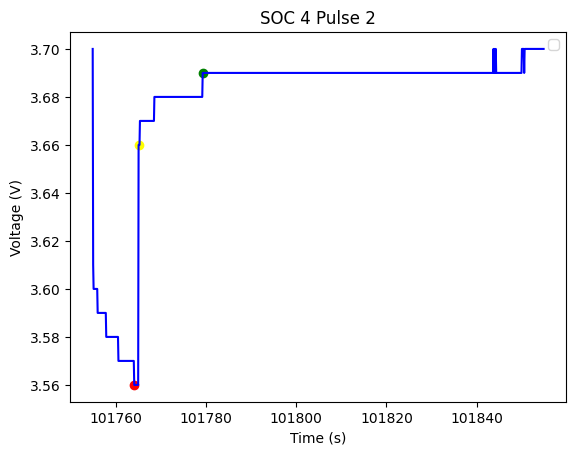

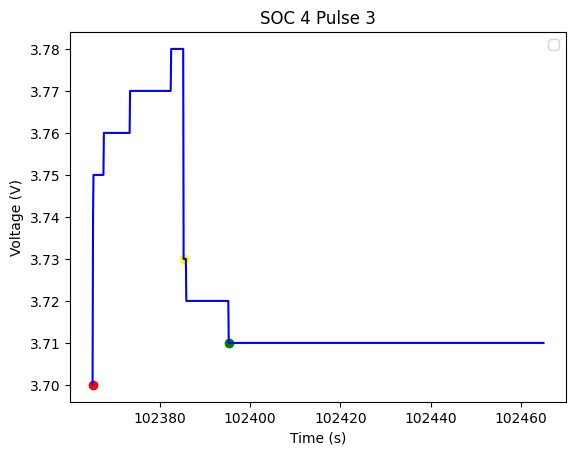

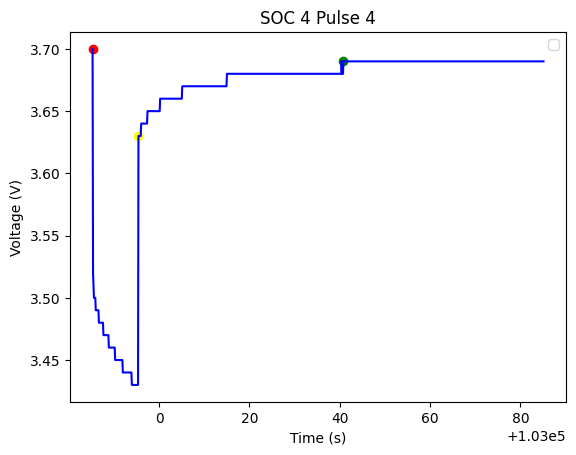

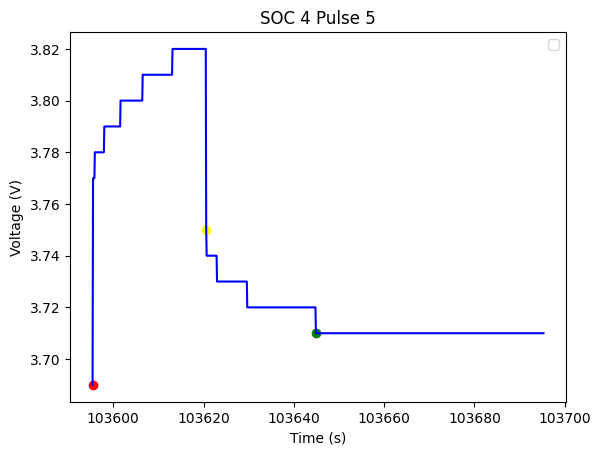

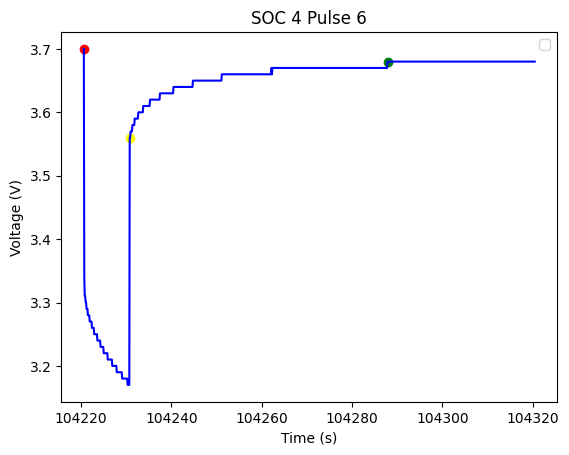

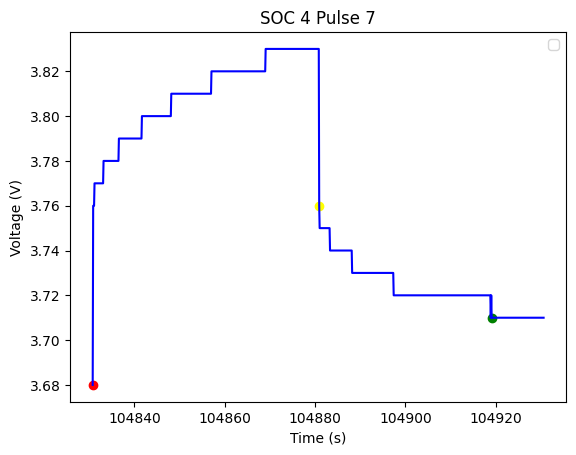

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import least_squares

def FirstOrderECN(t,R0,R1,C1,I,dt,OCV):
    # Initialize i_R1
    i_R1 = np.zeros(len(t))

    # Simulate i_R1 evolution
    for j in range(1, len(t)):
        i_R1[j] = np.exp(-dt/(R1*C1))*i_R1[j-1] + (1-np.exp(-dt/(R1*C1)))*I[j-1]

    #Calculate cell voltage
    modelvol = OCV-(R1*i_R1)-(R0*I)
    return modelvol

def FitFirstOrderECN(t, I, V, dt, OCV):
    # Objective function to minimize
    def objective_function(t, params, I, V, dt, OCV):
        R0, R1, C1 = params
        predvoltage = FirstOrderECN(t, R0, R1, C1, I, dt, OCV)
        residual = predvoltage - V
        return residual

    # Parameters initial guesses (R0, R1, C1)
    InitialGuess = (1, 1, 1)

    # Define the objective function with fixed dt and OCV
    obj_func = lambda params: objective_function(t, params, I, V, dt, OCV)
    result = least_squares(obj_func, InitialGuess)

    # Extract the optimized parameters
    optimized_params = result.x
    return optimized_params

# Task 1 Model Updated
def ECNModel(npulse, nSOC):

    SOCinddata = SOCind[(nSOC)]
    SOCinddata = SOCinddata[(npulse)]
    t = SOCinddata[1]
    I = SOCinddata[2]
    V = SOCinddata[3]

    # Read the CSV file with space and tab-separated values
    df_soc = pd.read_csv('SOC_OCV_MFCTT_2019.csv', delimiter='\t')

    # Extract SOC and OCV data
    SOC_raw = df_soc['SOC\tEcell/V'].str.split('\t', expand=True)[0].astype(float).values
    OCV_raw = df_soc['SOC\tEcell/V'].str.split('\t', expand=True)[1].astype(float).values

    dSOC = SOC_raw[0]-SOC_raw[1] # SOC step
    dt = t[1]-t[0] # time step

    # Immediate voltage jump in current pulse application
    # Find the maximum/minimum voltage during the pulse
    V_max = max(V)
    V_min = min(V)

    # Find voltage at the moment when current switched to zero
    for i in range(1, len(I)):
        if I[i] == 0 and I[i-1] != 0:
          V_switch = V[i]
          t_switch = t[i]
          break
        else:
          # If loop doesn't find zero current, use first voltage
          V_switch = V[0]
          t_switch = t[0]

    dv0 = abs(V_max-V_switch) if abs(V_max-V_switch) > abs(V_min-V_switch) else abs(V_min-V_switch)

    # Calculate current difference
    di = abs(max(I)-min(I))
    R0 = 0.01953

    # Find index corresponding to t_switch
    idx_switch = next(i for i, t_val in enumerate(t) if t_val >= t_switch)

    # Find the index of the first voltage value after the current is switched off
    # Threshold: 30 for 0ºC, 50 for 20ºC, and 20 for 40ºC
    idx_steady_state = None
    steady_state_duration_threshold = 50
    for i in range(idx_switch, len(V)-1):
        if all(abs(V[j] - V[j+1]) < 0.001 for j in range(i, min(i + int(steady_state_duration_threshold / dt), len(V)-1))):
        #if abs(V[i] - V[i+1]) < 0.001:
            idx_steady_state = i
            break
    if idx_steady_state is not None:
        V_steady_state = V[idx_steady_state]
    else:
        # Handle the case where steady state is not found
        V_steady_state = None

    dvinf = abs(V_steady_state-V_max) if abs(V_steady_state-V_max) > abs(V_steady_state-V_min) else abs(V_steady_state-V_min)
    R1 = (dvinf / di) - R0

    # Time to settle after pulse application
    Vmax = V[V==V_max]
    tmax = t[V==Vmax[0]]
    Vmin = V[V==V_min]
    tmin = t[V==Vmin[0]]
    dt_steady_state = t[idx_steady_state]-tmax[0] if abs(V_steady_state-V_max) > abs(V_steady_state-V_min) else t[idx_steady_state]-tmin[0]
    C1 = 1172.8985

    Parameters = [R0,R1,C1]

    plt.figure()
    plt.plot(t, V, color='blue')
    plt.scatter(t_switch, V_switch, color='yellow')
    if len(V[V==V_max])<len(V[V==V_min]):
      plt.scatter(tmax[0], V_max, color='red')
    else:
      plt.scatter(tmin[0], V_min, color='red')
    plt.scatter(t[idx_steady_state], V_steady_state, color='green')
    plt.title(f'SOC {nSOC} Pulse {npulse}')
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)')
    plt.legend()

    print("Parameters (First Order ECN):", R0, R1, C1)

    Qn = 2500 # nominal capacity in mAh

    SOC = np.zeros(np.shape(t)) # SOC at each time step in discharge

    # calculating initial SOC - will match OCV due to long hold
    found = 0
    i = 0
    while not found:
        if V[0] > OCV_raw[i]:
            if abs(V[0] - OCV_raw[i]) < abs(V[0] - OCV_raw[i-1]):
                SOC[0] = SOC_raw[i]
            else:
                SOC[0] = SOC_raw[i-1]
            found = 1
        else:
            i += 1

    for j in range(1,len(t)):
        SOC[j] = SOC[j-1] - 100*(I[j]*dt/3600)/Qn # SOC as percentage

    SOC_ind = ((SOC_raw[0]-SOC)/dSOC-3).astype(int) # array with index corresponding to current SOC value
    OCV = OCV_raw[SOC_ind] # OCV at each time step in discharge

    # Calculate model voltage
    V_model = FirstOrderECN(t, R0, R1, C1, I, dt, OCV) if abs(V_steady_state-V_max) > abs(V_steady_state-V_min) else FirstOrderECN(t, -R0, -R1, -C1, I, dt, OCV)

    return Parameters, I

fig, ax = plt.subplots()
ax.set_xlabel('Current (A)')
ax.set_ylabel('R1 (Ω)')

# Iterate over each pulse
for j in range(8):
    Parameters, I = ECNModel(j, 4)
    R1 = np.array(Parameters[1])
    for i in range(len(I)):
      if I[i] != 0:
        ax.scatter(I[i], R1, color='black', marker='o', facecolors='none', label=f'Pulse {j+1}')
        break

**Part J: Gaussian Function**

Parameters (First Order ECN): 0.01953 0.008470000000000116 1172.8985


Parameters (First Order ECN): 0.01953 0.01247000000000003 1172.8985


Parameters (First Order ECN): 0.01953 0.006469999999999979 1172.8985


Parameters (First Order ECN): 0.01953 0.008469999999999936 1172.8985


Parameters (First Order ECN): 0.01953 0.006469999999999979 1172.8985


Parameters (First Order ECN): 0.01953 0.00796999999999997 1172.8985


Parameters (First Order ECN): 0.01953 0.0059700000000000135 1172.8985


<ipython-input-20-9cf317c5953e>:159: RuntimeWarning: overflow encountered in exp
  return R1 * np.exp(-((I - b)**2) / c) + d


Parameters (First Order ECN): 0.01953 0.010470000000000028 1172.8985


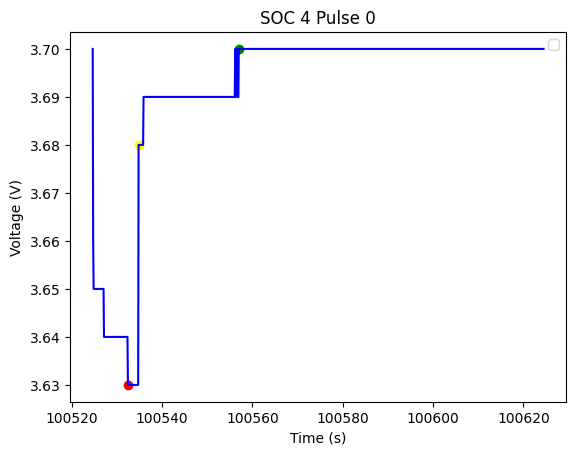

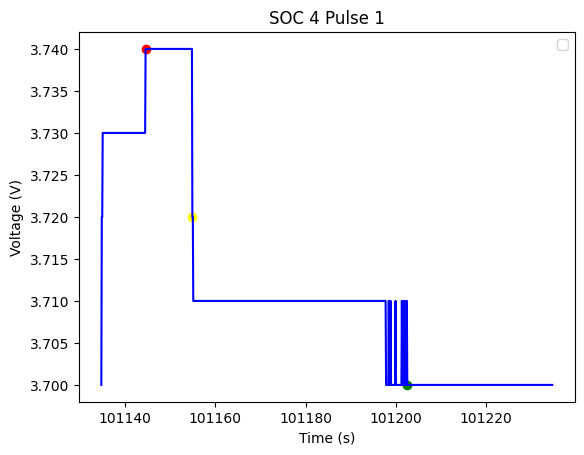

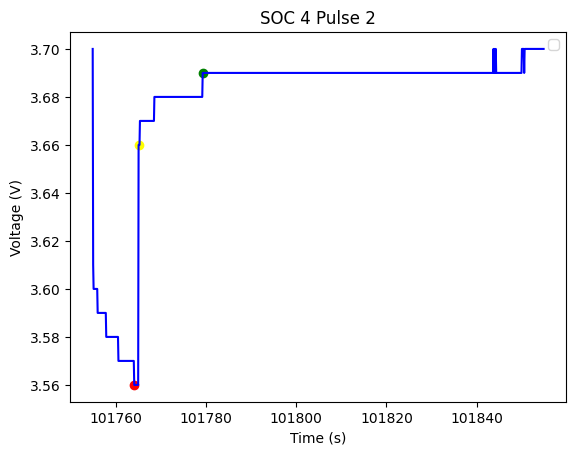

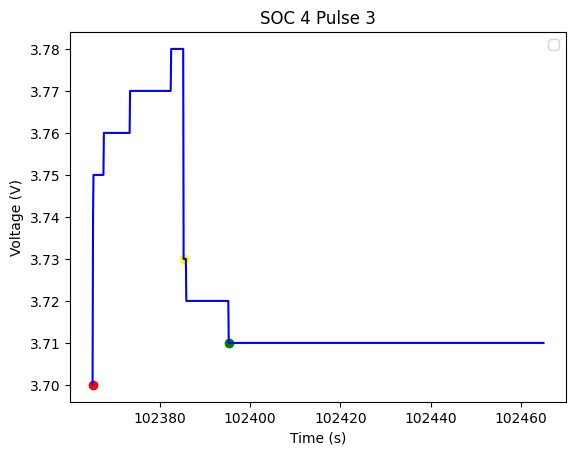

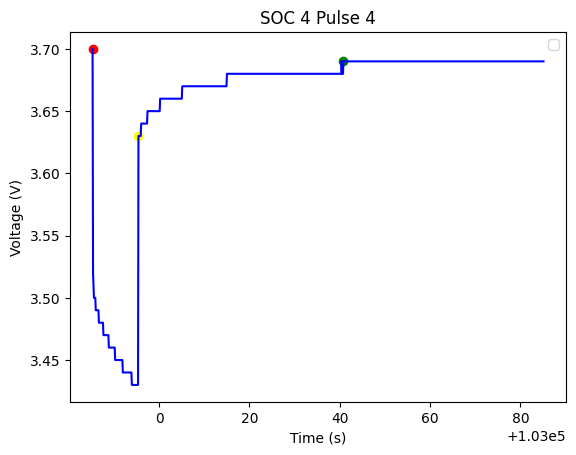

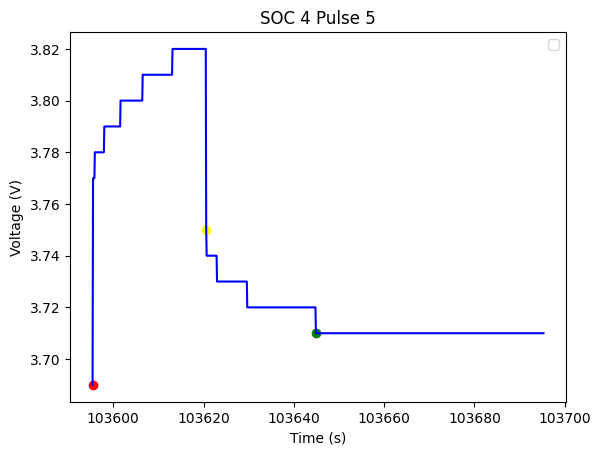

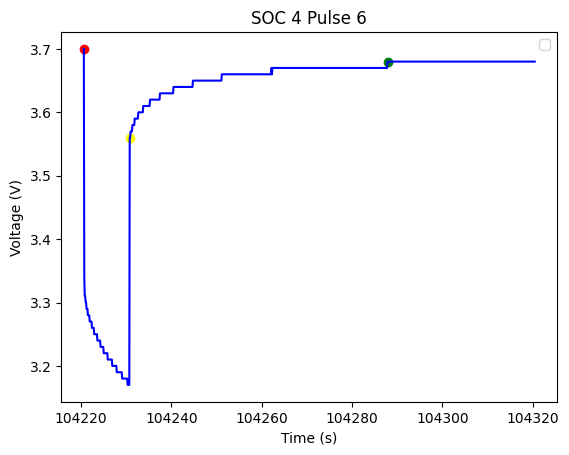

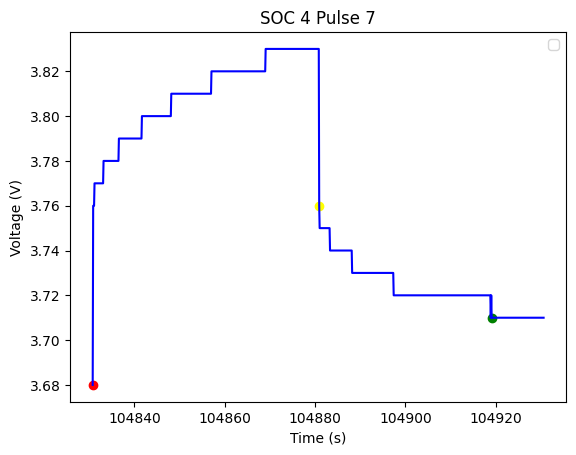

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

def FirstOrderECN(t,R0,R1,C1,I,dt,OCV):
    # Initialize i_R1
    i_R1 = np.zeros(len(t))

    # Simulate i_R1 evolution
    for j in range(1, len(t)):
        i_R1[j] = np.exp(-dt/(R1*C1))*i_R1[j-1] + (1-np.exp(-dt/(R1*C1)))*I[j-1]

    #Calculate cell voltage
    modelvol = OCV-(R1*i_R1)-(R0*I)
    return modelvol

def FitFirstOrderECN(t, I, V, dt, OCV):
    # Objective function to minimize
    def objective_function(t, params, I, V, dt, OCV):
        R0, R1, C1 = params
        predvoltage = FirstOrderECN(t, R0, R1, C1, I, dt, OCV)
        residual = predvoltage - V
        return residual

    # Parameters initial guesses (R0, R1, C1)
    InitialGuess = (1, 1, 1)

    # Define the objective function with fixed dt and OCV
    obj_func = lambda params: objective_function(t, params, I, V, dt, OCV)
    result = least_squares(obj_func, InitialGuess)

    # Extract the optimized parameters
    optimized_params = result.x
    return optimized_params

# Task 1 Model Updated
def ECNModel(npulse, nSOC):

    SOCinddata = SOCind[(nSOC)]
    SOCinddata = SOCinddata[(npulse)]
    t = SOCinddata[1]
    I = SOCinddata[2]
    V = SOCinddata[3]

    # Read the CSV file with space and tab-separated values
    df_soc = pd.read_csv('SOC_OCV_MFCTT_2019.csv', delimiter='\t')

    # Extract SOC and OCV data
    SOC_raw = df_soc['SOC\tEcell/V'].str.split('\t', expand=True)[0].astype(float).values
    OCV_raw = df_soc['SOC\tEcell/V'].str.split('\t', expand=True)[1].astype(float).values

    dSOC = SOC_raw[0]-SOC_raw[1] # SOC step
    dt = t[1]-t[0] # time step

    # Immediate voltage jump in current pulse application
    # Find the maximum/minimum voltage during the pulse
    V_max = max(V)
    V_min = min(V)

    # Find voltage at the moment when current switched to zero
    for i in range(1, len(I)):
        if I[i] == 0 and I[i-1] != 0:
          V_switch = V[i]
          t_switch = t[i]
          break
        else:
          # If loop doesn't find zero current, use first voltage
          V_switch = V[0]
          t_switch = t[0]

    dv0 = abs(V_max-V_switch) if abs(V_max-V_switch) > abs(V_min-V_switch) else abs(V_min-V_switch)

    # Calculate current difference
    di = abs(max(I)-min(I))
    R0 = 0.01953

    # Find index corresponding to t_switch
    idx_switch = next(i for i, t_val in enumerate(t) if t_val >= t_switch)

    # Find the index of the first voltage value after the current is switched off
    # Threshold: 30 for 0ºC, 50 for 20ºC, and 20 for 40ºC
    idx_steady_state = None
    steady_state_duration_threshold = 50
    for i in range(idx_switch, len(V)-1):
        if all(abs(V[j] - V[j+1]) < 0.001 for j in range(i, min(i + int(steady_state_duration_threshold / dt), len(V)-1))):
        #if abs(V[i] - V[i+1]) < 0.001:
            idx_steady_state = i
            break
    if idx_steady_state is not None:
        V_steady_state = V[idx_steady_state]
    else:
        # Handle the case where steady state is not found
        V_steady_state = None

    dvinf = abs(V_steady_state-V_max) if abs(V_steady_state-V_max) > abs(V_steady_state-V_min) else abs(V_steady_state-V_min)
    R1 = (dvinf / di) - R0

    # Time to settle after pulse application
    Vmax = V[V==V_max]
    tmax = t[V==Vmax[0]]
    Vmin = V[V==V_min]
    tmin = t[V==Vmin[0]]
    dt_steady_state = t[idx_steady_state]-tmax[0] if abs(V_steady_state-V_max) > abs(V_steady_state-V_min) else t[idx_steady_state]-tmin[0]
    C1 = 1172.8985

    Parameters = [R0,R1,C1]

    plt.figure()
    plt.plot(t, V, color='blue')
    plt.scatter(t_switch, V_switch, color='yellow')
    if len(V[V==V_max])<len(V[V==V_min]):
      plt.scatter(tmax[0], V_max, color='red')
    else:
      plt.scatter(tmin[0], V_min, color='red')
    plt.scatter(t[idx_steady_state], V_steady_state, color='green')
    plt.title(f'SOC {nSOC} Pulse {npulse}')
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)')
    plt.legend()

    print("Parameters (First Order ECN):", R0, R1, C1)

    Qn = 2500 # nominal capacity in mAh

    SOC = np.zeros(np.shape(t)) # SOC at each time step in discharge

    # calculating initial SOC - will match OCV due to long hold
    found = 0
    i = 0
    while not found:
        if V[0] > OCV_raw[i]:
            if abs(V[0] - OCV_raw[i]) < abs(V[0] - OCV_raw[i-1]):
                SOC[0] = SOC_raw[i]
            else:
                SOC[0] = SOC_raw[i-1]
            found = 1
        else:
            i += 1

    for j in range(1,len(t)):
        SOC[j] = SOC[j-1] - 100*(I[j]*dt/3600)/Qn # SOC as percentage

    SOC_ind = ((SOC_raw[0]-SOC)/dSOC-3).astype(int) # array with index corresponding to current SOC value
    OCV = OCV_raw[SOC_ind] # OCV at each time step in discharge

    # Calculate model voltage
    V_model = FirstOrderECN(t, R0, R1, C1, I, dt, OCV) if abs(V_steady_state-V_max) > abs(V_steady_state-V_min) else FirstOrderECN(t, -R0, -R1, -C1, I, dt, OCV)

    return Parameters, I

Irev = []
R1rev = []
R2rev = []
R1data=[]

# Define the function representing R1_new
def fordergaussian(I, R1, b, c, d):
    return R1 * np.exp(-((I - b)**2) / c) + d

def sordergaussian(I, R1, b1, c1, R2, b2, c2):
       return R1 * np.exp(-((I - b1)**2) / c1) + R11 * np.exp(-((I - b2)**2) / c2)

fig, ax = plt.subplots()
ax.set_xlabel('Current (A)')
ax.set_ylabel('R1 (Ω)')

# Iterate over each pulse
for j in range(8):
    Parameters, I = ECNModel(j, 4)
    R1 = np.array(Parameters[1])
    for i in range(len(I)):
      if I[i] != 0:
        ax.scatter(I[i], R1, color='black', marker='o', facecolors='none', label=f'Pulse {j+1}')
        R11 = fordergaussian(I[i], R1, 1, 0.5, R1)
        R12 = sordergaussian(I[i], R1, 1, 0.5, R1, 1, 0.5)
        Irev.append(I[i])
        R1data.append(R1)
        R1rev.append(R11)
        R2rev.append(R12)
        break

Irev = np.array(Irev)
R1data = np.array(R1data)
R1rev = np.array(R1rev)
R2rev = np.array(R2rev)

# Perform curve fitting
popt, popc = curve_fit(fordergaussian, Irev, R1rev, maxfev = 100000)

# Extract optimized parameters
r1_opt1, b_opt1, c_opt1, d_opt1 = popt

# Generate plot with optimized parameters
I_range = np.linspace(min(Irev), max(Irev), 500)

# Create new R1 array for plotting
R1_fit = fordergaussian(I_range, r1_opt1, b_opt1, c_opt1, d_opt1)

ax.plot(I_range, R1_fit, 'r')

# Perform curve fitting
popt, popc = curve_fit(fordergaussian, Irev, R2rev, maxfev = 100000)

# Extract optimized parameters
r1_opt2, b_opt2, c_opt2, d_opt2 = popt

# Create new R1 array for plotting
R2_fit = fordergaussian(I_range, r1_opt2, b_opt2, c_opt2, d_opt2)

ax.plot(I_range, R2_fit, 'b')


SOC Range: 90% - 100%
Pulse 1: Start Time: 7199.998002, End Time: 12197.771
Pulse 2: Start Time: 16139.76901, End Time: 16639.633
Pulse 3: Start Time: 16749.931, End Time: 17249.793
Pulse 4: Start Time: 17370.091, End Time: 17869.95701
Pulse 5: Start Time: 17980.255, End Time: 18480.119
Pulse 6: Start Time: 18600.417, End Time: 19100.279
Pulse 7: Start Time: 19210.577, End Time: 19710.437
Pulse 8: Start Time: 19835.735, End Time: 20335.599
Pulse 9: Start Time: 20445.897, End Time: 20945.759
SOC Range: 80% - 90%
Pulse 1: Start Time: 28296.128, End Time: 33294.15
Pulse 2: Start Time: 37236.148, End Time: 37736.012
Pulse 3: Start Time: 37846.31, End Time: 38346.172
Pulse 4: Start Time: 38466.47, End Time: 38966.334
Pulse 5: Start Time: 39076.632, End Time: 39576.49401
Pulse 6: Start Time: 39696.79201, End Time: 40196.656
Pulse 7: Start Time: 40306.954, End Time: 40806.816
Pulse 8: Start Time: 40932.114, End Time: 41431.974
Pulse 9: Start Time: 41542.272, End Time: 42042.136
SOC Range: 70%

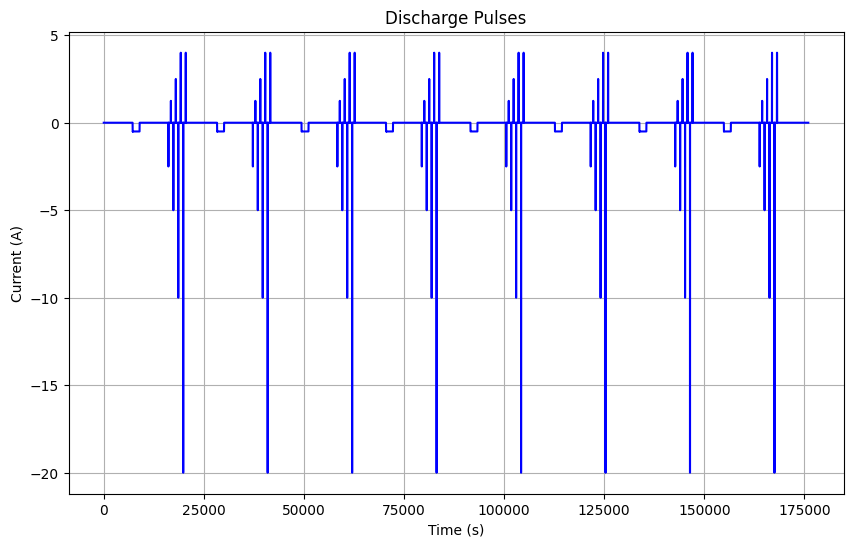

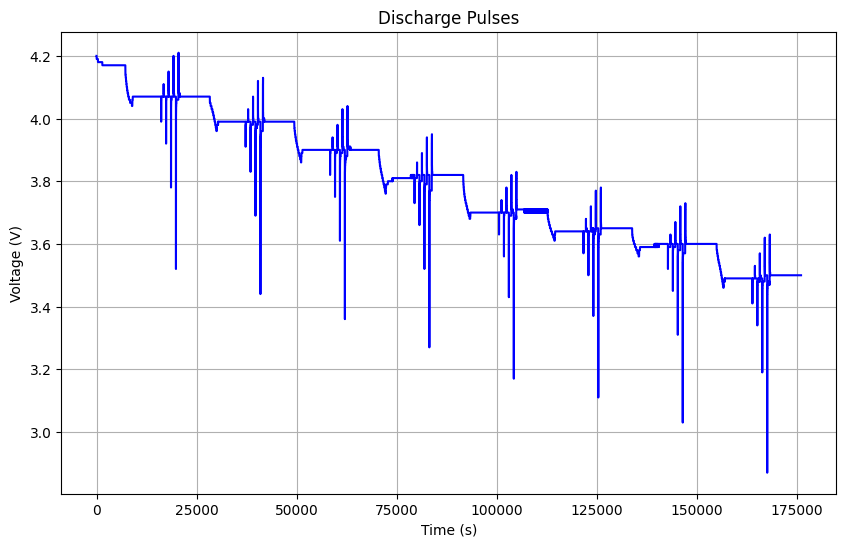

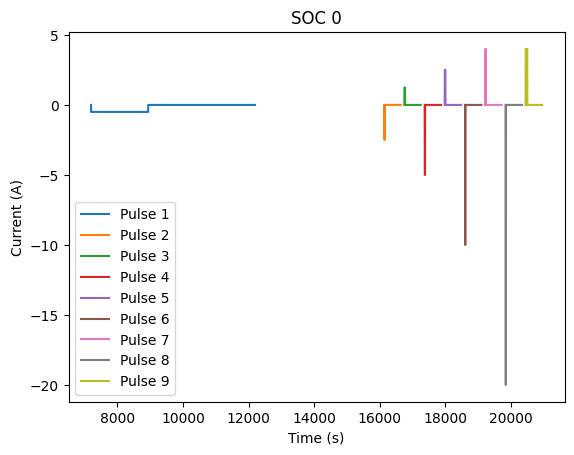

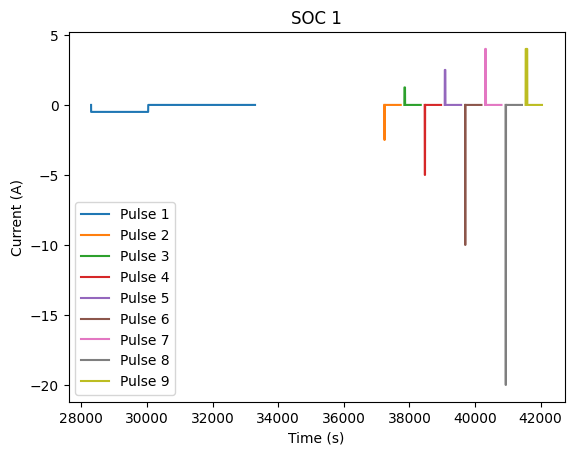

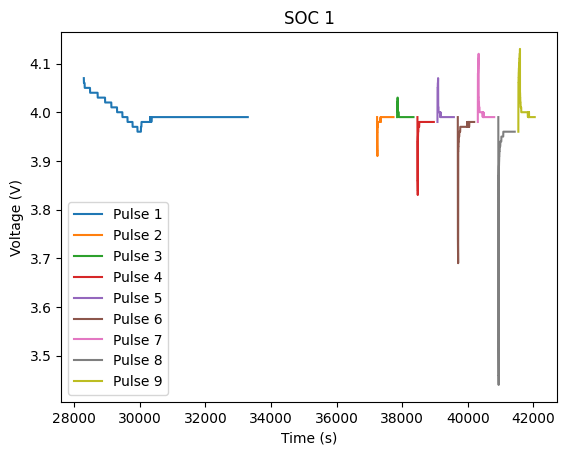

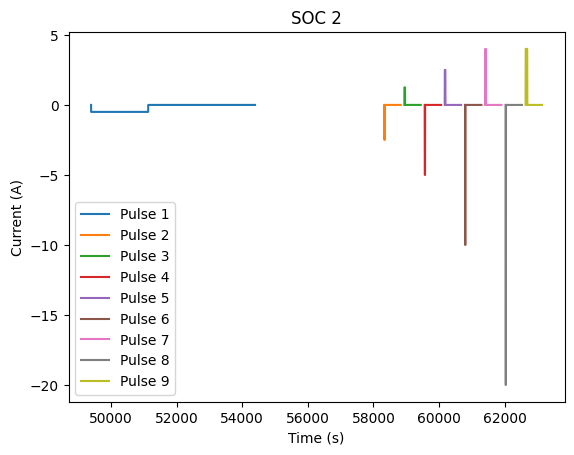

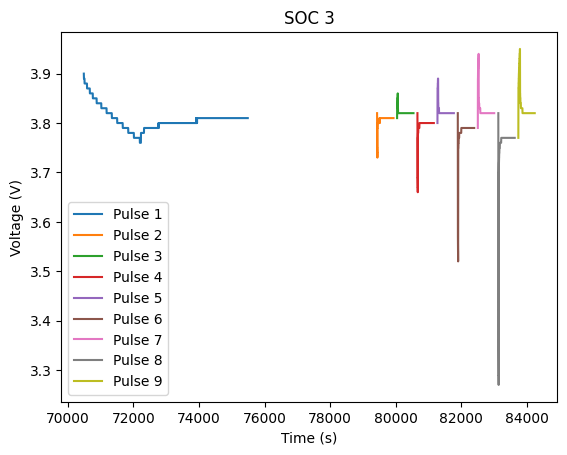

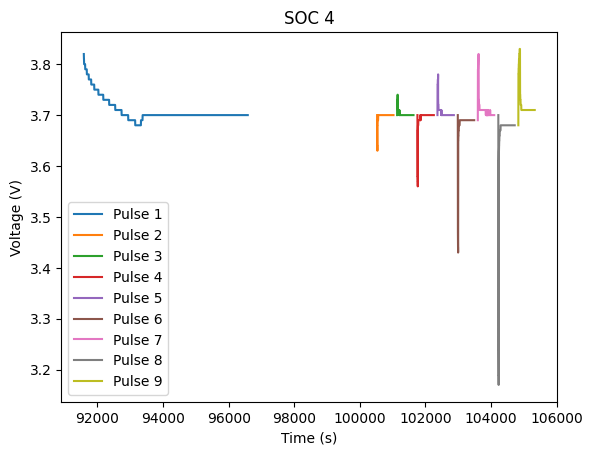

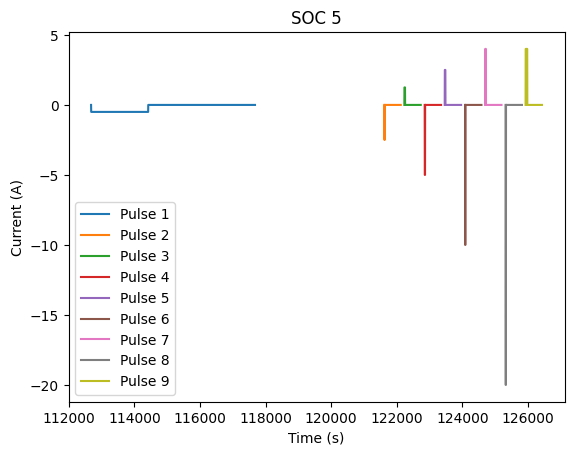

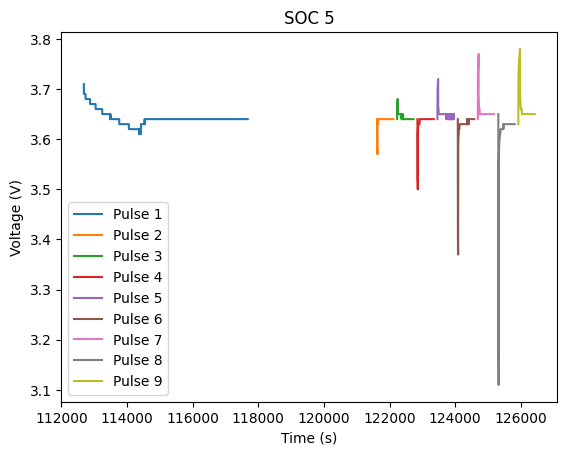

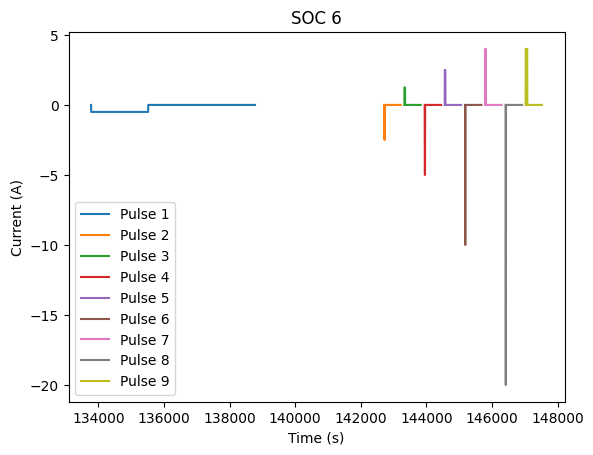

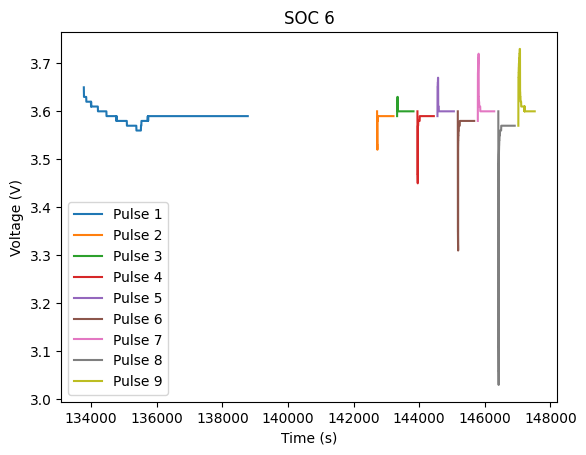

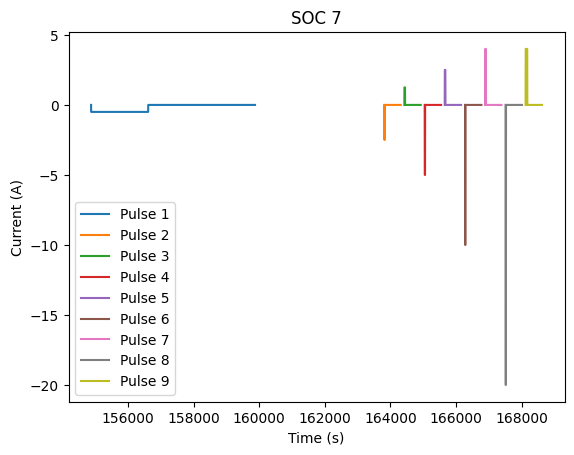

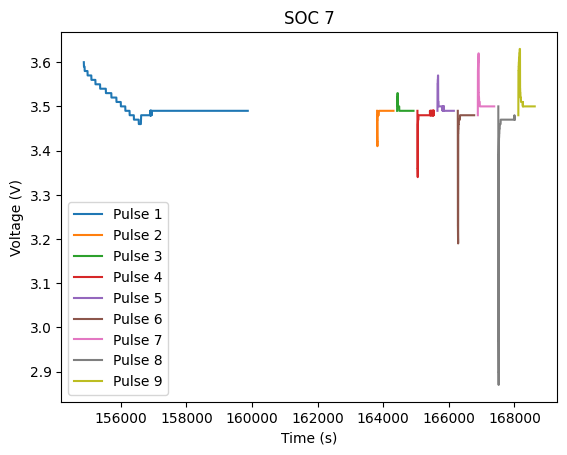

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

# Read CSV file containing training data Temp: 20ºC
df = pd.read_csv('Model_Training_Data_20.csv')
t = np.array(df['Time (s)'][:])
I = np.array(df['Current (A)'][:])
V = np.array(df['Voltage (V)'][:])

# Plot Data - Current
plt.figure(1, figsize=(10, 6))
plt.plot(t, I, label='Current (A)', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.title('Discharge Pulses')
plt.grid(True)

# Plot Data - Voltage
plt.figure(2, figsize=(10, 6))
plt.plot(t, V, label='Voltage (V)', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Discharge Pulses')
plt.grid(True)

def identifypulses(I, threshold=0.3, pulse_duration=50):
    pulses = []
    in_pulse = False
    pulse_start = 0

    for i in range(1, len(I)):
        if abs(I[i] - I[i-1]) > threshold:
            if not in_pulse:
                pulse_start = i - 1
                in_pulse = True
        elif in_pulse:
            if i - pulse_start >= pulse_duration * 100:  # Check if pulse duration is approximately 10 seconds
                pulses.append((pulse_start, i))
                in_pulse = False
    return pulses

# Analyze pulses for the full data range
pulses = identifypulses(I)
pulsestimes = []

for start, end in pulses:
  tpulsestart = t[start]
  tpulsesend = t[end-1]
  pulsestimes.append((tpulsestart, tpulsesend))

# Divide list: 8 subsections - 8 SOC levels
nSOCs = 8
nPulsesSOC = 9
SOCpulseintervals = [[] for _ in range(nSOCs)]

for i, (tstart, tend) in enumerate(pulsestimes):
    SOCindex = i // nPulsesSOC
    SOCpulseintervals[SOCindex].append((tstart, tend))

# Print the identified pulse intervals for each SOC range
for idx, pulses in enumerate(SOCpulseintervals):
    SOCstart = 90 - idx * 10
    SOCend = 100 - idx * 10
    print(f"SOC Range: {SOCstart}% - {SOCend}%")
    for pulse_idx, (start, end) in enumerate(pulses):
        print(f"Pulse {pulse_idx + 1}: Start Time: {start}, End Time: {end}")


# SOCind: list to hold results
SOCind = []

pp1 = 4
pp2 = 13

for i, pulses in enumerate(SOCpulseintervals):
    SOC = SOCpulseintervals[i]
    Pulse = []
    plt.figure(pp1)
    plt.figure(pp2)
    tpulse = np.zeros((10000, 9))
    Ipulse = np.zeros((10000, 9))
    Vpulse = np.zeros((10000, 9))
    for j in enumerate(pulses):
        pulserange = SOC[j[0]]
        # Use NumPy indexing to find matching time indices
        k_indices = np.where((t >= pulserange[0]) & (t <= pulserange[1]))[0]
        # Populate corresponding pulse data
        tpulse[:len(k_indices), j[0]] = t[k_indices]
        Ipulse[:len(k_indices), j[0]] = I[k_indices]
        Vpulse[:len(k_indices), j[0]] = V[k_indices]

        # Plot
        plt.figure(pp1)
        plt.plot(tpulse[:len(k_indices), j[0]], Ipulse[:len(k_indices), j[0]], label=f'Pulse {j[0]+1}')
        plt.title(f'SOC {i}')
        plt.xlabel('Time (s)')
        plt.ylabel('Current (A)')
        plt.legend()
        plt.figure(pp2)
        plt.plot(tpulse[:len(k_indices), j[0]], Vpulse[:len(k_indices), j[0]], label=f'Pulse {j[0]+1}')
        plt.title(f'SOC {i}')
        plt.xlabel('Time (s)')
        plt.ylabel('Voltage (V)')
        plt.legend()

        Pulse.append([j[0], np.copy(tpulse[:len(k_indices), j[0]]), np.copy(Ipulse[:len(k_indices), j[0]]), np.copy(Vpulse[:len(k_indices), j[0]])])
    pp1 = pp1+1
    pp2 = pp2+1
    SOCind.append(Pulse)

Parameters (First Order ECN): 0.01953 0.21999095808383168 1172.8985


Parameters (First Order ECN): 0.01953 0.008470000000000116 1172.8985
[0. 0. 0. ... 0. 0. 0.]


Parameters (First Order ECN): 0.01953 0.01247000000000003 1172.8985
[0. 0. 0. ... 0. 0. 0.]


Parameters (First Order ECN): 0.01953 0.006469999999999979 1172.8985
[0. 0. 0. ... 0. 0. 0.]


Parameters (First Order ECN): 0.01953 0.008469999999999936 1172.8985
[0. 0. 0. ... 0. 0. 0.]


Parameters (First Order ECN): 0.01953 0.006469999999999979 1172.8985
[0. 0. 0. ... 0. 0. 0.]


Parameters (First Order ECN): 0.01953 0.00796999999999997 1172.8985
[0. 0. 0. ... 0. 0. 0.]


Parameters (First Order ECN): 0.01953 0.0059700000000000135 1172.8985
[0. 0. 0. ... 0. 0. 0.]


Parameters (First Order ECN): 0.01953 0.010470000000000028 1172.8985
[0. 0. 0. ... 0. 0. 0.]


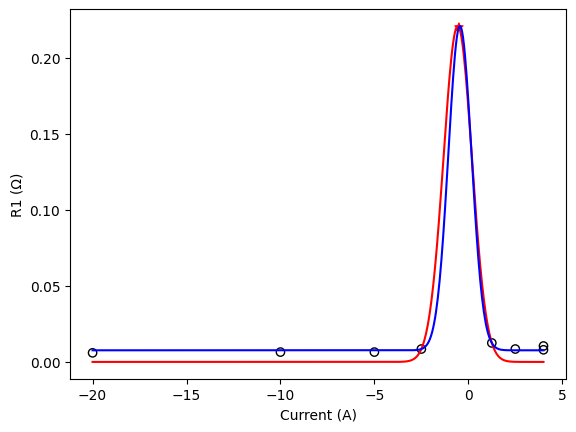

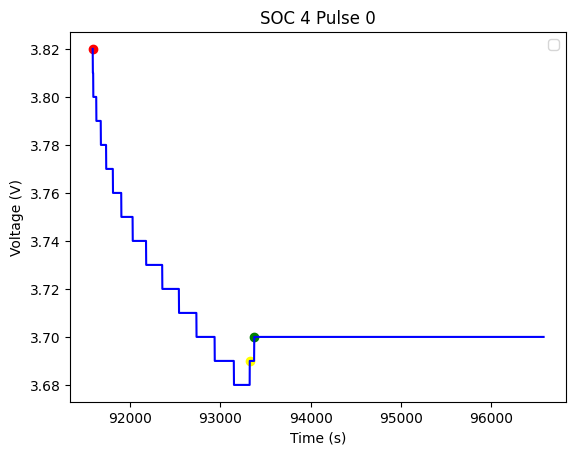

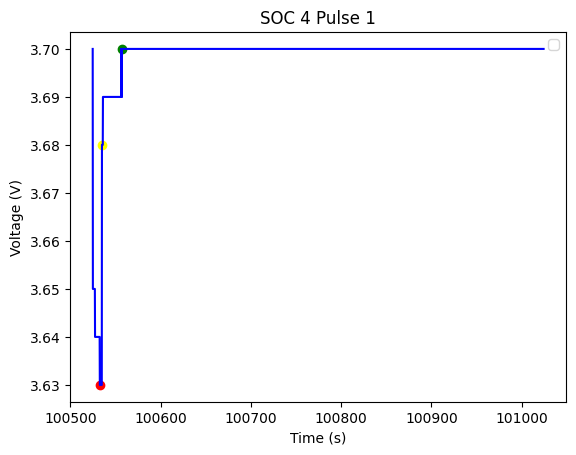

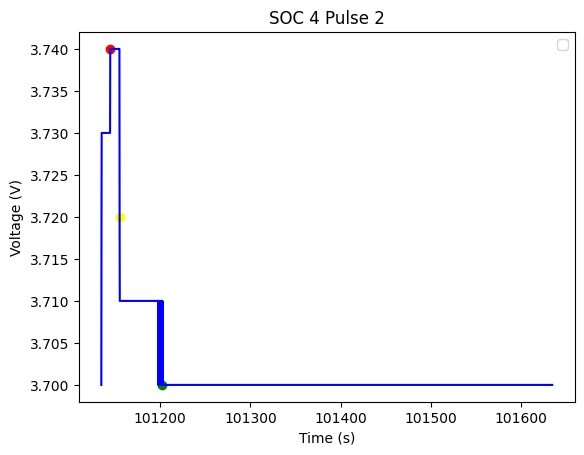

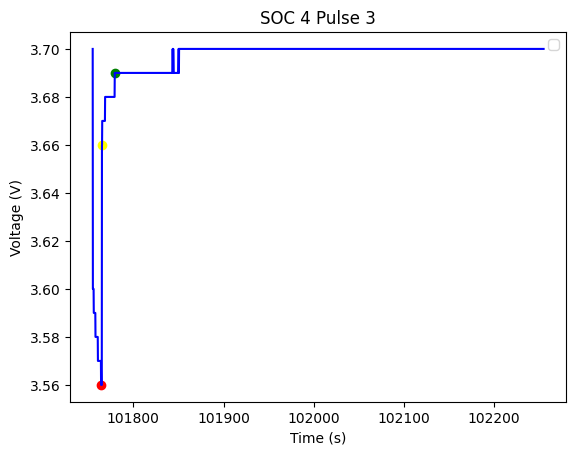

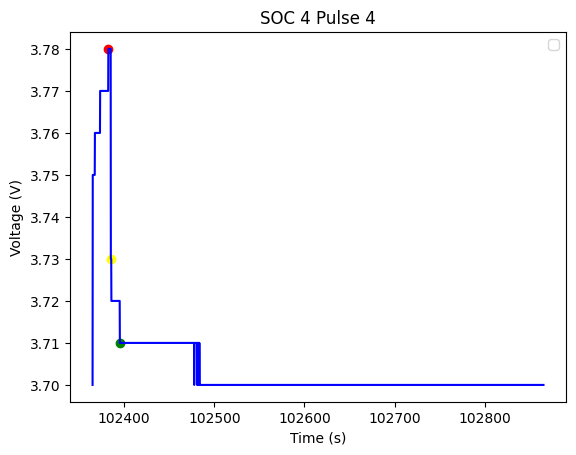

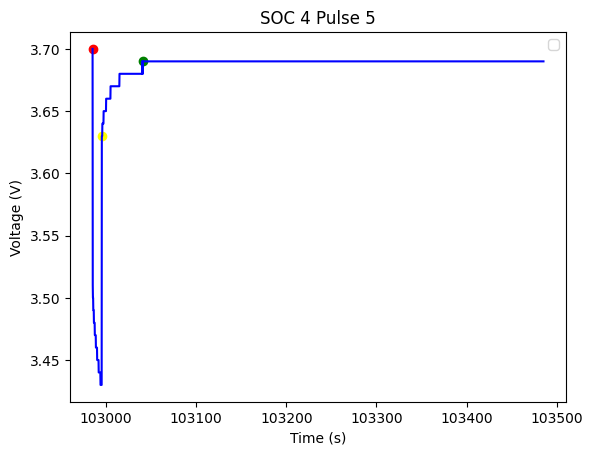

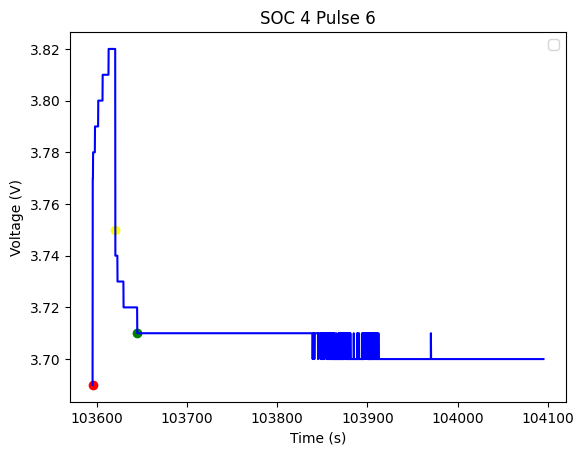

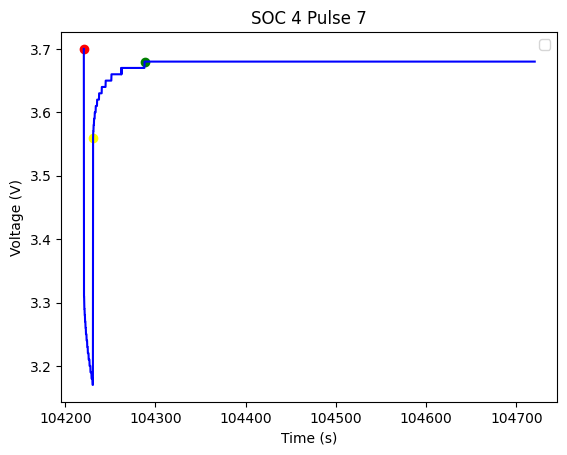

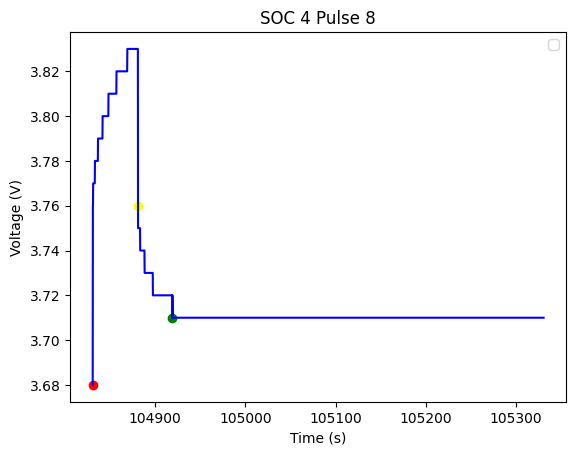

In [4]:

def FirstOrderECN(t,R0,R1,C1,I,dt,OCV):
    # Initialize i_R1
    i_R1 = np.zeros(len(t))

    # Simulate i_R1 evolution
    for j in range(1, len(t)):
        i_R1[j] = np.exp(-dt/(R1*C1))*i_R1[j-1] + (1-np.exp(-dt/(R1*C1)))*I[j-1]

    #Calculate cell voltage
    modelvol = OCV-(R1*i_R1)-(R0*I)
    return modelvol

def FitFirstOrderECN(t, I, V, dt, OCV):
    # Objective function to minimize
    def objective_function(t, params, I, V, dt, OCV):
        R0, R1, C1 = params
        predvoltage = FirstOrderECN(t, R0, R1, C1, I, dt, OCV)
        residual = predvoltage - V
        return residual

    # Parameters initial guesses (R0, R1, C1)
    InitialGuess = (1, 1, 1)

    # Define the objective function with fixed dt and OCV
    obj_func = lambda params: objective_function(t, params, I, V, dt, OCV)
    result = least_squares(obj_func, InitialGuess)

    # Extract the optimized parameters
    optimized_params = result.x
    return optimized_params

# Task 1 Model Updated
def ECNModel(npulse, nSOC):

    SOCinddata = SOCind[(nSOC)]
    SOCinddata = SOCinddata[(npulse)]
    t = SOCinddata[1]
    I = SOCinddata[2]
    V = SOCinddata[3]

    # Read the CSV file with space and tab-separated values
    df_soc = pd.read_csv('SOC_OCV_MFCTT_2019.csv', delimiter='\t')

    # Extract SOC and OCV data
    SOC_raw = df_soc['SOC\tEcell/V'].str.split('\t', expand=True)[0].astype(float).values
    OCV_raw = df_soc['SOC\tEcell/V'].str.split('\t', expand=True)[1].astype(float).values

    dSOC = SOC_raw[0]-SOC_raw[1] # SOC step
    dt = t[1]-t[0] # time step

    # Immediate voltage jump in current pulse application
    # Find the maximum/minimum voltage during the pulse
    V_max = max(V)
    V_min = min(V)

    # Find voltage at the moment when current switched to zero
    for i in range(1, len(I)):
        if I[i] == 0 and I[i-1] != 0:
          V_switch = V[i]
          t_switch = t[i]
          break
        else:
          # If loop doesn't find zero current, use first voltage
          V_switch = V[0]
          t_switch = t[0]

    dv0 = abs(V_max-V_switch) if abs(V_max-V_switch) > abs(V_min-V_switch) else abs(V_min-V_switch)

    # Calculate current difference
    di = abs(max(I)-min(I))
    R0 = 0.01953

    # Find index corresponding to t_switch
    idx_switch = next(i for i, t_val in enumerate(t) if t_val >= t_switch)

    # Find the index of the first voltage value after the current is switched off
    # Threshold: 30 for 0ºC, 50 for 20ºC, and 20 for 40ºC
    idx_steady_state = None
    steady_state_duration_threshold = 50
    for i in range(idx_switch, len(V)-1):
        if all(abs(V[j] - V[j+1]) < 0.001 for j in range(i, min(i + int(steady_state_duration_threshold / dt), len(V)-1))):
        #if abs(V[i] - V[i+1]) < 0.001:
            idx_steady_state = i
            break
    if idx_steady_state is not None:
        V_steady_state = V[idx_steady_state]
    else:
        # Handle the case where steady state is not found
        V_steady_state = None

    dvinf = abs(V_steady_state-V_max) if abs(V_steady_state-V_max) > abs(V_steady_state-V_min) else abs(V_steady_state-V_min)
    R1 = (dvinf / di) - R0

    # Time to settle after pulse application
    Vmax = V[V==V_max]
    tmax = t[V==Vmax[0]]
    Vmin = V[V==V_min]
    tmin = t[V==Vmin[0]]
    dt_steady_state = t[idx_steady_state]-tmax[0] if abs(V_steady_state-V_max) > abs(V_steady_state-V_min) else t[idx_steady_state]-tmin[0]
    C1 = 1172.8985

    Parameters = [R0,R1,C1]

    plt.figure()
    plt.plot(t, V, color='blue')
    plt.scatter(t_switch, V_switch, color='yellow')
    if len(V[V==V_max])<len(V[V==V_min]):
      plt.scatter(tmax[0], V_max, color='red')
    else:
      plt.scatter(tmin[0], V_min, color='red')
    plt.scatter(t[idx_steady_state], V_steady_state, color='green')
    plt.title(f'SOC {nSOC} Pulse {npulse}')
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)')
    plt.legend()

    print("Parameters (First Order ECN):", R0, R1, C1)

    Qn = 2500 # nominal capacity in mAh

    SOC = np.zeros(np.shape(t)) # SOC at each time step in discharge

    # calculating initial SOC - will match OCV due to long hold
    found = 0
    i = 0
    while not found:
        if V[0] > OCV_raw[i]:
            if abs(V[0] - OCV_raw[i]) < abs(V[0] - OCV_raw[i-1]):
                SOC[0] = SOC_raw[i]
            else:
                SOC[0] = SOC_raw[i-1]
            found = 1
        else:
            i += 1

    for j in range(1,len(t)):
        SOC[j] = SOC[j-1] - 100*(I[j]*dt/3600)/Qn # SOC as percentage

    SOC_ind = ((SOC_raw[0]-SOC)/dSOC-3).astype(int) # array with index corresponding to current SOC value
    OCV = OCV_raw[SOC_ind] # OCV at each time step in discharge

    # Calculate model voltage
    V_model = FirstOrderECN(t, R0, R1, C1, I, dt, OCV) if abs(V_steady_state-V_max) > abs(V_steady_state-V_min) else FirstOrderECN(t, -R0, -R1, -C1, I, dt, OCV)

    return Parameters, I, V, t, dt, OCV

Idata = []
R1data=[]

# Define a 1st order Gaussian function to fit R1 values
def fordergaussian(I, R1, b, c):
    return R1 * np.exp(-((I - b)**2) / c)

# Define a 2nd order Gaussian function to fit R1 values
def sordergaussian(I, R1, b, c, d):
       return R1 * np.exp(-((I - b)**2) / c) + d

fig, ax = plt.subplots()
ax.set_xlabel('Current (A)')
ax.set_ylabel('R1 (Ω)')
# Iterate over each pulse
for j in range(9):
    if j == 0:
      Parameters, I_soc, V_soc, t_soc, dt_soc, OCV_soc = ECNModel(j, 4)
      R10 = np.array(Parameters[1])
      ax.scatter(I_soc[i], R10, color='red', marker='*', facecolors='none', label=f'Pulse {j+1}')
      R1data.append(R10)
      Idata.append(I_soc[i])
    else:
      Parameters, I_soc, V_soc, t_soc, dt_soc, OCV_soc = ECNModel(j, 4)
      R1 = np.array(Parameters[1])
      print(I)
      for i in range(len(I)):
        if I_soc[i] != 0:
          ax.scatter(I_soc[i], R1, color='black', marker='o', facecolors='none', label=f'Pulse {j+1}')
          Idata.append(I_soc[i])
          R1data.append(R1)
          break

Idata = np.array(Idata)
R1data = np.array(R1data)

# Perform curve fitting
popt, popc = curve_fit(fordergaussian, Idata, R1data, maxfev = 100000)
# Extract optimized parameters
r1_opt1, b1_opt1, c1_opt1 = popt
# Generate plot with optimized parameters
I_range = np.linspace(min(Idata), max(Idata), 500)
# Create new R1 array for plotting
R1_fit = fordergaussian(I_range, r1_opt1, b1_opt1, c1_opt1)
# Plot 1st order gaussian
ax.plot(I_range, R1_fit, 'r')

# Perform curve fitting
popt, popc = curve_fit(sordergaussian, Idata, R1data, maxfev = 100000)
# Extract optimized parameters
r1_opt2, b_opt2, c_opt2, d_opt2 = popt
# Create new R1 array for plotting
R2_fit = sordergaussian(I_range, r1_opt2, b_opt2, c_opt2, d_opt2)
# Plot 2nd order gaussian
ax.plot(I_range, R2_fit, 'b')


Parameters (First Order ECN): 0.01953 0.20003087824351362 1172.8985
Parameters (First Order ECN): 0.01953 0.01247000000000003 1172.8985
Parameters (First Order ECN): 0.01953 0.01247000000000003 1172.8985
Parameters (First Order ECN): 0.01953 0.010469999999999983 1172.8985
Parameters (First Order ECN): 0.01953 0.008470000000000116 1172.8985
Parameters (First Order ECN): 0.01953 0.008470000000000026 1172.8985
Parameters (First Order ECN): 0.01953 0.010470000000000028 1172.8985
Parameters (First Order ECN): 0.01953 0.0059700000000000135 1172.8985
Parameters (First Order ECN): 0.01953 0.012969999999999975 1172.8985


ValueError: setting an array element with a sequence.

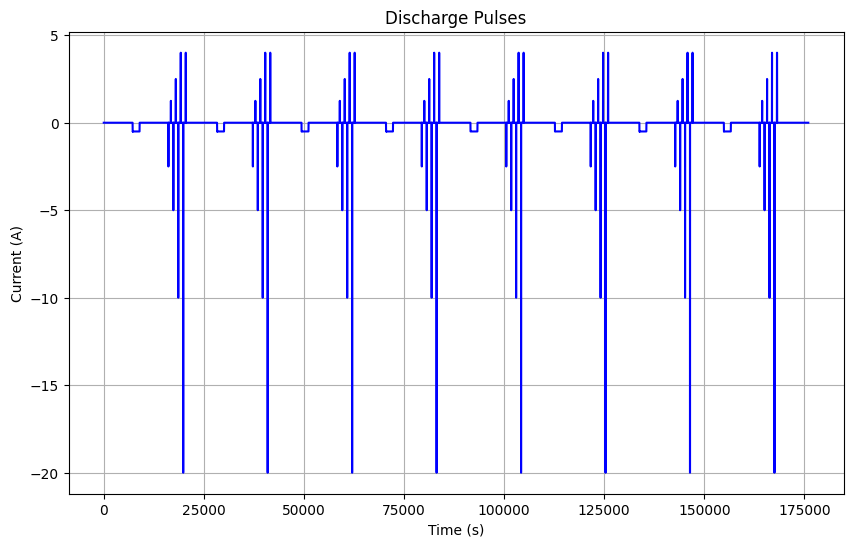

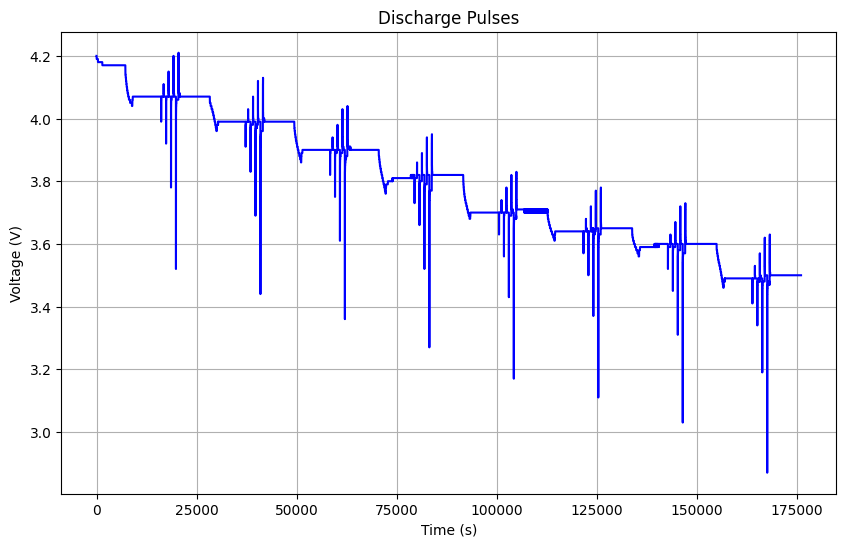

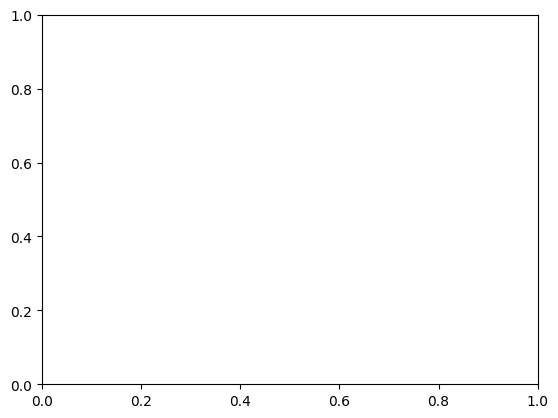

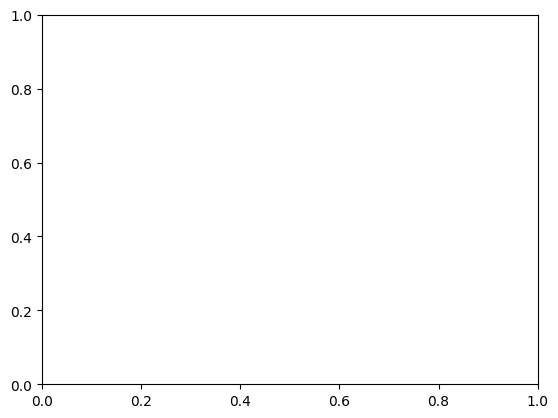

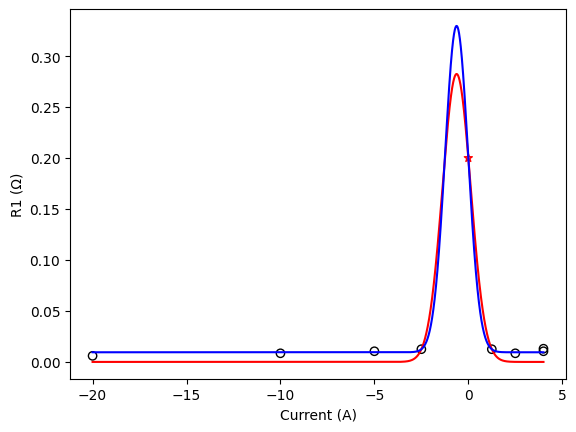

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read CSV file containing training data Temp: 20ºC
dp = pd.read_csv('Model_Training_Data_20.csv')
tt = np.array(dp['Time (s)'][:])
II = np.array(dp['Current (A)'][:])
VV = np.array(dp['Voltage (V)'][:])

# Plot Data - Current
plt.figure(1, figsize=(10, 6))
plt.plot(tt, II, label='Current (A)', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.title('Discharge Pulses')
plt.grid(True)

# Plot Data - Voltage
plt.figure(2, figsize=(10, 6))
plt.plot(tt, VV, label='Voltage (V)', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Discharge Pulses')
plt.grid(True)

def FirstOrderECN(t,R0,R1,C1,I,dt,OCV):
    # Initialize i_R1
    i_R1 = np.zeros(len(t))

    # Simulate i_R1 evolution
    for j in range(1, len(t)):
        i_R1[j] = np.exp(-dt/(R1*C1))*i_R1[j-1] + (1-np.exp(-dt/(R1*C1)))*I[j-1]

    #Calculate cell voltage
    modelvol = OCV-(R1*i_R1)-(R0*I)
    return modelvol

def FirstOrderECNnew(t,R0,R1,C1,I,dt,OCV):
    # Initialize i_R1
    i_R1 = np.zeros(len(t))

    # Simulate i_R1 evolution
    for j in range(1, len(t)):
        i_R1[j] = np.exp(-dt/(R1[j]*C1))*i_R1[j-1] + (1-np.exp(-dt/(R1[j]*C1)))*I[j-1]

    #Calculate cell voltage
    modelvol = OCV-(R1*i_R1)-(R0*I)
    return modelvol

def FitFirstOrderECN(t, I, V, dt, OCV):
    # Objective function to minimize
    def objective_function(t, params, I, V, dt, OCV):
        R0, R1, C1 = params
        predvoltage = FirstOrderECN(t, R0, R1, C1, I, dt, OCV)
        residual = predvoltage - V
        return residual

    # Parameters initial guesses (R0, R1, C1)
    InitialGuess = (1, 1, 1)

    # Define the objective function with fixed dt and OCV
    obj_func = lambda params: objective_function(t, params, I, V, dt, OCV)
    result = least_squares(obj_func, InitialGuess)

    # Extract the optimized parameters
    optimized_params = result.x
    return optimized_params

# Task 1 Model Updated
def ECNModel(npulse, nSOC):
    SOCinddata = SOCind[(nSOC)]
    SOCinddata = SOCinddata[(npulse)]
    t = SOCinddata[1]
    I = SOCinddata[2]
    V = SOCinddata[3]

    # Read the CSV file with space and tab-separated values
    df_soc = pd.read_csv('SOC_OCV_MFCTT_2019.csv', delimiter='\t')

    # Extract SOC and OCV data
    SOC_raw = df_soc['SOC\tEcell/V'].str.split('\t', expand=True)[0].astype(float).values
    OCV_raw = df_soc['SOC\tEcell/V'].str.split('\t', expand=True)[1].astype(float).values

    dSOC = SOC_raw[0]-SOC_raw[1] # SOC step
    dt = t[1]-t[0] # time step

    # Immediate voltage jump in current pulse application
    # Find the maximum/minimum voltage during the pulse
    V_max = max(V)
    V_min = min(V)

    # Find voltage at the moment when current switched to zero
    for i in range(1, len(I)):
        if I[i] == 0 and I[i-1] != 0:
          V_switch = V[i]
          t_switch = t[i]
          break
        else:
          # If loop doesn't find zero current, use first voltage
          V_switch = V[0]
          t_switch = t[0]

    dv0 = abs(V_max-V_switch) if abs(V_max-V_switch) > abs(V_min-V_switch) else abs(V_min-V_switch)

    # Calculate current difference
    di = abs(max(I)-min(I))
    R0 = 0.01953

    # Find index corresponding to t_switch
    idx_switch = next(i for i, t_val in enumerate(t) if t_val >= t_switch)

    # Find the index of the first voltage value after the current is switched off
    # Threshold: 30 for 0ºC, 50 for 20ºC, and 20 for 40ºC
    idx_steady_state = None
    steady_state_duration_threshold = 50
    for i in range(idx_switch, len(V)-1):
        if all(abs(V[j] - V[j+1]) < 0.001 for j in range(i, min(i + int(steady_state_duration_threshold / dt), len(V)-1))):
        #if abs(V[i] - V[i+1]) < 0.001:
            idx_steady_state = i
            break
    if idx_steady_state is not None:
        V_steady_state = V[idx_steady_state]
    else:
        # Handle the case where steady state is not found
        V_steady_state = None

    dvinf = abs(V_steady_state-V_max) if abs(V_steady_state-V_max) > abs(V_steady_state-V_min) else abs(V_steady_state-V_min)
    R1 = (dvinf / di) - R0

    # Time to settle after pulse application
    Vmax = V[V==V_max]
    tmax = t[V==Vmax[0]]
    Vmin = V[V==V_min]
    tmin = t[V==Vmin[0]]
    dt_steady_state = t[idx_steady_state]-tmax[0] if abs(V_steady_state-V_max) > abs(V_steady_state-V_min) else t[idx_steady_state]-tmin[0]
    C1 = 1172.8985

    Parameters = [R0,R1,C1]
    print("Parameters (First Order ECN):", R0, R1, C1)

    Qn = 2500 # nominal capacity in mAh

    SOC = np.zeros(np.shape(t)) # SOC at each time step in discharge

    # calculating initial SOC - will match OCV due to long hold
    found = 0
    i = 0
    while not found:
        if V[0] > OCV_raw[i]:
            if abs(V[0] - OCV_raw[i]) < abs(V[0] - OCV_raw[i-1]):
                SOC[0] = SOC_raw[i]
            else:
                SOC[0] = SOC_raw[i-1]
            found = 1
        else:
            i += 1

    for j in range(1,len(t)):
        SOC[j] = SOC[j-1] - 100*(I[j]*dt/3600)/Qn # SOC as percentage

    SOC_ind = ((SOC_raw[0]-SOC)/dSOC-3).astype(int) # array with index corresponding to current SOC value
    OCV = OCV_raw[SOC_ind] # OCV at each time step in discharge

    # Calculate model voltage
    V_model = FirstOrderECN(t, R0, R1, C1, I, dt, OCV) if abs(V_steady_state-V_max) > abs(V_steady_state-V_min) else FirstOrderECN(t, -R0, -R1, -C1, I, dt, OCV)

    criteria1 = abs(V_steady_state-V_max)
    criteria2 = abs(V_steady_state-V_min)

    return Parameters, I, V, t, dt, OCV, criteria1, criteria2

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
# Define a 2nd order Gaussian function to fit R1 values
def sordergaussiannew(I, R1, b1, c1, d):
      return R1*np.exp(-((I-b1)**2)/c1) + d

for i in range(8):
  Idata = []
  R1data=[]
  fig, ax = plt.subplots()
  ax.set_xlabel('Current (A)')
  ax.set_ylabel('R1 (Ω)')
  SOCN = []
  SOCNEW = []
  # Iterate over each pulse
  for j in range(9):
      if j == 0:
        Parameters, I_soc, V_soc, t_soc, dt_soc, OCV_soc, c1, c2 = ECNModel(j, i)
        R10 = np.array(Parameters[1])
        ax.scatter(I_soc[i], R10, color='red', marker='*', facecolors='none', label=f'Pulse {j+1}')
        R1data.append(R10)
        Idata.append(I_soc[i])
      else:
        Parameters, I_soc, V_soc, t_soc, dt_soc, OCV_soc, c1, c2 = ECNModel(j, i)
        R1 = np.array(Parameters[1])
        for i in range(len(I_soc)):
          if I_soc[i] != 0:
            ax.scatter(I_soc[i], R1, color='black', marker='o', facecolors='none', label=f'Pulse {j+1}')
            Idata.append(I_soc[i])
            R1data.append(R1)
            break
      SOCNEW.append([I_soc,V_soc,t_soc,dt_soc,OCV_soc, c1, c2])
  Idata = np.array(Idata)
  R1data = np.array(R1data)
  # Perform curve fitting
  popt, popc = curve_fit(fordergaussian, Idata, R1data, maxfev = 100000)
  # Extract optimized parameters
  r1_opt1, b_opt1, c_opt1 = popt
  # Generate plot with optimized parameters
  I_range = np.linspace(min(Idata), max(Idata), len(I_soc))
  # Create new R1 array for plotting
  R1_fit = fordergaussian(I_range, r1_opt1, b_opt1, c_opt1)
  # Plot 1st order gaussian
  ax.plot(I_range, R1_fit, 'r')
  # Perform curve fitting
  popt, popc = curve_fit(sordergaussiannew, Idata, R1data, p0=[0.005, -0.5, 60, 0.0055], maxfev = 10000000)
  # Extract optimized parameters
  r1_opt2, b_opt2, c_opt2, d_opt2 = popt
  # Create new R1 array for plotting
  R2_fit = sordergaussiannew(I_range, r1_opt2, b_opt2, c_opt2, d_opt2)
  R2 = np.array([I_range, R2_fit])
  # Plot 2nd order gaussian
  ax.plot(I_range, R2_fit, 'b')

  # Calculate new model voltage
  for j in range(9):
    SOCdata = SOCNEW[j]
    isoc = np.array(SOCdata[0])
    vsoc = np.array(SOCdata[1])
    tsoc = np.array(SOCdata[2])
    dtsoc = np.array(SOCdata[3])
    ocvsoc = np.array(SOCdata[4])
    c1 = np.array(SOCdata[5])
    c2 = np.array(SOCdata[6])
    R2ii = np.zeros(len(tsoc))
    for x in range(len(tsoc)):
      for y in range(len(Idata)):
        if (isoc[x]) == (Idata[y]):
          R2ii[x] = R2_fit[y]
        else:
          print(R2ii)
          print(R2ii)
          R2ii[x] = R2_fit[isoc == I_range]
    print(R2ii)

    if c1 > c2:
      V_model_new = FirstOrderECNnew(tsoc, -Parameters[0], -R2ii, -Parameters[2], isoc, dtsoc, ocvsoc)
    else:
      V_model_new = FirstOrderECNnew(tsoc, -Parameters[0], -R2ii, -Parameters[2], isoc, dtsoc, ocvsoc)

    plt.figure(1)
    plt.plot(tsoc, vsoc,'k')
    plt.plot(tsoc,V_model_new,'r')

    ax1.plot(tsoc, vsoc,'k')
    ax1.plot(tsoc,V_model_new,'r')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Voltage (V)')
    ax1.legend(['Experimental','Model'])

    plt.show

    err =  V_soc-V_model_new # Error between experimental and model voltage
    ax2.plot(t_soc,err)
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Absolute Error')

  # Overlaying current
  #fig, ax1 = plt.subplots()
  #ax1.set_xlabel('Time (s)')
  #ax1.set_ylabel('Absolute Error', c='b')
  #ax1.plot(t_soc,err,'b')
  #ax1.tick_params(axis='y', labelcolor='b')

  #ax2 = ax1.twinx()
  #ax2.set_ylabel('Current (mA)', c='g')
  #ax2.plot(t_soc,I_soc,'g')
  #ax2.tick_params(axis='y', labelcolor='g')

  #fig.tight_layout()
  #plt.show()
